<a href="https://colab.research.google.com/github/fabianhuertas1992/DatosML/blob/main/Entrenamiento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este código realiza un análisis para predecir la biomasa aérea (AGB) utilizando tres modelos de Machine Learning: Regresión Lineal, Random Forest y XGBoost. Los datos de entrada consisten en coordenadas, diámetro de los árboles, altura y el año de la muestra. A continuación, se genera un polígono que cubre el área de interés utilizando la envolvente convexa (convex hull) de los puntos de muestreo.

Se crean una serie de puntos (una cuadrícula) dentro de ese polígono y se asignan valores promedio de diámetro, altura y año para realizar las predicciones de AGB. Los modelos previamente entrenados en los datos se utilizan para predecir la AGB en cada punto de la cuadrícula.

L
os resultados de las predicciones se agrupan en intervalos y se representan gráficamente en tres mapas, uno para cada modelo, donde se colorea cada punto dentro del polígono según el rango de AGB predicho. Los colores del mapa corresponden a diferentes intervalos de AGB, facilitando la comparación visual entre los tres modelos.

In [ ]:
# @title Instalacion de librerias
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 16.0 MB/s eta 0:00:00


# ETL Datos

In [ ]:
# @title Cargar el archivo local
# Cargar los datos desde un archivo CSV (asegúrate de subir el archivo CSV en Google Colab)
from google.colab import files
import pandas as pd

# Cargar el archivo CSV en un DataFrame
uploaded = files.upload()

# Cargar el archivo CSV en un DataFrame
file_name = list(uploaded.keys())[0]  # Obtener el nombre del archivo subido
field_data = pd.read_csv(file_name)

Saving field_data.csv to field_data (1).csv


In [ ]:
# Filtrar el dataset por plot_id 'P8'
field_data = field_data[field_data['plot_id'] == 'P8']

# Mostrar los primeros registros del dataset filtrado
field_data

name       lat        lon   diameter  height    year plot_id  \
0      Cacao -2.181226 -79.576630   0.000000     0.0  2016.0      P8   
1      Cacao -2.181312 -79.576412   0.000000     0.0  2016.0      P8   
2      Cacao -2.181438 -79.576322   0.000000     0.0  2016.0      P8   
3      Cacao -2.181593 -79.576154   0.000000     0.0  2016.0      P8   
4      Cacao -2.181498 -79.576179   0.000000     0.0  2016.0      P8   
..       ...       ...        ...        ...     ...     ...     ...   
867  Musacea -2.181261 -79.576361  17.507003     0.0  2016.0      P8   
868  Musacea -2.181478 -79.576208  14.960530     0.0  2016.0      P8   
869  Musacea -2.181407 -79.576341  14.960530     0.0  2016.0      P8   
870  Musacea -2.181274 -79.576504  11.140820     0.0  2016.0      P8   
871  Musacea -2.181368 -79.576432  16.552075     0.0  2016.0      P8   

                  site            X             Y  updated diameter   group  \
0    Nestor Macias RGB  2761.628615   6831.070678          6.843647   cacao   
1    Nestor Macias RGB  5067.141765   7729.961820          6.843647   cacao   
2    Nestor Macias RGB  6025.223497   9026.909643          6.843647   cacao   
3    Nestor Macias RGB  7803.490078  10637.681956          6.843647   cacao   
4    Nestor Macias RGB  7531.400369   9648.963864          6.843647   cacao   
..                 ...          ...           ...               ...     ...   
867  Nestor Macias RGB  5604.971365   7198.667009         17.507003  banana   
868  Nestor Macias RGB  7227.773230   9441.957813         14.960530  banana   
869  Nestor Macias RGB  5816.526140   8707.904822         14.960530  banana   
870  Nestor Macias RGB  4097.630359   7333.459238         11.140820  banana   
871  Nestor Macias RGB  4861.407656   8308.501255         16.552075  banana   

           AGB    carbon  
0     5.444228  2.123249  
1     5.444228  2.123249  
2     5.444228  2.123249  
3     5.444228  2.123249  
4     5.444228  2.123249  
..         ...       ...  
867  13.340202  5.202679  
868   9.544612  3.722399  
869   9.544612  3.722399  
870   5.093951  1.986641  
871  11.837963  4.616806  

[872 rows x 14 columns]

In [ ]:

# Eliminar los registros duplicados en la columna 'updated diameter'
field_data = field_data.drop_duplicates(subset=['updated diameter'])

# Mostrar los primeros registros del dataset filtrado y sin duplicados en 'updated diameter'
field_data

name       lat        lon   diameter  height    year  \
0                 Cacao -2.181226 -79.576630   0.000000    0.00  2016.0   
9                 Cacao -2.181145 -79.576385   6.079705    2.10  2016.0   
10   Variedad bifurcada -2.181332 -79.576300  17.383118    0.00  2016.0   
14                Cacao -2.181092 -79.576445   5.188439    2.00  2016.0   
16                Cacao -2.181181 -79.576097   7.027643    2.00  2016.0   
..                  ...       ...        ...        ...     ...     ...   
830             Musacea -2.181501 -79.576341   8.085052    0.00  2016.0   
832  Variedad bifurcada -2.181482 -79.576399  15.095373    0.00  2016.0   
842               Cacao -2.181340 -79.575997   5.220658    1.50  2016.0   
845               Cacao -2.181121 -79.576204   5.809818    1.95  2016.0   
862  Variedad bifurcada -2.180999 -79.576244  28.894336    0.00  2016.0   

    plot_id               site            X            Y  updated diameter  \
0        P8  Nestor Macias RGB  2761.628615  6831.070678          6.843647   
9        P8  Nestor Macias RGB  5353.201074  5999.213027          6.079705   
10       P8  Nestor Macias RGB  6256.145219  7936.760658         17.383118   
14       P8  Nestor Macias RGB  4722.875789  5444.295904          5.188439   
16       P8  Nestor Macias RGB  8403.124574  6373.129363          7.027643   
..      ...                ...          ...          ...               ...   
830      P8  Nestor Macias RGB  5826.685849  9682.117986          8.085052   
832      P8  Nestor Macias RGB  5205.991122  9485.368992         15.095373   
842      P8  Nestor Macias RGB  9463.438380  8020.578424          5.220658   
845      P8  Nestor Macias RGB  7275.608527  5746.930877          5.809818   
862      P8  Nestor Macias RGB  6848.159933  4479.614550         28.894336   

      group         AGB      carbon  
0     cacao    5.444228    2.123249  
9     cacao    4.306795    1.679650  
10    other   83.715110   32.648893  
14    cacao    3.146586    1.227169  
16    cacao    5.737862    2.237766  
..      ...         ...         ...  
830  banana    2.573272    1.003576  
832   other   61.174419   23.858024  
842   cacao    3.185392    1.242303  
845   cacao    3.936486    1.535229  
862   other  259.051834  101.030215  

[238 rows x 14 columns]

In [ ]:

# Contar el total de registros después de filtrar y eliminar duplicados
total_registros = field_data.shape[0]

# Mostrar el total de registros
print(f"El total de registros es: {total_registros}")


El total de registros es: 238


In [ ]:
# Contar cuántos registros tienen las mismas coordenadas de latitud y longitud
coord_counts = field_data.groupby(['lat', 'lon']).size()

# Filtrar solo las coordenadas que tienen más de 1 registro
duplicates = coord_counts[coord_counts > 1]

# Mostrar cuántas coordenadas están duplicadas y cuántas veces se repiten
print(f"Coordenadas con más de un registro: {duplicates.count()}")
print(duplicates)


Coordenadas con más de un registro: 0
Series([], dtype: int64)


In [ ]:
# Importar las librerías necesarias
import pandas as pd

field_data = field_data

# Filtrar el dataset por plot_id 'P8'
filtered_data = field_data[field_data['plot_id'] == 'P8']

# Obtener el valor más alto y más bajo de la columna AGB
max_agb = filtered_data['AGB'].max()
min_agb = filtered_data['AGB'].min()

# Mostrar los valores
print(f"Valor más alto de AGB: {max_agb}")
print(f"Valor más bajo de AGB: {min_agb}")


Valor más alto de AGB: 1238.1597831281422
Valor más bajo de AGB: 1.546620468515585


# Poligonos y parcelas

<ipython-input-77-81c295e63dcd>:14: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  convex_hull_polygon = gdf_points.unary_union.convex_hull


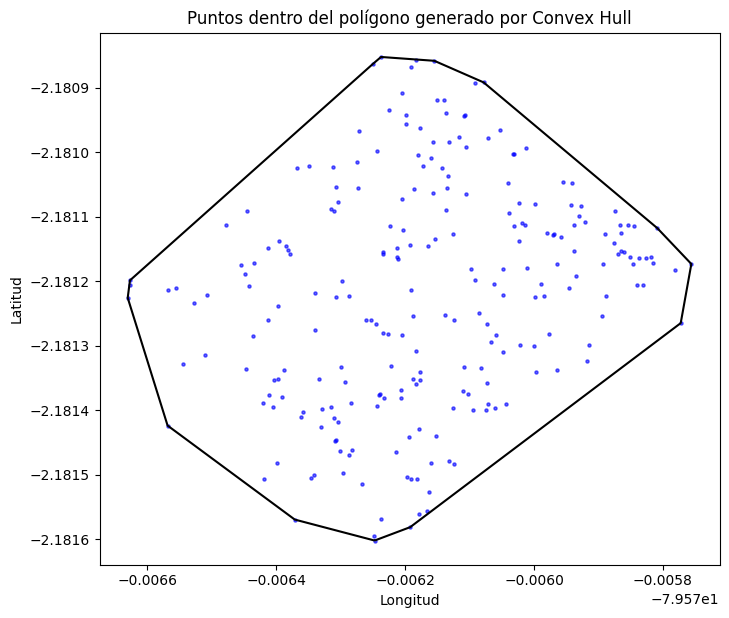

0.5037618441394189

In [ ]:
# @title Polígono generado mediante los Puntos de los vertices (cálculo área poligono)

import geopandas as gpd
from shapely.geometry import Polygon, MultiPoint
import matplotlib.pyplot as plt

# Asegúrate de que los datos ya estén cargados en field_data
# field_data debe contener columnas 'lat' y 'lon'

# Crear un GeoDataFrame para los puntos del dataset filtrado
gdf_points = gpd.GeoDataFrame(field_data, geometry=gpd.points_from_xy(field_data['lon'], field_data['lat']), crs="EPSG:4326")

# Generar el polígono usando la envolvente convexa (convex hull) de todos los puntos
convex_hull_polygon = gdf_points.unary_union.convex_hull

# Crear el GeoDataFrame para el polígono generado por la envolvente convexa
gdf_polygon = gpd.GeoDataFrame({'geometry': [convex_hull_polygon]}, crs="EPSG:4326")

# Mostrar el polígono (envolvente convexa) y los puntos dentro del polígono
fig, ax = plt.subplots(figsize=(8, 8))
gdf_polygon.boundary.plot(ax=ax, color='black')  # Dibujar el polígono (Convex Hull)
gdf_points.plot(ax=ax, color='blue', marker='o', markersize=5, alpha=0.6)  # Dibujar los puntos

ax.set_title('Puntos dentro del polígono generado por Convex Hull')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show()

# Convertir el GeoDataFrame a un sistema de coordenadas proyectadas (por ejemplo, EPSG:3857 para metros)
gdf_polygon_meters = gdf_polygon.to_crs(epsg=3857)

# Calcular el área en hectáreas (1 hectárea = 10,000 m²)
area_ha = gdf_polygon_meters['geometry'].area / 10000  # Dividir por 10,000 para convertir de m² a hectáreas

# Mostrar el área en hectáreas
area_ha.iloc[0]


In [ ]:
# @title genera datos polígono
import geopandas as gpd
from shapely.geometry import Polygon

# Crear un GeoDataFrame para los puntos del dataset
gdf_points = gpd.GeoDataFrame(field_data, geometry=gpd.points_from_xy(field_data['lon'], field_data['lat']), crs="EPSG:4326")

# Generar el polígono usando la envolvente convexa (convex hull) de todos los puntos
convex_hull_polygon = gdf_points.unary_union.convex_hull

# Obtener las coordenadas del polígono generado (Convex Hull)
hull_coords = list(convex_hull_polygon.exterior.coords)

# Formatear las coordenadas en el formato deseado: [[lon, lat], [lon, lat], ...]
formatted_coords = [[lon, lat] for lon, lat in hull_coords]

# Mostrar las coordenadas formateadas en el formato de corchetes
print(formatted_coords)


[[-79.57624719, -2.18160185], [-79.57637103, -2.18156934], [-79.57656828, -2.18142366], [-79.57663014, -2.18122567], [-79.57662668, -2.18119865], [-79.57624931, -2.18086266], [-79.57623722, -2.18085237], [-79.57615457, -2.18085832], [-79.57607819, -2.18089176], [-79.57580881, -2.18111763], [-79.57575595, -2.18117321], [-79.57577244, -2.18126487], [-79.57619201, -2.18158109], [-79.57624719, -2.18160185]]


<ipython-input-99-7a55ec8519ff>:9: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  convex_hull_polygon = gdf_points.unary_union.convex_hull


In [ ]:
field_data['AGB'].sum()

7980.986807894744

Este código genera parcelas (agrupaciones de puntos) utilizando el algoritmo de K-Means y luego calcula varias estadísticas para cada parcela, como el área en hectáreas, la biomasa aérea (AGB) total y el carbono almacenado. Aquí te dejo un resumen simple de los pasos clave:

1. **Agrupación de puntos en parcelas**: Se agrupan los puntos (coordenadas) en un número específico de parcelas usando K-Means.
2. **Cálculo del área de las parcelas**: Para cada grupo de puntos, se genera la envolvente convexa (Convex Hull), que es el polígono que cubre todos los puntos del grupo, y se calcula el área en hectáreas.
3. **Cálculo de biomasa y carbono**: Se suman los valores de biomasa aérea (AGB) y carbono para cada parcela.
4. **Cálculo de promedios**: Se calculan las medias de los diámetros y alturas de los árboles dentro de cada parcela.
5. **Cálculo de biomasa por hectárea**: Finalmente, se añade una columna con la biomasa en megagramos por hectárea (Mg/ha), dividiendo la biomasa total de cada parcela por el área.

El resultado es un GeoDataFrame que contiene las parcelas con la información calculada para cada una, incluyendo la biomasa por hectárea.

In [ ]:
# @title Se genera parcelas y cálculo Biomasa mg/ha
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import geopandas as gpd
from shapely.geometry import MultiPoint, Point

# Convertir las coordenadas de los puntos en un GeoDataFrame
gdf_points = gpd.GeoDataFrame(field_data, geometry=gpd.points_from_xy(field_data['lon'], field_data['lat']), crs="EPSG:4326")

# Extraer las coordenadas en un formato adecuado para KMeans
coords = np.array(list(zip(field_data['lat'], field_data['lon'])))

# Definir el número de parcelas o grupos que deseas obtener
n_clusters = 20  # Puedes ajustar este número según cuántas parcelas deseas

# Aplicar K-Means para agrupar los puntos en n_clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(coords)

# Añadir las etiquetas de los clusters al GeoDataFrame
gdf_points['cluster'] = kmeans.labels_

# Crear una lista vacía para almacenar los datos de las parcelas
parcelas_data = []

# Agrupar por el clúster (parcela) y calcular el área de cada parcela (Convex Hull), y otras estadísticas
for cluster_id, group in gdf_points.groupby('cluster'):
    # Obtener la envolvente convexa de los puntos del clúster (polígono de la parcela)
    convex_hull = MultiPoint([Point(xy) for xy in zip(group.geometry.x, group.geometry.y)]).convex_hull

    # Calcular el área de la parcela (Convex Hull) en hectáreas
    gdf_polygon_meters = gpd.GeoDataFrame({'geometry': [convex_hull]}, crs="EPSG:4326").to_crs(epsg=3857)
    area_hectares = gdf_polygon_meters['geometry'].area.iloc[0] / 10000  # Convertir de m² a hectáreas

    # Calcular la suma de AGB y Carbono
    agb_sum = group['AGB'].sum()
    carbon_sum = group['carbon'].sum()

    # Calcular los promedios de updated diameter y height
    updated_diameter_mean = group['updated diameter'].mean()
    height_mean = group['height'].mean()

    # Mantener las coordenadas latitud y longitud originales de los puntos
    lat_mean = group['lat'].mean()
    lon_mean = group['lon'].mean()

    # Almacenar los resultados como una nueva fila
    parcelas_data.append({
        'cluster_id': cluster_id,
        'area_hectares': area_hectares,
        'agb_sum': agb_sum,
        'carbon_sum': carbon_sum,
        'updated_diameter_mean': updated_diameter_mean,
        'height_mean': height_mean,
        'lat_mean': lat_mean,
        'lon_mean': lon_mean,
        'geometry': convex_hull
    })

# Crear un nuevo GeoDataFrame a partir de las filas almacenadas
gdf_parcelas = gpd.GeoDataFrame(parcelas_data, crs="EPSG:4326")

# Añadir la columna 'Biomasa (Mg/ha)' dividiendo agb_sum entre area_hectares
gdf_parcelas['Biomasa (Mg/ha)'] = gdf_parcelas['agb_sum'] / gdf_parcelas['area_hectares']/10000

# Mostrar el GeoDataFrame con la nueva columna
gdf_parcelas


cluster_id  area_hectares      agb_sum  carbon_sum  updated_diameter_mean  \
0            0       0.020627   226.286279   88.251649               9.132365   
1            1       0.008302   243.087021   94.803938              11.072914   
2            2       0.011757   214.541806   83.671304               9.250054   
3            3       0.009600   397.780473  155.134384              14.151601   
4            4       0.011213   188.242361   73.414521               9.904458   
5            5       0.008956   280.762212  109.497263              10.290732   
6            6       0.004431   132.347293   51.615444              11.479539   
7            7       0.007141  1619.233955  631.501242              15.741450   
8            8       0.001990    89.273926   34.816831               9.098755   
9            9       0.010051   454.619142  177.301465              12.487728   
10          10       0.009100   563.447627  219.744574              12.941434   
11          11       0.016243   440.608865  171.837457              10.130275   
12          12       0.014162   340.521340  132.803322              12.338510   
13          13       0.009635   377.434385  147.199410              11.508385   
14          14       0.006434    93.092614   36.306120              10.978400   
15          15       0.011577   577.124747  225.078651              12.288899   
16          16       0.010860   874.486330  341.049669              14.318192   
17          17       0.009080   434.668958  169.520894              11.909148   
18          18       0.003234   335.820750  130.970092              12.369592   
19          19       0.006050    97.606726   38.066623               9.134781   

    height_mean  lat_mean   lon_mean  \
0      0.620000 -2.181257 -79.576566   
1      0.000000 -2.181130 -79.575995   
2      0.666667 -2.181252 -79.576253   
3      0.190909 -2.180898 -79.576194   
4      0.421429 -2.181369 -79.576385   
5      0.280000 -2.180996 -79.576138   
6      0.363636 -2.181377 -79.576086   
7      0.000000 -2.181148 -79.575841   
8      0.400000 -2.181577 -79.576211   
9      0.493750 -2.181216 -79.575875   
10     0.130000 -2.181124 -79.576190   
11     0.260000 -2.181474 -79.576325   
12     0.292857 -2.181172 -79.576415   
13     0.190909 -2.181038 -79.576302   
14     0.345455 -2.181478 -79.576171   
15     0.325000 -2.181235 -79.576074   
16     0.400000 -2.181302 -79.575980   
17     0.146667 -2.181360 -79.576225   
18     0.525000 -2.181084 -79.575929   
19     0.612500 -2.180972 -79.576051   

                                             geometry  Biomasa (Mg/ha)  
0   POLYGON ((-79.57657 -2.18142, -79.57663 -2.181...         1.097030  
1   POLYGON ((-79.57599 -2.1812, -79.57601 -2.1811...         2.928117  
2   POLYGON ((-79.57621 -2.18128, -79.57634 -2.181...         1.824725  
3   POLYGON ((-79.5762 -2.18096, -79.57623 -2.1809...         4.143559  
4   POLYGON ((-79.57636 -2.18141, -79.57641 -2.181...         1.678756  
5   POLYGON ((-79.57611 -2.18106, -79.57614 -2.181...         3.134859  
6   POLYGON ((-79.57607 -2.1814, -79.57609 -2.1814...         2.986752  
7   POLYGON ((-79.57578 -2.18118, -79.57585 -2.181...        22.674925  
8   POLYGON ((-79.57625 -2.1816, -79.57625 -2.1815...         4.486572  
9   POLYGON ((-79.57577 -2.18126, -79.5759 -2.1812...         4.523213  
10  POLYGON ((-79.57621 -2.18116, -79.57623 -2.181...         6.191464  
11  POLYGON ((-79.57637 -2.18157, -79.57642 -2.181...         2.712547  
12  POLYGON ((-79.57641 -2.18126, -79.57644 -2.181...         2.404454  
13  POLYGON ((-79.57631 -2.18109, -79.57631 -2.181...         3.917295  
14  POLYGON ((-79.57616 -2.18153, -79.5762 -2.1815...         1.446824  
15  POLYGON ((-79.57607 -2.18129, -79.57614 -2.181...         4.985135  
16  POLYGON ((-79.576 -2.18134, -79.57605 -2.18131...         8.052370  
17  POLYGON ((-79.57624 -2.18139, -79.57628 -2.181...         4.787300  
18  POLYGON ((-79.57594 -2.18111, -79.57596 -2.181...        10.383034  
1

In [ ]:
gdf_parcelas['agb_sum'].sum()

7980.986807894744

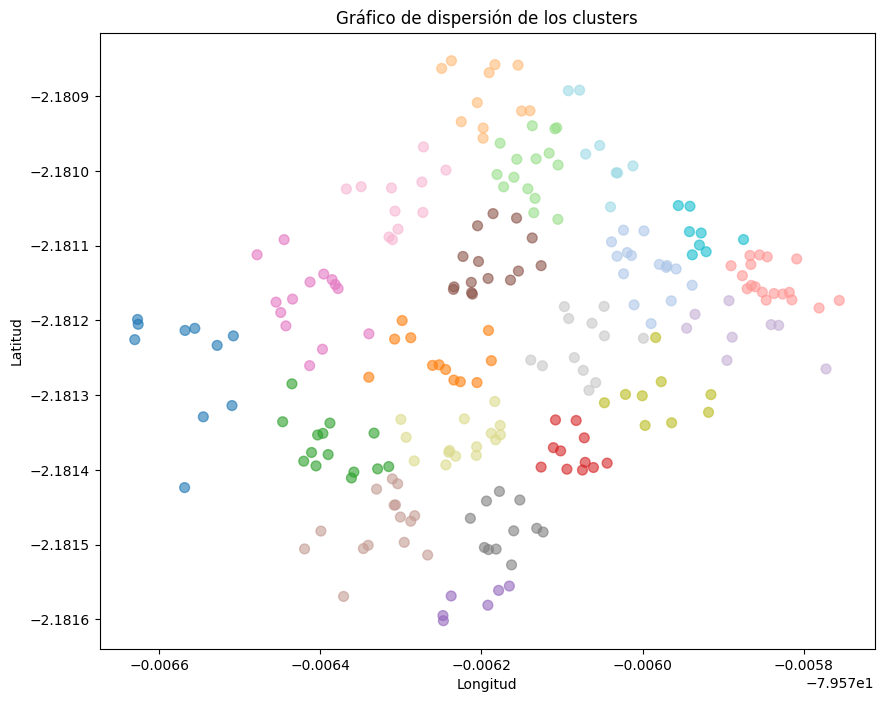

In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd

# Extraer las coordenadas de los puntos y los clústeres (parcelas)
gdf_points['lat'] = gdf_points.geometry.y
gdf_points['lon'] = gdf_points.geometry.x

# Crear el gráfico de dispersión, coloreando los puntos según el cluster
plt.figure(figsize=(10, 8))

# Graficar los puntos coloreados según el clúster
scatter = plt.scatter(gdf_points['lon'], gdf_points['lat'], c=gdf_points['cluster'], cmap='tab20', s=50, alpha=0.6)

# Añadir leyenda con los valores únicos de los clústeres
'''unique_clusters = gdf_points['cluster'].unique()
handles, labels = scatter.legend_elements()
plt.legend(handles, [int(cl) for cl in unique_clusters], title="Clusters")'''

# Añadir títulos y etiquetas
plt.title('Gráfico de dispersión de los clusters')
plt.xlabel('Longitud')
plt.ylabel('Latitud')

# Mostrar el gráfico
plt.show()


El código crea un gráfico de dispersión que visualiza los puntos agrupados por clústeres, donde cada punto es coloreado de acuerdo con su clúster asignado, y los polígonos que representan la envolvente convexa de cada clúster son superpuestos.

### Explicación de los pasos:

1. **Visualización de los puntos**:
   Los puntos se grafican utilizando las coordenadas de latitud y longitud, coloreados según su pertenencia a un clúster. Esto se hace utilizando la columna `'cluster'`, que contiene la asignación de clúster obtenida mediante K-Means.

2. **Añadir los polígonos**:
   Los polígonos representan la envolvente convexa (Convex Hull) de cada grupo de puntos dentro de un clúster. Esto permite visualizar los límites aproximados de las parcelas calculadas.

3. **Leyenda (comentada)**:
   Generar una leyenda con los valores únicos de clústeres. Esto sería útil si quieres que el gráfico tenga una leyenda que identifique claramente cada clúster por su número.

4. **Títulos y etiquetas**:
   Finalmente, se añaden títulos y etiquetas a los ejes para hacer el gráfico más comprensible.

### Resultado esperado:
El gráfico muestra los puntos dispersos agrupados por colores según los clústeres a los que pertenecen, y se dibujan polígonos que representan la envolvente convexa de cada grupo, lo que ayuda a visualizar mejor la distribución espacial de cada parcela.

Este tipo de gráfico es útil para entender la distribución espacial de los datos en cada parcela generada, lo que podría ser especialmente importante si estás analizando biomasa o carbono por región geográfica.

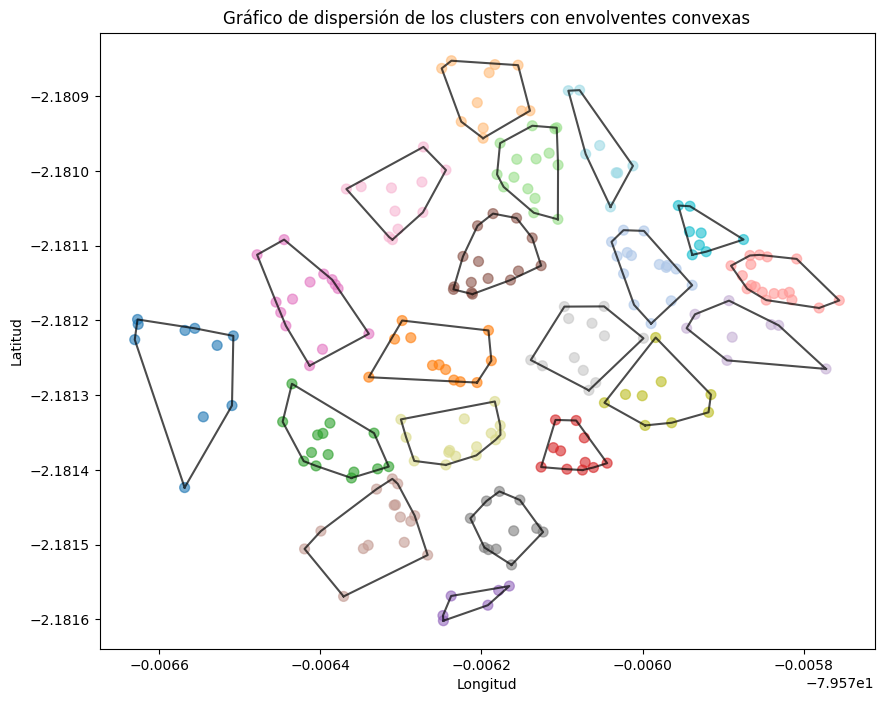

In [ ]:
# Crear el gráfico de dispersión con los clusters y los polígonos
plt.figure(figsize=(10, 8))

# Graficar los puntos coloreados según el clúster
scatter = plt.scatter(gdf_points['lon'], gdf_points['lat'], c=gdf_points['cluster'], cmap='tab20', s=50, alpha=0.6)

# Añadir los polígonos (envolvente convexa de cada clúster)
for _, row in gdf_parcelas.iterrows():
    if row['geometry'].geom_type == 'Polygon':
        x, y = row['geometry'].exterior.xy
        plt.plot(x, y, color='black', alpha=0.7)

# Añadir leyenda con los valores únicos de los clústeres
'''unique_clusters = gdf_points['cluster'].unique()
handles, labels = scatter.legend_elements()
plt.legend(handles, [int(cl) for cl in unique_clusters], title="Clusters")'''

# Añadir títulos y etiquetas
plt.title('Gráfico de dispersión de los clusters con envolventes convexas')
plt.xlabel('Longitud')
plt.ylabel('Latitud')

# Mostrar el gráfico
plt.show()


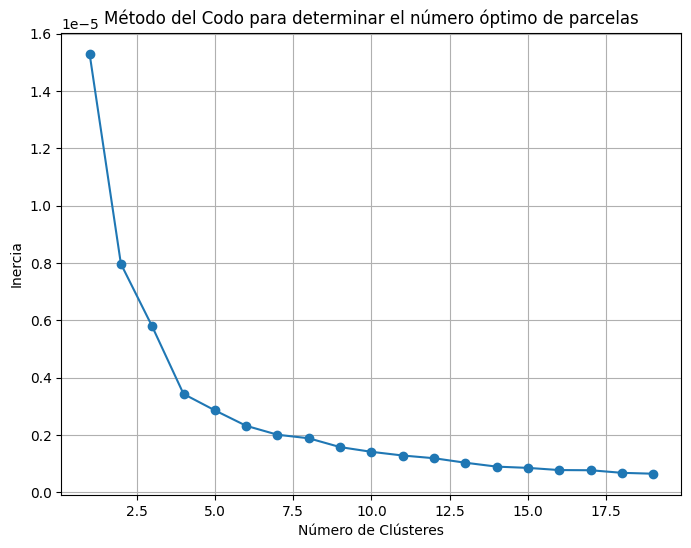

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Extraer las coordenadas en un formato adecuado para KMeans
coords = np.array(list(zip(field_data['lat'], field_data['lon'])))

# Probar con diferentes números de clústeres
inertias = []
range_clusters = range(1, 20)  # Probar con números de clústeres de 1 a 20

for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(coords)
    inertias.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 6))
plt.plot(range_clusters, inertias, marker='o')
plt.title('Método del Codo para determinar el número óptimo de parcelas')
plt.xlabel('Número de Clústeres')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()


In [ ]:
# @title Mostrar parcelas en el mapa
import folium
import geopandas as gpd
from shapely.geometry import MultiPoint, Point

# Asegurarnos de extraer correctamente las coordenadas de los puntos
gdf_points['lat'] = gdf_points.geometry.y
gdf_points['lon'] = gdf_points.geometry.x

# Crear un mapa centrado en las coordenadas promedio
center_lat = gdf_points['lat'].mean()
center_lon = gdf_points['lon'].mean()

# Crear un mapa de Folium con capa satelital
m = folium.Map(location=[center_lat, center_lon], zoom_start=12, tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}', attr='Esri World Imagery')

# Añadir las parcelas (polígonos o líneas) al mapa
for _, row in gdf_parcelas.iterrows():
    geom = row['geometry']

    # Si el objeto es un polígono, extraer sus coordenadas
    if geom.geom_type == 'Polygon':
        hull_coords = list(geom.exterior.coords)
        folium.Polygon(locations=[(lat, lon) for lon, lat in hull_coords], color='blue', fill=True, fill_opacity=0.4).add_to(m)

    # Si es una línea (LineString), añadirla como una línea
    elif geom.geom_type == 'LineString':
        hull_coords = list(geom.coords)
        folium.PolyLine(locations=[(lat, lon) for lon, lat in hull_coords], color='green').add_to(m)

# Añadir los puntos al mapa
for _, row in gdf_points.iterrows():
    folium.Marker(location=[row['lat'], row['lon']], popup=f"Cluster: {row['cluster_id']}").add_to(m)

# Mostrar el mapa
m


In [ ]:
gdf_parcelas

cluster_id  area_hectares      agb_sum  carbon_sum  updated_diameter_mean  \
0            0       0.020627   226.286279   88.251649               9.132365   
1            1       0.008302   243.087021   94.803938              11.072914   
2            2       0.011757   214.541806   83.671304               9.250054   
3            3       0.009600   397.780473  155.134384              14.151601   
4            4       0.011213   188.242361   73.414521               9.904458   
5            5       0.008956   280.762212  109.497263              10.290732   
6            6       0.004431   132.347293   51.615444              11.479539   
7            7       0.007141  1619.233955  631.501242              15.741450   
8            8       0.001990    89.273926   34.816831               9.098755   
9            9       0.010051   454.619142  177.301465              12.487728   
10          10       0.009100   563.447627  219.744574              12.941434   
11          11       0.016243   440.608865  171.837457              10.130275   
12          12       0.014162   340.521340  132.803322              12.338510   
13          13       0.009635   377.434385  147.199410              11.508385   
14          14       0.006434    93.092614   36.306120              10.978400   
15          15       0.011577   577.124747  225.078651              12.288899   
16          16       0.010860   874.486330  341.049669              14.318192   
17          17       0.009080   434.668958  169.520894              11.909148   
18          18       0.003234   335.820750  130.970092              12.369592   
19          19       0.006050    97.606726   38.066623               9.134781   

    height_mean  lat_mean   lon_mean  \
0      0.620000 -2.181257 -79.576566   
1      0.000000 -2.181130 -79.575995   
2      0.666667 -2.181252 -79.576253   
3      0.190909 -2.180898 -79.576194   
4      0.421429 -2.181369 -79.576385   
5      0.280000 -2.180996 -79.576138   
6      0.363636 -2.181377 -79.576086   
7      0.000000 -2.181148 -79.575841   
8      0.400000 -2.181577 -79.576211   
9      0.493750 -2.181216 -79.575875   
10     0.130000 -2.181124 -79.576190   
11     0.260000 -2.181474 -79.576325   
12     0.292857 -2.181172 -79.576415   
13     0.190909 -2.181038 -79.576302   
14     0.345455 -2.181478 -79.576171   
15     0.325000 -2.181235 -79.576074   
16     0.400000 -2.181302 -79.575980   
17     0.146667 -2.181360 -79.576225   
18     0.525000 -2.181084 -79.575929   
19     0.612500 -2.180972 -79.576051   

                                             geometry  Biomasa (Mg/ha)  
0   POLYGON ((-79.57657 -2.18142, -79.57663 -2.181...         1.097030  
1   POLYGON ((-79.57599 -2.1812, -79.57601 -2.1811...         2.928117  
2   POLYGON ((-79.57621 -2.18128, -79.57634 -2.181...         1.824725  
3   POLYGON ((-79.5762 -2.18096, -79.57623 -2.1809...         4.143559  
4   POLYGON ((-79.57636 -2.18141, -79.57641 -2.181...         1.678756  
5   POLYGON ((-79.57611 -2.18106, -79.57614 -2.181...         3.134859  
6   POLYGON ((-79.57607 -2.1814, -79.57609 -2.1814...         2.986752  
7   POLYGON ((-79.57578 -2.18118, -79.57585 -2.181...        22.674925  
8   POLYGON ((-79.57625 -2.1816, -79.57625 -2.1815...         4.486572  
9   POLYGON ((-79.57577 -2.18126, -79.5759 -2.1812...         4.523213  
10  POLYGON ((-79.57621 -2.18116, -79.57623 -2.181...         6.191464  
11  POLYGON ((-79.57637 -2.18157, -79.57642 -2.181...         2.712547  
12  POLYGON ((-79.57641 -2.18126, -79.57644 -2.181...         2.404454  
13  POLYGON ((-79.57631 -2.18109, -79.57631 -2.181...         3.917295  
14  POLYGON ((-79.57616 -2.18153, -79.5762 -2.1815...         1.446824  
15  POLYGON ((-79.57607 -2.18129, -79.57614 -2.181...         4.985135  
16  POLYGON ((-79.576 -2.18134, -79.57605 -2.18131...         8.052370  
17  POLYGON ((-79.57624 -2.18139, -79.57628 -2.181...         4.787300  
18  POLYGON ((-79.57594 -2.18111, -79.57596 -2.181...        10.383034  
1

# Cálculo Sentinel NDVI en coordenadas de parcelas

In [ ]:
# @title Montar acceso Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataframemg = gdf_parcelas.copy(deep=True)
dataframemg

cluster_id  area_hectares      agb_sum  carbon_sum  updated_diameter_mean  \
0            0       0.020627   226.286279   88.251649               9.132365   
1            1       0.008302   243.087021   94.803938              11.072914   
2            2       0.011757   214.541806   83.671304               9.250054   
3            3       0.009600   397.780473  155.134384              14.151601   
4            4       0.011213   188.242361   73.414521               9.904458   
5            5       0.008956   280.762212  109.497263              10.290732   
6            6       0.004431   132.347293   51.615444              11.479539   
7            7       0.007141  1619.233955  631.501242              15.741450   
8            8       0.001990    89.273926   34.816831               9.098755   
9            9       0.010051   454.619142  177.301465              12.487728   
10          10       0.009100   563.447627  219.744574              12.941434   
11          11       0.016243   440.608865  171.837457              10.130275   
12          12       0.014162   340.521340  132.803322              12.338510   
13          13       0.009635   377.434385  147.199410              11.508385   
14          14       0.006434    93.092614   36.306120              10.978400   
15          15       0.011577   577.124747  225.078651              12.288899   
16          16       0.010860   874.486330  341.049669              14.318192   
17          17       0.009080   434.668958  169.520894              11.909148   
18          18       0.003234   335.820750  130.970092              12.369592   
19          19       0.006050    97.606726   38.066623               9.134781   

    height_mean  lat_mean   lon_mean  \
0      0.620000 -2.181257 -79.576566   
1      0.000000 -2.181130 -79.575995   
2      0.666667 -2.181252 -79.576253   
3      0.190909 -2.180898 -79.576194   
4      0.421429 -2.181369 -79.576385   
5      0.280000 -2.180996 -79.576138   
6      0.363636 -2.181377 -79.576086   
7      0.000000 -2.181148 -79.575841   
8      0.400000 -2.181577 -79.576211   
9      0.493750 -2.181216 -79.575875   
10     0.130000 -2.181124 -79.576190   
11     0.260000 -2.181474 -79.576325   
12     0.292857 -2.181172 -79.576415   
13     0.190909 -2.181038 -79.576302   
14     0.345455 -2.181478 -79.576171   
15     0.325000 -2.181235 -79.576074   
16     0.400000 -2.181302 -79.575980   
17     0.146667 -2.181360 -79.576225   
18     0.525000 -2.181084 -79.575929   
19     0.612500 -2.180972 -79.576051   

                                             geometry  Biomasa (Mg/ha)  
0   POLYGON ((-79.57657 -2.18142, -79.57663 -2.181...         1.097030  
1   POLYGON ((-79.57599 -2.1812, -79.57601 -2.1811...         2.928117  
2   POLYGON ((-79.57621 -2.18128, -79.57634 -2.181...         1.824725  
3   POLYGON ((-79.5762 -2.18096, -79.57623 -2.1809...         4.143559  
4   POLYGON ((-79.57636 -2.18141, -79.57641 -2.181...         1.678756  
5   POLYGON ((-79.57611 -2.18106, -79.57614 -2.181...         3.134859  
6   POLYGON ((-79.57607 -2.1814, -79.57609 -2.1814...         2.986752  
7   POLYGON ((-79.57578 -2.18118, -79.57585 -2.181...        22.674925  
8   POLYGON ((-79.57625 -2.1816, -79.57625 -2.1815...         4.486572  
9   POLYGON ((-79.57577 -2.18126, -79.5759 -2.1812...         4.523213  
10  POLYGON ((-79.57621 -2.18116, -79.57623 -2.181...         6.191464  
11  POLYGON ((-79.57637 -2.18157, -79.57642 -2.181...         2.712547  
12  POLYGON ((-79.57641 -2.18126, -79.57644 -2.181...         2.404454  
13  POLYGON ((-79.57631 -2.18109, -79.57631 -2.181...         3.917295  
14  POLYGON ((-79.57616 -2.18153, -79.5762 -2.1815...         1.446824  
15  POLYGON ((-79.57607 -2.18129, -79.57614 -2.181...         4.985135  
16  POLYGON ((-79.576 -2.18134, -79.57605 -2.18131...         8.052370  
17  POLYGON ((-79.57624 -2.18139, -79.57628 -2.181...         4.787300  
18  POLYGON ((-79.57594 -2.18111, -79.57596 -2.181...        10.383034  
1

In [ ]:
dataframemg.columns

Index(['cluster_id', 'area_hectares', 'agb_sum', 'carbon_sum',
       'updated_diameter_mean', 'height_mean', 'lat_mean', 'lon_mean',
       'geometry', 'Biomasa (Mg/ha)', 'NDVI'],
      dtype='object')

In [ ]:
# @title Calculo Sentinel NDVI en coordenadas específicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import rasterio


def process_image(multiband_path, nir_band_idx, red_band_idx, corrections):
    with rasterio.open(multiband_path) as src:
        banda_NIR = src.read(nir_band_idx).astype('float32')
        banda_roja = src.read(red_band_idx).astype('float32')
        transform = src.transform

    mascara = (banda_roja > 0) & (banda_NIR > 0)
    banda_roja_masked = np.ma.array(banda_roja, mask=~mascara)
    banda_NIR_masked = np.ma.array(banda_NIR, mask=~mascara)

    if 'normalization' in corrections:
        banda_NIR_normalized = banda_NIR_masked / banda_NIR_masked.max()
        banda_roja_normalized = banda_roja_masked / banda_roja_masked.max()
    else:
        banda_NIR_normalized = banda_NIR_masked
        banda_roja_normalized = banda_roja_masked

    if 'radiance_conversion' in corrections:
        def convert_to_radiance(dn, gain, bias):
            return gain * dn + bias

        gain_nir = 0.0001
        bias_nir = 0.0
        gain_red = 0.0001
        bias_red = 0.0

        nir_radiance = convert_to_radiance(banda_NIR_normalized, gain_nir, bias_nir)
        red_radiance = convert_to_radiance(banda_roja_normalized, gain_red, bias_red)
    else:
        nir_radiance = banda_NIR_normalized
        red_radiance = banda_roja_normalized

    if 'topographic_correction' in corrections:
        def topographic_correction(LT, z, i, m, b):
            C = m / b
            z_rad = np.deg2rad(z)
            i_rad = np.deg2rad(i)
            return LT * (np.cos(z_rad) + C) / (np.cos(i_rad) + C)

        z = 30  # Ángulo cenital solar en grados
        i = 15  # Ángulo de incidencia solar local en grados
        m = 0.5  # Gradiente de regresión
        b = 0.1  # Intercepto de regresión

        nir_topo_corrected = topographic_correction(nir_radiance, z, i, m, b)
        red_topo_corrected = topographic_correction(red_radiance, z, i, m, b)
    else:
        nir_topo_corrected = nir_radiance
        red_topo_corrected = red_radiance

    ndvi = (nir_topo_corrected - red_topo_corrected) / (nir_topo_corrected + red_topo_corrected)
    ndvi = np.clip(ndvi, -1, 1)

    return ndvi, transform

def get_ndvi_at_coordinates(ndvi, transform, coords):
    ndvi_values = []
    for lat, lon in coords:
        px, py = ~transform * (lon, lat)
        px, py = int(px), int(py)
        if 0 <= px < ndvi.shape[1] and 0 <= py < ndvi.shape[0]:
            ndvi_values.append(ndvi[py, px])
        else:
            ndvi_values.append(np.nan)
    return ndvi_values

# Ruta a la imagen multibanda
multiband_path = '/content/drive/MyDrive/Mapas_landsat/pol_20240924150101_2020_S2_B1_B2_B3_B4_B5_B6_B7_B8_drive.tif'
bandaNir = 8  # Índice de la banda NIR
bandaRoja = 4  # Índice de la banda Roja
corrections = ['normalization', 'radiance_conversion', 'topographic_correction']

# Procesar la imagen y obtener el NDVI
ndvi, transform = process_image(multiband_path, bandaNir, bandaRoja, corrections)

# Leer el DataFrame
# Asegúrate de que 'dataframe' es el DataFrame correcto y ya contiene los datos
dataframemg = dataframemg  # Reemplaza con la ruta a tu archivo CSV

# Extraer coordenadas
coordenadas = dataframemg[['lat_mean', 'lon_mean']].values.tolist()

# Obtener el valor del NDVI para cada subparcela
ndvi_values = get_ndvi_at_coordinates(ndvi, transform, coordenadas)

# Añadir valores del NDVI al DataFrame
dataframemg['NDVI'] = ndvi_values

# Filtrar el DataFrame para asegurarnos de tener las columnas necesarias
dataframemg


cluster_id  area_hectares      agb_sum  carbon_sum  updated_diameter_mean  \
0            0       0.020627   226.286279   88.251649               9.132365   
1            1       0.008302   243.087021   94.803938              11.072914   
2            2       0.011757   214.541806   83.671304               9.250054   
3            3       0.009600   397.780473  155.134384              14.151601   
4            4       0.011213   188.242361   73.414521               9.904458   
5            5       0.008956   280.762212  109.497263              10.290732   
6            6       0.004431   132.347293   51.615444              11.479539   
7            7       0.007141  1619.233955  631.501242              15.741450   
8            8       0.001990    89.273926   34.816831               9.098755   
9            9       0.010051   454.619142  177.301465              12.487728   
10          10       0.009100   563.447627  219.744574              12.941434   
11          11       0.016243   440.608865  171.837457              10.130275   
12          12       0.014162   340.521340  132.803322              12.338510   
13          13       0.009635   377.434385  147.199410              11.508385   
14          14       0.006434    93.092614   36.306120              10.978400   
15          15       0.011577   577.124747  225.078651              12.288899   
16          16       0.010860   874.486330  341.049669              14.318192   
17          17       0.009080   434.668958  169.520894              11.909148   
18          18       0.003234   335.820750  130.970092              12.369592   
19          19       0.006050    97.606726   38.066623               9.134781   

    height_mean  lat_mean   lon_mean  \
0      0.620000 -2.181257 -79.576566   
1      0.000000 -2.181130 -79.575995   
2      0.666667 -2.181252 -79.576253   
3      0.190909 -2.180898 -79.576194   
4      0.421429 -2.181369 -79.576385   
5      0.280000 -2.180996 -79.576138   
6      0.363636 -2.181377 -79.576086   
7      0.000000 -2.181148 -79.575841   
8      0.400000 -2.181577 -79.576211   
9      0.493750 -2.181216 -79.575875   
10     0.130000 -2.181124 -79.576190   
11     0.260000 -2.181474 -79.576325   
12     0.292857 -2.181172 -79.576415   
13     0.190909 -2.181038 -79.576302   
14     0.345455 -2.181478 -79.576171   
15     0.325000 -2.181235 -79.576074   
16     0.400000 -2.181302 -79.575980   
17     0.146667 -2.181360 -79.576225   
18     0.525000 -2.181084 -79.575929   
19     0.612500 -2.180972 -79.576051   

                                             geometry  Biomasa (Mg/ha)  \
0   POLYGON ((-79.57657 -2.18142, -79.57663 -2.181...         1.097030   
1   POLYGON ((-79.57599 -2.1812, -79.57601 -2.1811...         2.928117   
2   POLYGON ((-79.57621 -2.18128, -79.57634 -2.181...         1.824725   
3   POLYGON ((-79.5762 -2.18096, -79.57623 -2.1809...         4.143559   
4   POLYGON ((-79.57636 -2.18141, -79.57641 -2.181...         1.678756   
5   POLYGON ((-79.57611 -2.18106, -79.57614 -2.181...         3.134859   
6   POLYGON ((-79.57607 -2.1814, -79.57609 -2.1814...         2.986752   
7   POLYGON ((-79.57578 -2.18118, -79.57585 -2.181...        22.674925   
8   POLYGON ((-79.57625 -2.1816, -79.57625 -2.1815...         4.486572   
9   POLYGON ((-79.57577 -2.18126, -79.5759 -2.1812...         4.523213   
10  POLYGON ((-79.57621 -2.18116, -79.57623 -2.181...         6.191464   
11  POLYGON ((-79.57637 -2.18157, -79.57642 -2.181...         2.712547   
12  POLYGON ((-79.57641 -2.18126, -79.57644 -2.181...         2.404454   
13  POLYGON ((-79.57631 -2.18109, -79.57631 -2.181...         3.917295   
14  POLYGON ((-79.57616 -2.18153, -79.5762 -2.1815...         1.446824   
15  POLYGON ((-79.57607 -2.18129, -79.57614 -2.181...         4.985135   
16  POLYGON ((-79.576 -2.18134, -79.57605 -2.18131...         8.052370   
17  POLYGON ((-79.57624 -2.18139, -79.57628 -2.181...         4.787300   
18  POLYGON ((-79.57594 -2.18111, -79.57596 -2.181...  

# Modelos ML

Este código realiza una comparación entre tres modelos de regresión — XGBoost, Regresión Lineal y Random Forest — para predecir la biomasa en Mg/ha (toneladas métricas por hectárea).

1. **Preparación de los datos**:
   - Se eliminan valores nulos del dataset.
   - Se crean nuevas características derivadas de las columnas `NDVI`, `updated_diameter_mean`, y `height_mean`.
   - Las características se escalan usando `StandardScaler` para mejorar el rendimiento de los modelos.

2. **Modelos**:
   - **XGBoost**: Se configura una búsqueda en cuadrícula (`GridSearchCV`) para encontrar los mejores parámetros, como la profundidad del árbol y la tasa de aprendizaje. Luego, el modelo se entrena y se evalúa.
   - **Regresión Lineal**: Se entrena un modelo simple de regresión lineal y se evalúa su desempeño.
   - **Random Forest**: Al igual que con XGBoost, se utiliza una búsqueda en cuadrícula para ajustar parámetros como la cantidad de estimadores y la profundidad máxima de los árboles.

3. **Evaluación**:
   - Se calculan dos métricas de rendimiento: el Error Cuadrático Medio (MSE) y el Coeficiente de Determinación (R²) para cada modelo.
   - Se generan gráficos de dispersión que muestran la comparación entre los valores de biomasa observados y predichos para los tres modelos, además de una gráfica comparativa final.

### Interpretación gráfica:
- Los gráficos muestran cómo los valores predichos se comparan con los valores reales de biomasa.
- El objetivo es que las predicciones caigan sobre la línea diagonal (la línea "Ideal"), lo que indicaría que el modelo predice perfectamente la biomasa observada.
- La comparación final entre los tres modelos en un solo gráfico permite identificar cuál se ajusta mejor a los datos reales.

Este enfoque busca identificar cuál de los tres modelos ofrece una mejor capacidad predictiva, basándose en la comparación de sus errores (MSE) y en qué tan bien predicen la biomasa (R²).

Fitting 4 folds for each of 648 candidates, totalling 2592 fits
Fitting 4 folds for each of 108 candidates, totalling 432 fits


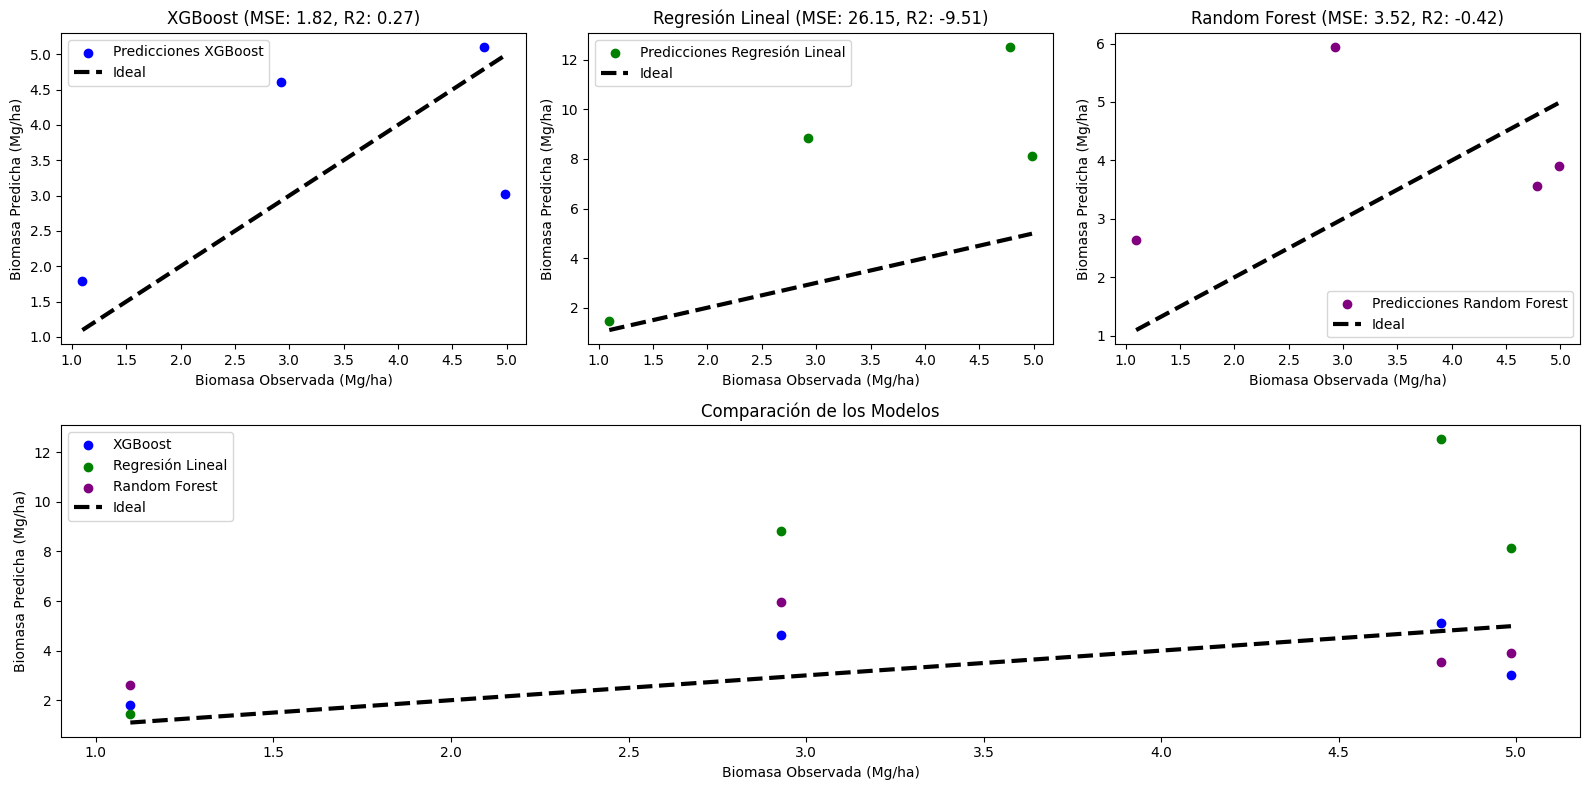

In [ ]:
# @title Comparativo RL - RF - XGBoost
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Cargar los datos y asegurarse de que no haya NaNs
dataframemg = dataframemg.dropna()

# Ingeniería de características
dataframemg['NDVI_DAP'] = dataframemg['NDVI'] / dataframemg['updated_diameter_mean']
dataframemg['HT_NDVI'] = dataframemg['height_mean'] * dataframemg['NDVI']

# Seleccionar características
numeric_features = ['NDVI', 'updated_diameter_mean', 'height_mean', 'NDVI_DAP', 'HT_NDVI']
X = dataframemg[numeric_features]
y = dataframemg['Biomasa (Mg/ha)']

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

### Modelo 1: XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 1, 10]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=4, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search_xgb.fit(X_train, y_train)
best_xgb = grid_search_xgb.best_estimator_

# Predicciones y evaluación
y_pred_xgb = best_xgb.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

### Modelo 2: Regresión Lineal
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

### Modelo 3: Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=4, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_

# Predicciones y evaluación
y_pred_rf = best_rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

### Gráficas de comparación
plt.figure(figsize=(12, 8))

# Gráfico XGBoost
plt.subplot(2, 2, 1)
plt.scatter(y_test, y_pred_xgb, color='blue', label='Predicciones XGBoost')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3, label='Ideal')
plt.xlabel('Biomasa Observada (Mg/ha)')
plt.ylabel('Biomasa Predicha (Mg/ha)')
plt.title(f'XGBoost (MSE: {mse_xgb:.2f}, R2: {r2_xgb:.2f})')
plt.legend()

# Gráfico Regresión Lineal
plt.subplot(2, 2, 2)
plt.scatter(y_test, y_pred_lr, color='green', label='Predicciones Regresión Lineal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3, label='Ideal')
plt.xlabel('Biomasa Observada (Mg/ha)')
plt.ylabel('Biomasa Predicha (Mg/ha)')
plt.title(f'Regresión Lineal (MSE: {mse_lr:.2f}, R2: {r2_lr:.2f})')
plt.legend()

# Gráfico Random Forest
plt.subplot(2, 2, 3)
plt.scatter(y_test, y_pred_rf, color='purple', label='Predicciones Random Forest')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3, label='Ideal')
plt.xlabel('Biomasa Observada (Mg/ha)')
plt.ylabel('Biomasa Predicha (Mg/ha)')
plt.title(f'Random Forest (MSE: {mse_rf:.2f}, R2: {r2_rf:.2f})')
plt.legend()

# Comparación de los tres modelos
plt.subplot(2, 2, 4)
plt.scatter(y_test, y_pred_xgb, color='blue', label='XGBoost')
plt.scatter(y_test, y_pred_lr, color='green', label='Regresión Lineal')
plt.scatter(y_test, y_pred_rf, color='purple', label='Random Forest')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3, label='Ideal')
plt.xlabel('Biomasa Observada (Mg/ha)')
plt.ylabel('Biomasa Predicha (Mg/ha)')
plt.title('Comparación de los Modelos')
plt.legend()

plt.tight_layout()
plt.show()


**Conclusión:**

**XGBoost** es el mejor modelo en esta comparación, con un error menor y un R² positivo, aunque todavía tiene margen para mejorar.
***Regresión Lineal*** y ***Random Forest*** no son adecuados para estos datos, ya que sus R² negativos indican que no logran capturar las relaciones subyacentes entre las características y la biomasa de manera efectiva.

Los gráficos muestran cómo se distribuyen las predicciones frente a los valores observados. Idealmente, todos los puntos deberían caer sobre la línea negra discontinua ("Ideal"), pero como se observa, especialmente en los modelos de Regresión Lineal y Random Forest, hay una gran dispersión.

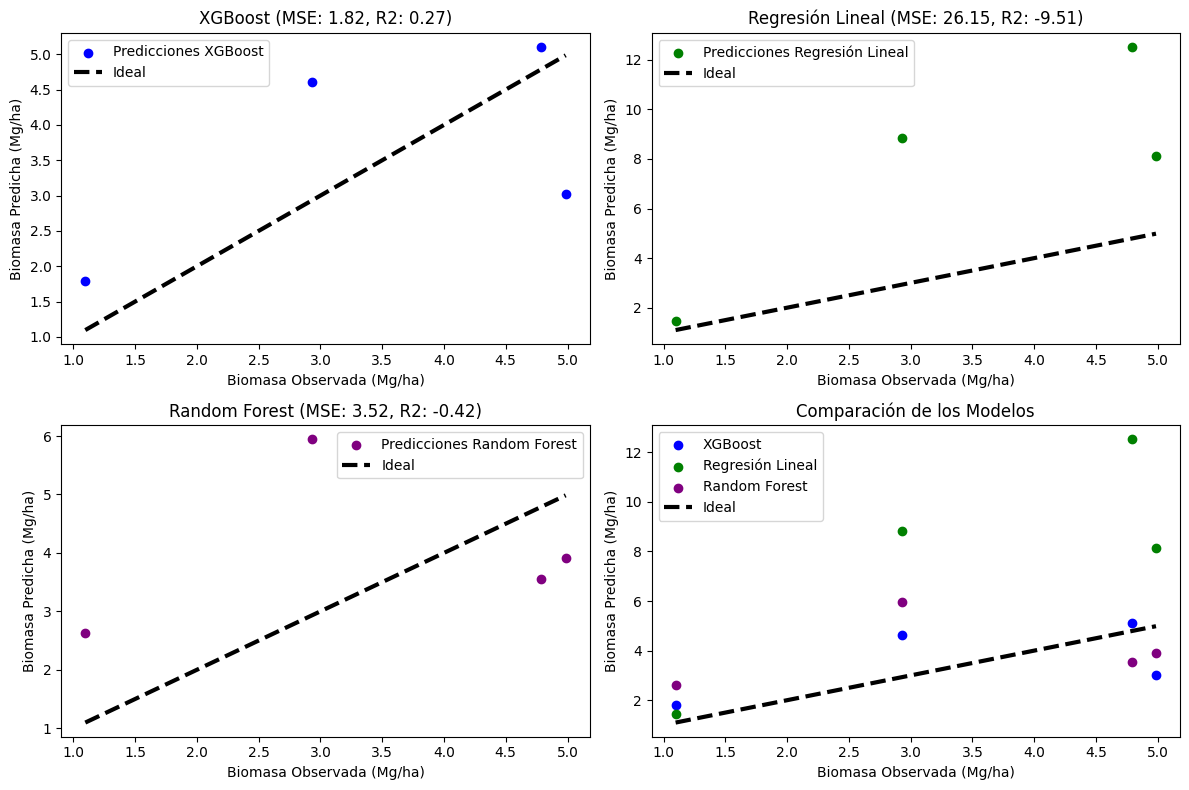

In [ ]:
plt.figure(figsize=(12, 8))

# Gráfico XGBoost
plt.subplot(2, 2, 1)
plt.scatter(y_test, y_pred_xgb, color='blue', label='Predicciones XGBoost')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3, label='Ideal')
plt.xlabel('Biomasa Observada (Mg/ha)')
plt.ylabel('Biomasa Predicha (Mg/ha)')
plt.title(f'XGBoost (MSE: {mse_xgb:.2f}, R2: {r2_xgb:.2f})')
plt.legend()

# Gráfico Regresión Lineal
plt.subplot(2, 2, 2)
plt.scatter(y_test, y_pred_lr, color='green', label='Predicciones Regresión Lineal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3, label='Ideal')
plt.xlabel('Biomasa Observada (Mg/ha)')
plt.ylabel('Biomasa Predicha (Mg/ha)')
plt.title(f'Regresión Lineal (MSE: {mse_lr:.2f}, R2: {r2_lr:.2f})')
plt.legend()

# Gráfico Random Forest
plt.subplot(2, 2, 3)
plt.scatter(y_test, y_pred_rf, color='purple', label='Predicciones Random Forest')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3, label='Ideal')
plt.xlabel('Biomasa Observada (Mg/ha)')
plt.ylabel('Biomasa Predicha (Mg/ha)')
plt.title(f'Random Forest (MSE: {mse_rf:.2f}, R2: {r2_rf:.2f})')
plt.legend()

# Comparación de los tres modelos en la fila inferior
plt.subplot(2, 2, 4)
plt.scatter(y_test, y_pred_xgb, color='blue', label='XGBoost')
plt.scatter(y_test, y_pred_lr, color='green', label='Regresión Lineal')
plt.scatter(y_test, y_pred_rf, color='purple', label='Random Forest')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3, label='Ideal')
plt.xlabel('Biomasa Observada (Mg/ha)')
plt.ylabel('Biomasa Predicha (Mg/ha)')
plt.title('Comparación de los Modelos')
plt.legend()

plt.tight_layout()
plt.show()


Fitting 4 folds for each of 108 candidates, totalling 432 fits
Fitting 4 folds for each of 648 candidates, totalling 2592 fits
Regresión Lineal - MSE: 26.154986018622587, R²: -9.51051075665341
Random Forest - MSE: 3.02771110210819, R²: -0.2167007118294373
XGBoost - MSE: 1.81985153506713, R²: 0.26868364138232426


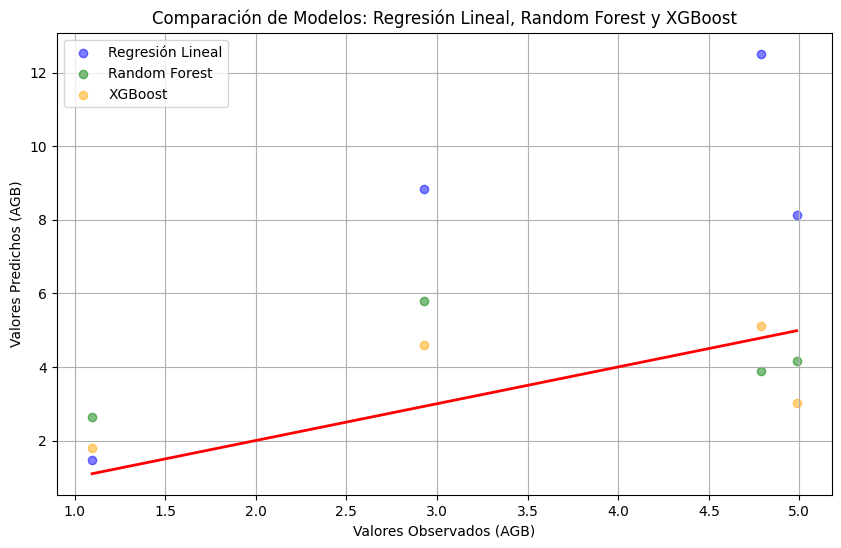

In [ ]:
# @title Comparativo
# Importar las librerías necesarias
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from google.colab import files

# Importar XGBoost

from xgboost import XGBRegressor

# Cargar los datos y asegurarse de que no haya NaNs
dataframemg = dataframemg.dropna()

# Ingeniería de características
dataframemg['NDVI_DAP'] = dataframemg['NDVI'] / dataframemg['updated_diameter_mean']
dataframemg['HT_NDVI'] = dataframemg['height_mean'] * dataframemg['NDVI']

# Seleccionar características
numeric_features = ['NDVI', 'updated_diameter_mean', 'height_mean', 'NDVI_DAP', 'HT_NDVI']
X = dataframemg[numeric_features]
y = dataframemg['Biomasa (Mg/ha)']


# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarizar las características (opcional para los modelos)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. Modelo de Regresión Lineal
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

# 2. Modelo Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=4, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_

# 3. Modelo XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 1, 10]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=4, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search_xgb.fit(X_train, y_train)
best_xgb = grid_search_xgb.best_estimator_

# Predicciones y evaluación
y_pred_xgb = best_xgb.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Evaluar los modelos
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Imprimir los resultados
print(f"Regresión Lineal - MSE: {mse_lr}, R²: {r2_lr}")
print(f"Random Forest - MSE: {mse_rf}, R²: {r2_rf}")
print(f"XGBoost - MSE: {mse_xgb}, R²: {r2_xgb}")

# Gráfico de Observados vs Predichos para los tres modelos
plt.figure(figsize=(10, 6))

# Graficar los valores observados vs predichos para cada modelo
plt.scatter(y_test, y_pred_lr, alpha=0.5, label='Regresión Lineal', color='blue')
plt.scatter(y_test, y_pred_rf, alpha=0.5, label='Random Forest', color='green')
plt.scatter(y_test, y_pred_xgb, alpha=0.5, label='XGBoost', color='orange')

# Línea de referencia para comparar (observados = predichos)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)

# Etiquetas y título del gráfico
plt.xlabel('Valores Observados (AGB)')
plt.ylabel('Valores Predichos (AGB)')
plt.title('Comparación de Modelos: Regresión Lineal, Random Forest y XGBoost')
plt.legend()
plt.grid(True)
plt.show()


# ML Individuales

Mean Squared Error (MSE): 121671.45090298782
R² Score: -4.804732613265647


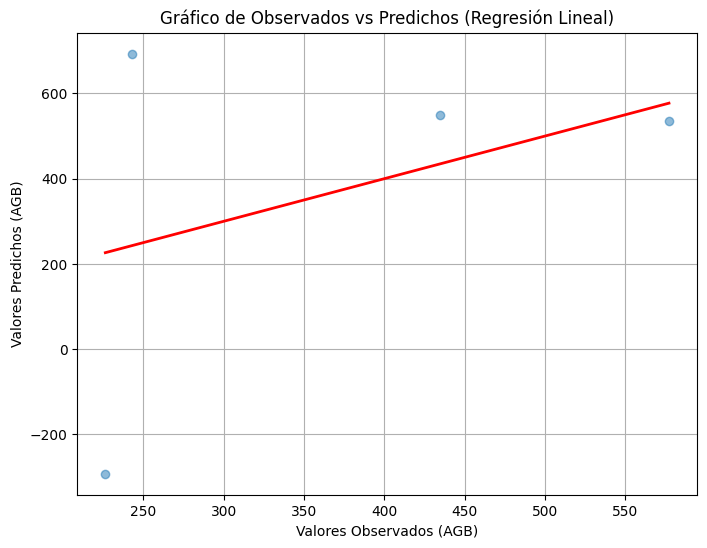

In [ ]:
# @title  Regresion Lineal(parcelas)
# Importar las librerías necesarias
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

#Dataser
gdf_parcelas = gdf_parcelas

# Seleccionar las características y la variable objetivo (AGB)
X = gdf_parcelas[['lat_mean', 'lon_mean', 'updated_diameter_mean', 'height_mean']]
y = gdf_parcelas['agb_sum']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarizar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear el modelo de regresión lineal
model = LinearRegression()

# Entrenar el modelo con los datos de entrenamiento estandarizados
model.fit(X_train_scaled, y_train)

# Hacer predicciones con los datos de prueba
y_pred = model.predict(X_test_scaled)

# Evaluar el rendimiento del modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Imprimir los resultados
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

# Gráfico de valores observados vs predichos
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.xlabel('Valores Observados (AGB)')
plt.ylabel('Valores Predichos (AGB)')
plt.title('Gráfico de Observados vs Predichos (Regresión Lineal)')
plt.grid(True)
plt.show()

Mean Squared Error (MSE): 3602.893628375321
R² Score: -0.3903913665255643


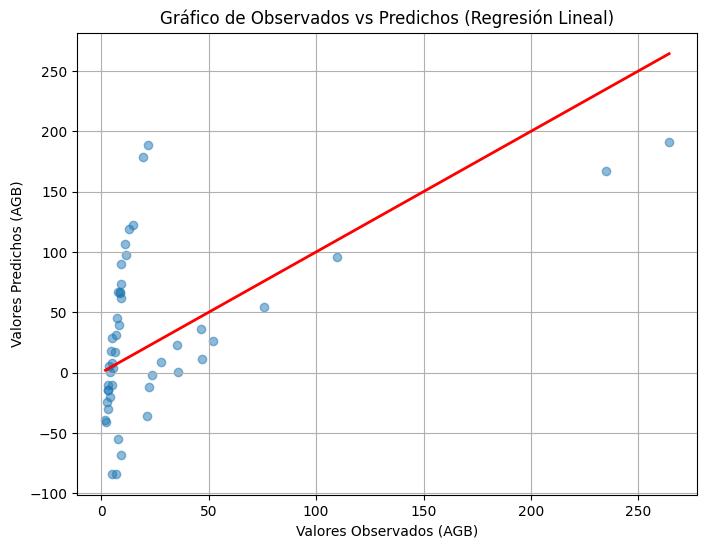

In [ ]:
# @title  Regresion Lineal
# Importar las librerías necesarias
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

#Dataser
field_data = field_data

# Seleccionar las características y la variable objetivo (AGB)
X = field_data[['lat', 'lon', 'updated diameter', 'height', 'year']]
y = field_data['AGB']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarizar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear el modelo de regresión lineal
model = LinearRegression()

# Entrenar el modelo con los datos de entrenamiento estandarizados
model.fit(X_train_scaled, y_train)

# Hacer predicciones con los datos de prueba
y_pred = model.predict(X_test_scaled)

# Evaluar el rendimiento del modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Imprimir los resultados
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

# Gráfico de valores observados vs predichos
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.xlabel('Valores Observados (AGB)')
plt.ylabel('Valores Predichos (AGB)')
plt.title('Gráfico de Observados vs Predichos (Regresión Lineal)')
plt.grid(True)
plt.show()

Mean Squared Error (MSE) con Random Forest: 39776.90810126951
R² Score con Random Forest: -0.897686877215004


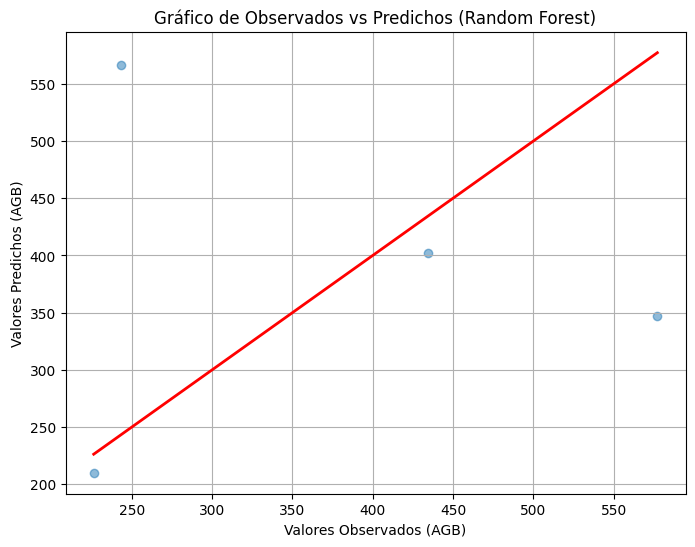

In [ ]:
# @title random Forest(parcelas)
# Importar las librerías necesarias
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from google.colab import files

#Dataser
field_data = gdf_parcelas

# Seleccionar las características y la variable objetivo (AGB)
X = field_data[['lat_mean', 'lon_mean', 'updated_diameter_mean', 'height_mean']]
y = field_data['agb_sum']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarizar las características (opcional para Random Forest, pero lo mantendremos)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear el modelo de Random Forest
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Entrenar el modelo con los datos de entrenamiento estandarizados
model_rf.fit(X_train_scaled, y_train)

# Hacer predicciones con los datos de prueba
y_pred_rf = model_rf.predict(X_test_scaled)

# Evaluar el rendimiento del modelo
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Imprimir los resultados
print(f"Mean Squared Error (MSE) con Random Forest: {mse_rf}")
print(f"R² Score con Random Forest: {r2_rf}")

# Gráfico de valores observados vs predichos
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.xlabel('Valores Observados (AGB)')
plt.ylabel('Valores Predichos (AGB)')
plt.title('Gráfico de Observados vs Predichos (Random Forest)')
plt.grid(True)
plt.show()


Mean Squared Error (MSE) con Random Forest: 2120.874120653415
R² Score con Random Forest: 0.1815342413609501


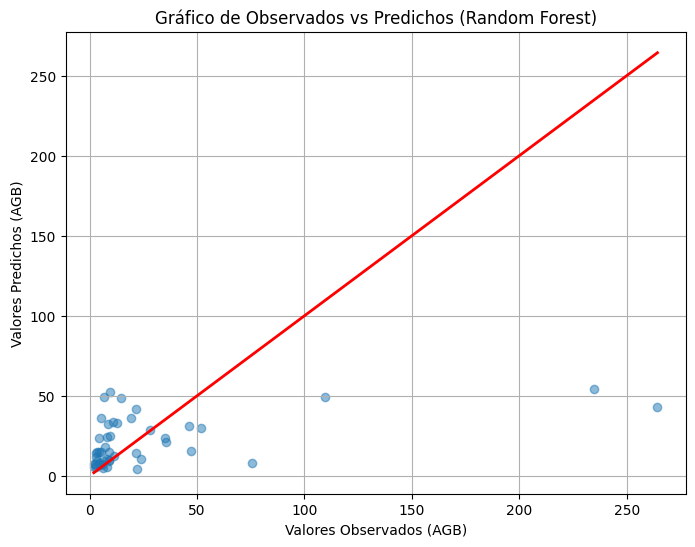

In [ ]:
# @title random Forest
# Importar las librerías necesarias
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from google.colab import files

# dataset
field_data = field_data

# Seleccionar las características y la variable objetivo (AGB)
X = field_data[['lat', 'lon', 'updated diameter', 'height', 'year']]
y = field_data['AGB']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarizar las características (opcional para Random Forest, pero lo mantendremos)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear el modelo de Random Forest
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Entrenar el modelo con los datos de entrenamiento estandarizados
model_rf.fit(X_train_scaled, y_train)

# Hacer predicciones con los datos de prueba
y_pred_rf = model_rf.predict(X_test_scaled)

# Evaluar el rendimiento del modelo
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Imprimir los resultados
print(f"Mean Squared Error (MSE) con Random Forest: {mse_rf}")
print(f"R² Score con Random Forest: {r2_rf}")

# Gráfico de valores observados vs predichos
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.xlabel('Valores Observados (AGB)')
plt.ylabel('Valores Predichos (AGB)')
plt.title('Gráfico de Observados vs Predichos (Random Forest)')
plt.grid(True)
plt.show()


Mean Squared Error (MSE) con XGBoost: 22959.42503671478
R² Score con XGBoost: -0.09535410569492431


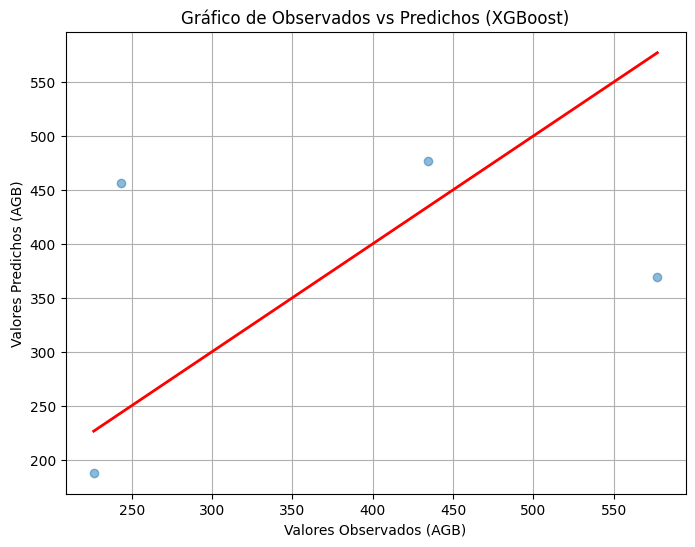

In [ ]:
# @title XGBoost(parcelas)
# Importar las librerías necesarias
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from google.colab import files

# Importar XGBoost
#!pip install xgboost
from xgboost import XGBRegressor

#Dataser
field_data = gdf_parcelas

# Seleccionar las características y la variable objetivo (AGB)
X = field_data[['lat_mean', 'lon_mean', 'updated_diameter_mean', 'height_mean']]
y = field_data['agb_sum']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarizar las características (opcional para XGBoost, pero lo mantendremos)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear el modelo XGBoost
model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Entrenar el modelo con los datos de entrenamiento estandarizados
model_xgb.fit(X_train_scaled, y_train)

# Hacer predicciones con los datos de prueba
y_pred_xgb = model_xgb.predict(X_test_scaled)

# Evaluar el rendimiento del modelo
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Imprimir los resultados
print(f"Mean Squared Error (MSE) con XGBoost: {mse_xgb}")
print(f"R² Score con XGBoost: {r2_xgb}")

# Gráfico de valores observados vs predichos
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.xlabel('Valores Observados (AGB)')
plt.ylabel('Valores Predichos (AGB)')
plt.title('Gráfico de Observados vs Predichos (XGBoost)')
plt.grid(True)
plt.show()


Mean Squared Error (MSE) con XGBoost: 1200.1266659941411
R² Score con XGBoost: 0.536859555887633


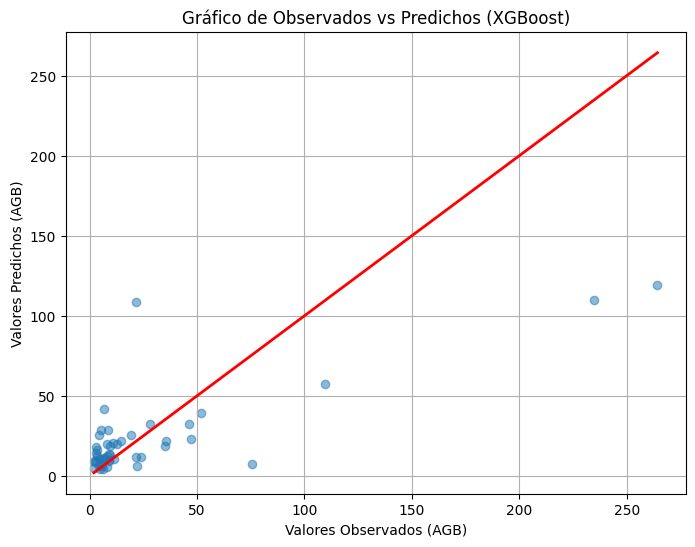

In [ ]:
# @title XGBoost
# Importar las librerías necesarias
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from google.colab import files

# Importar XGBoost
#!pip install xgboost
from xgboost import XGBRegressor

# dataset
field_data = field_data
# Seleccionar las características y la variable objetivo (AGB)
X = field_data[['lat', 'lon', 'updated diameter', 'height', 'year']]
y = field_data['AGB']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarizar las características (opcional para XGBoost, pero lo mantendremos)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear el modelo XGBoost
model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Entrenar el modelo con los datos de entrenamiento estandarizados
model_xgb.fit(X_train_scaled, y_train)

# Hacer predicciones con los datos de prueba
y_pred_xgb = model_xgb.predict(X_test_scaled)

# Evaluar el rendimiento del modelo
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Imprimir los resultados
print(f"Mean Squared Error (MSE) con XGBoost: {mse_xgb}")
print(f"R² Score con XGBoost: {r2_xgb}")

# Gráfico de valores observados vs predichos
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.xlabel('Valores Observados (AGB)')
plt.ylabel('Valores Predichos (AGB)')
plt.title('Gráfico de Observados vs Predichos (XGBoost)')
plt.grid(True)
plt.show()


In [ ]:
!pip install xgboost

Regresión Lineal - MSE: 26.154986018622623, R²: -9.510510756653424
Random Forest - MSE: 3.02771110210819, R²: -0.2167007118294373
XGBoost - MSE: 1.7750694583056954, R²: 0.2866795408705216


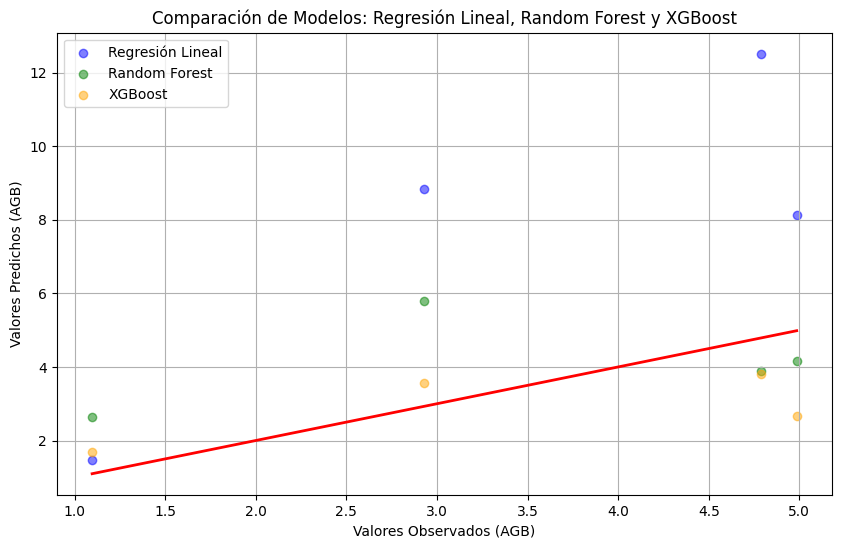

In [ ]:
# Importar las librerías necesarias
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from google.colab import files

# Importar XGBoost

from xgboost import XGBRegressor
'''
# dataset
field_data = field_data

# Seleccionar las características y la variable objetivo (AGB)
X = field_data[['lat', 'lon', 'updated diameter', 'height', 'year']]
y = field_data['AGB']'''


# Cargar los datos y asegurarse de que no haya NaNs
dataframemg = dataframemg.dropna()

# Ingeniería de características
dataframemg['NDVI_DAP'] = dataframemg['NDVI'] / dataframemg['updated_diameter_mean']
dataframemg['HT_NDVI'] = dataframemg['height_mean'] * dataframemg['NDVI']

# Seleccionar características
numeric_features = ['NDVI', 'updated_diameter_mean', 'height_mean', 'NDVI_DAP', 'HT_NDVI']
X = dataframemg[numeric_features]
y = dataframemg['Biomasa (Mg/ha)']

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarizar las características (opcional para los modelos)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. Modelo de Regresión Lineal
model_lr = LinearRegression()
model_lr.fit(X_train_scaled, y_train)
y_pred_lr = model_lr.predict(X_test_scaled)

# 2. Modelo Random Forest
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train_scaled, y_train)
y_pred_rf = model_rf.predict(X_test_scaled)

# 3. Modelo XGBoost
model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model_xgb.fit(X_train_scaled, y_train)
y_pred_xgb = model_xgb.predict(X_test_scaled)

# Evaluar los modelos
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Imprimir los resultados
print(f"Regresión Lineal - MSE: {mse_lr}, R²: {r2_lr}")
print(f"Random Forest - MSE: {mse_rf}, R²: {r2_rf}")
print(f"XGBoost - MSE: {mse_xgb}, R²: {r2_xgb}")

# Gráfico de Observados vs Predichos para los tres modelos
plt.figure(figsize=(10, 6))

# Graficar los valores observados vs predichos para cada modelo
plt.scatter(y_test, y_pred_lr, alpha=0.5, label='Regresión Lineal', color='blue')
plt.scatter(y_test, y_pred_rf, alpha=0.5, label='Random Forest', color='green')
plt.scatter(y_test, y_pred_xgb, alpha=0.5, label='XGBoost', color='orange')

# Línea de referencia para comparar (observados = predichos)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)

# Etiquetas y título del gráfico
plt.xlabel('Valores Observados (AGB)')
plt.ylabel('Valores Predichos (AGB)')
plt.title('Comparación de Modelos: Regresión Lineal, Random Forest y XGBoost')
plt.legend()
plt.grid(True)
plt.show()


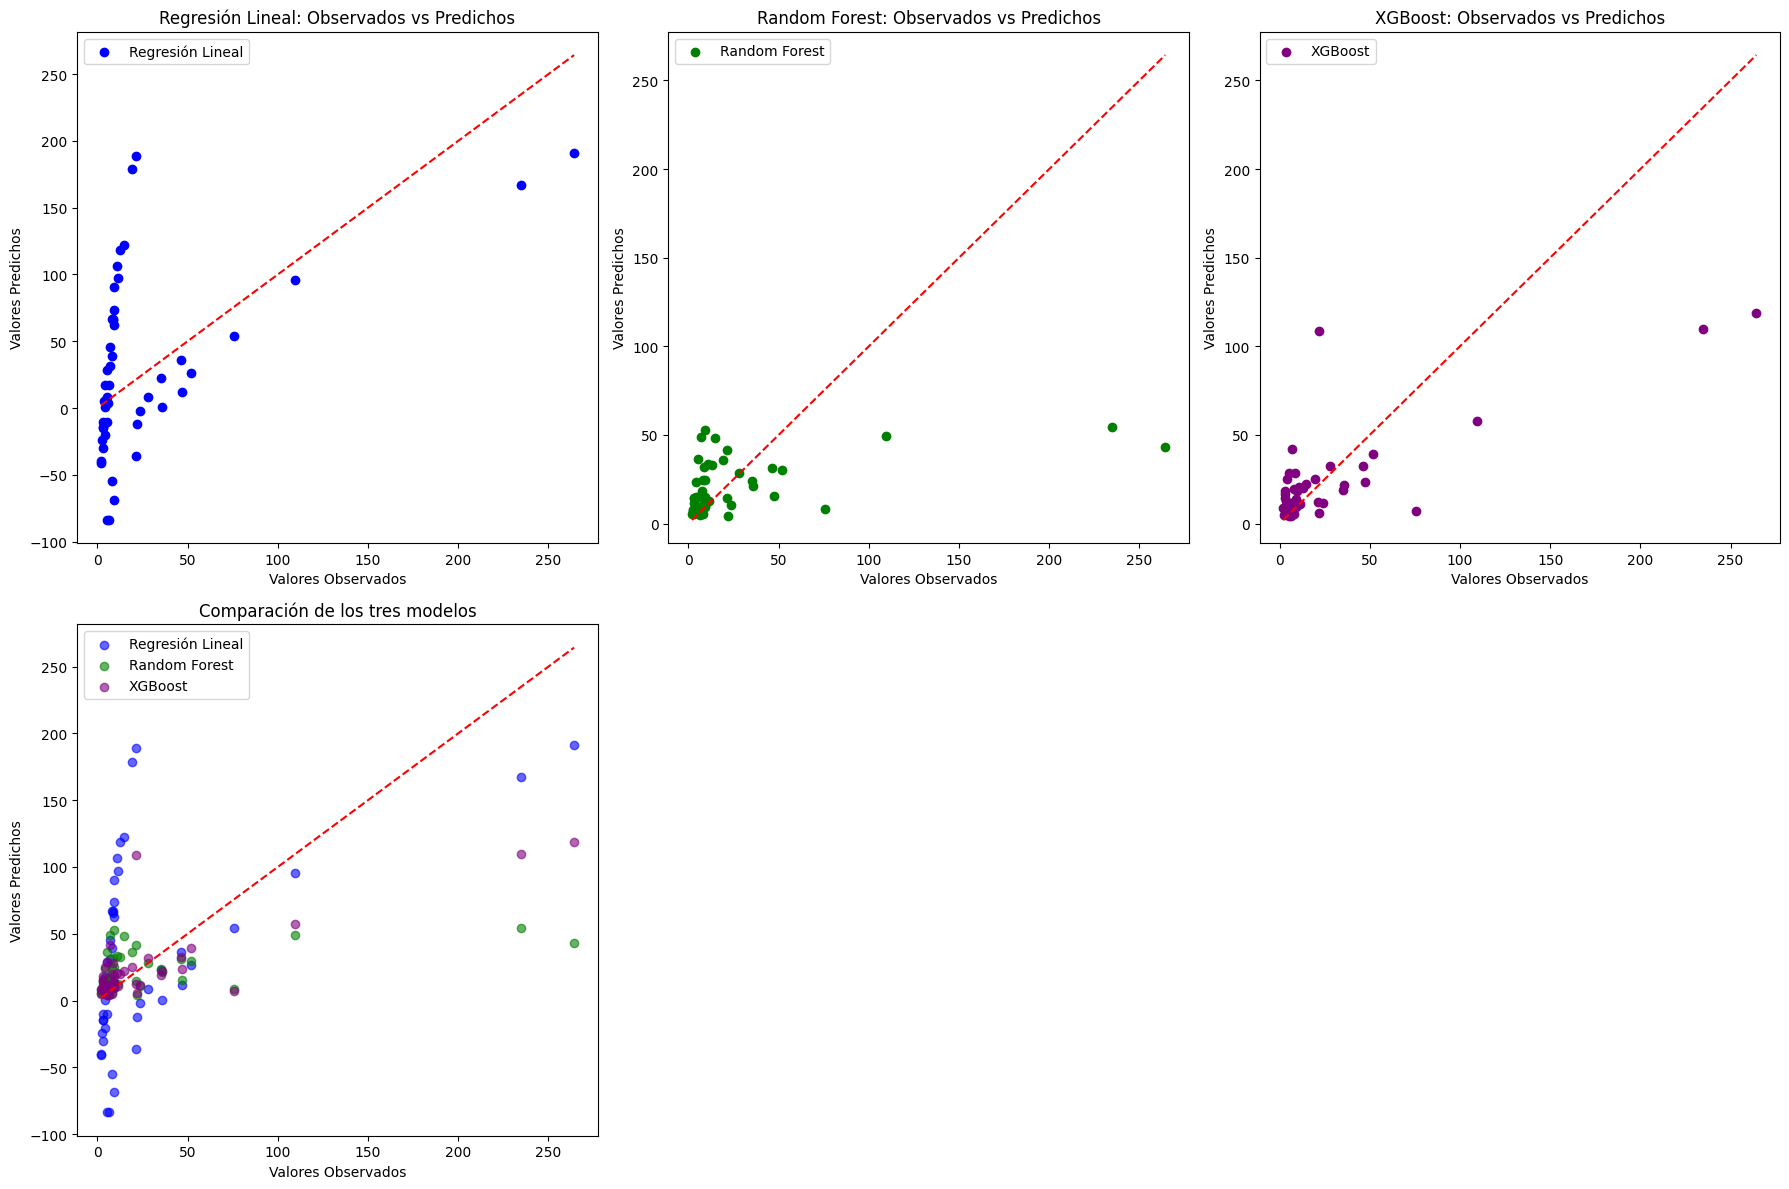

In [ ]:
# Importar las librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Asumimos que 'field_data' ya contiene los datos cargados previamente
# Seleccionar las características para entrenar y predecir
X = field_data[['lat', 'lon', 'updated diameter', 'height', 'year']]
y = field_data['AGB']

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarizar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear los modelos
model_lr = LinearRegression()
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Entrenar los modelos
model_lr.fit(X_train_scaled, y_train)
model_rf.fit(X_train_scaled, y_train)
model_xgb.fit(X_train_scaled, y_train)

# Hacer las predicciones para cada modelo
y_pred_lr = model_lr.predict(X_test_scaled)
y_pred_rf = model_rf.predict(X_test_scaled)
y_pred_xgb = model_xgb.predict(X_test_scaled)

# Crear una figura para los gráficos
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Primera fila: Gráficas de valores predichos vs observados

# Regresión Lineal
axes[0, 0].scatter(y_test, y_pred_lr, c='blue', marker='o', label='Regresión Lineal')
axes[0, 0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
axes[0, 0].set_title('Regresión Lineal: Observados vs Predichos')
axes[0, 0].set_xlabel('Valores Observados')
axes[0, 0].set_ylabel('Valores Predichos')
axes[0, 0].legend()

# Random Forest
axes[0, 1].scatter(y_test, y_pred_rf, c='green', marker='o', label='Random Forest')
axes[0, 1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
axes[0, 1].set_title('Random Forest: Observados vs Predichos')
axes[0, 1].set_xlabel('Valores Observados')
axes[0, 1].set_ylabel('Valores Predichos')
axes[0, 1].legend()

# XGBoost
axes[0, 2].scatter(y_test, y_pred_xgb, c='purple', marker='o', label='XGBoost')
axes[0, 2].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
axes[0, 2].set_title('XGBoost: Observados vs Predichos')
axes[0, 2].set_xlabel('Valores Observados')
axes[0, 2].set_ylabel('Valores Predichos')
axes[0, 2].legend()

# Segunda fila: Comparación de los tres modelos en una gráfica

# Gráfica de comparación de los tres modelos
axes[1, 0].scatter(y_test, y_pred_lr, c='blue', marker='o', label='Regresión Lineal', alpha=0.6)
axes[1, 0].scatter(y_test, y_pred_rf, c='green', marker='o', label='Random Forest', alpha=0.6)
axes[1, 0].scatter(y_test, y_pred_xgb, c='purple', marker='o', label='XGBoost', alpha=0.6)
axes[1, 0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
axes[1, 0].set_title('Comparación de los tres modelos')
axes[1, 0].set_xlabel('Valores Observados')
axes[1, 0].set_ylabel('Valores Predichos')
axes[1, 0].legend()

# Ocultar las subplots vacías en la segunda fila
axes[1, 1].axis('off')
axes[1, 2].axis('off')

# Ajustar el diseño de la gráfica
plt.tight_layout()
plt.show()


In [ ]:
# Importar XGBoost
!pip install xgboost geopandas shapely

# Polígonos Parcelas


<ipython-input-146-32c5d08c2782>:10: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  convex_hull_polygon = gdf_points.unary_union.convex_hull


Coordenadas del polígono generado:
[[-79.57624719, -2.18160185], [-79.57637103, -2.18156934], [-79.57656828, -2.18142366], [-79.57663014, -2.18122567], [-79.57662668, -2.18119865], [-79.57624931, -2.18086266], [-79.57623722, -2.18085237], [-79.57615457, -2.18085832], [-79.57607819, -2.18089176], [-79.57580881, -2.18111763], [-79.57575595, -2.18117321], [-79.57577244, -2.18126487], [-79.57619201, -2.18158109], [-79.57624719, -2.18160185]]


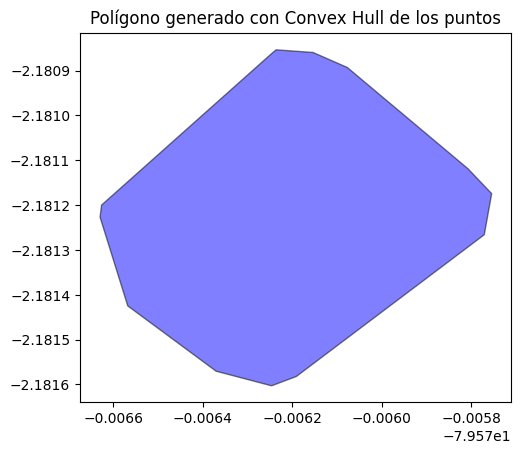

In [ ]:
# Importar las librerías necesarias
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

# Crear un GeoDataFrame para los puntos del dataset (field_data)
gdf_points = gpd.GeoDataFrame(field_data, geometry=gpd.points_from_xy(field_data['lon'], field_data['lat']), crs="EPSG:4326")

# Generar el polígono usando la envolvente convexa (convex hull) de todos los puntos
convex_hull_polygon = gdf_points.unary_union.convex_hull

# Obtener las coordenadas del polígono generado (Convex Hull)
hull_coords = list(convex_hull_polygon.exterior.coords)

# Formatear las coordenadas en el formato deseado: [[lon, lat], [lon, lat], ...]
formatted_coords = [[lon, lat] for lon, lat in hull_coords]

# Mostrar las coordenadas formateadas en el formato de corchetes
print("Coordenadas del polígono generado:")
print(formatted_coords)

# Graficar el polígono generado
gdf_polygon = gpd.GeoDataFrame(geometry=[convex_hull_polygon], crs="EPSG:4326")
gdf_polygon.plot(color='blue', alpha=0.5, edgecolor='k')
plt.title('Polígono generado con Convex Hull de los puntos')
plt.show()


In [ ]:
dataframemg.columns

Index(['cluster_id', 'area_hectares', 'agb_sum', 'carbon_sum',
       'updated_diameter_mean', 'height_mean', 'lat_mean', 'lon_mean',
       'geometry', 'Biomasa (Mg/ha)', 'NDVI', 'NDVI_DAP', 'HT_NDVI'],
      dtype='object')

<ipython-input-188-172f3b6c8538>:15: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  convex_hull_polygon = gdf_points.unary_union.convex_hull


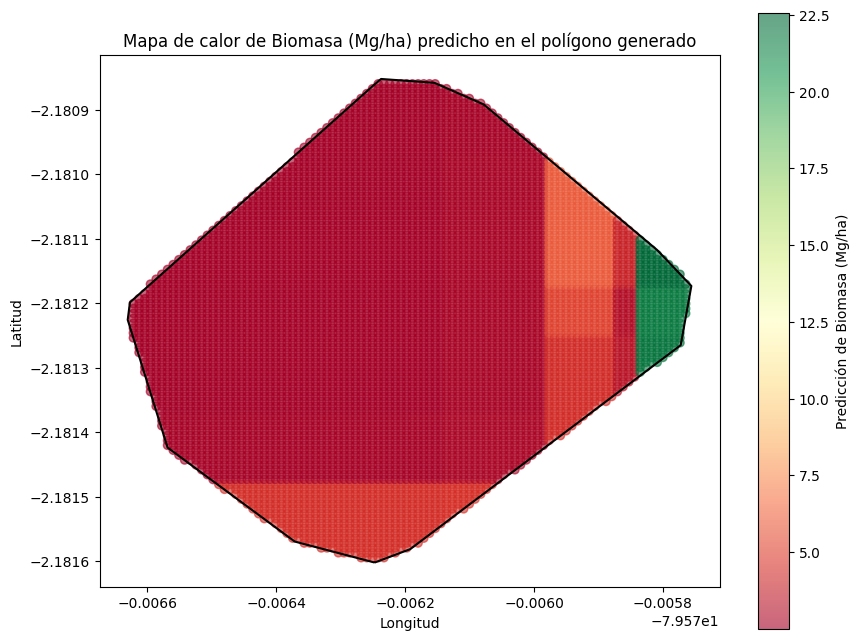

In [ ]:
# @title Poligono lineal

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from shapely.geometry import Point, Polygon

# Parte 1: Generar el polígono usando los datos anteriores (convex hull)

# Crear un GeoDataFrame para los puntos del dataset (dataframemg)
gdf_points = gpd.GeoDataFrame(dataframemg, geometry=dataframemg['geometry'], crs="EPSG:4326")

# Generar el polígono usando la envolvente convexa (convex hull) de todos los puntos
convex_hull_polygon = gdf_points.unary_union.convex_hull

# Parte 2: Seleccionar características para predecir la Biomasa (Mg/ha)

# Usar los nombres de columnas exactos
X = dataframemg[['lat_mean', 'lon_mean', 'updated_diameter_mean', 'height_mean', 'NDVI', 'NDVI_DAP', 'HT_NDVI']]
y = dataframemg['Biomasa (Mg/ha)']

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarizar las características
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Crear el modelo XGBoost
model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Entrenar el modelo
model_xgb.fit(X_train_scaled, y_train)

# Parte 3: Crear una cuadrícula de puntos dentro del polígono generado

# Obtener los límites del polígono generado
minx, miny, maxx, maxy = convex_hull_polygon.bounds
x_values = np.linspace(minx, maxx, 100)  # 100 puntos a lo largo del eje x
y_values = np.linspace(miny, maxy, 100)  # 100 puntos a lo largo del eje y
grid_points = np.array([[x, y] for x in x_values for y in y_values])

# Filtrar los puntos que están dentro del polígono
grid_points_in_polygon = np.array([point for point in grid_points if Point(point).within(convex_hull_polygon)])

# Crear un DataFrame de los puntos dentro del polígono
grid_df = pd.DataFrame(grid_points_in_polygon, columns=['lon_mean', 'lat_mean'])  # Usar 'lat' y 'lon' como coordenadas

# Parte 4: Crear las características para predecir Biomasa (Mg/ha)

# Usar los valores promedio de las características
grid_df['updated_diameter_mean'] = X['updated_diameter_mean'].mean()
grid_df['height_mean'] = X['height_mean'].mean()
grid_df['NDVI'] = X['NDVI'].mean()
grid_df['NDVI_DAP'] = X['NDVI_DAP'].mean()
grid_df['HT_NDVI'] = X['HT_NDVI'].mean()

# Estandarizar las características para el grid
grid_scaled = scaler.transform(grid_df[['lat_mean', 'lon_mean', 'updated_diameter_mean', 'height_mean', 'NDVI', 'NDVI_DAP', 'HT_NDVI']])

# Predecir los valores de Biomasa (Mg/ha) para cada punto en la cuadrícula
grid_df['predicted_biomass'] = model_xgb.predict(grid_scaled)

# Parte 5: Graficar el polígono con las predicciones

fig, ax = plt.subplots(figsize=(10, 8))

# Graficar el polígono generado
gdf_polygon = gpd.GeoDataFrame(geometry=[convex_hull_polygon], crs="EPSG:4326")
gdf_polygon.boundary.plot(ax=ax, color='black')

# Crear un mapa de calor con los valores de Biomasa (Mg/ha) predichos
sc = ax.scatter(grid_df['lon_mean'], grid_df['lat_mean'], c=grid_df['predicted_biomass'], cmap='RdYlGn', marker='o', alpha=0.6)

# Añadir la barra de colores (para mostrar los valores de Biomasa (Mg/ha))
plt.colorbar(sc, label='Predicción de Biomasa (Mg/ha)')

# Añadir etiquetas y título
plt.title('Mapa de calor de Biomasa (Mg/ha) predicho en el polígono generado')
plt.xlabel('Longitud')
plt.ylabel('Latitud')

# Mostrar el gráfico
plt.show()


In [ ]:
print(dataframemg.columns)


Index(['cluster_id', 'area_hectares', 'agb_sum', 'carbon_sum',
       'updated_diameter_mean', 'height_mean', 'lat_mean', 'lon_mean',
       'geometry', 'Biomasa (Mg/ha)', 'NDVI', 'NDVI_DAP', 'HT_NDVI'],
      dtype='object')


<ipython-input-189-49563b15d590>:19: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  convex_hull_polygon = gdf_points.unary_union.convex_hull


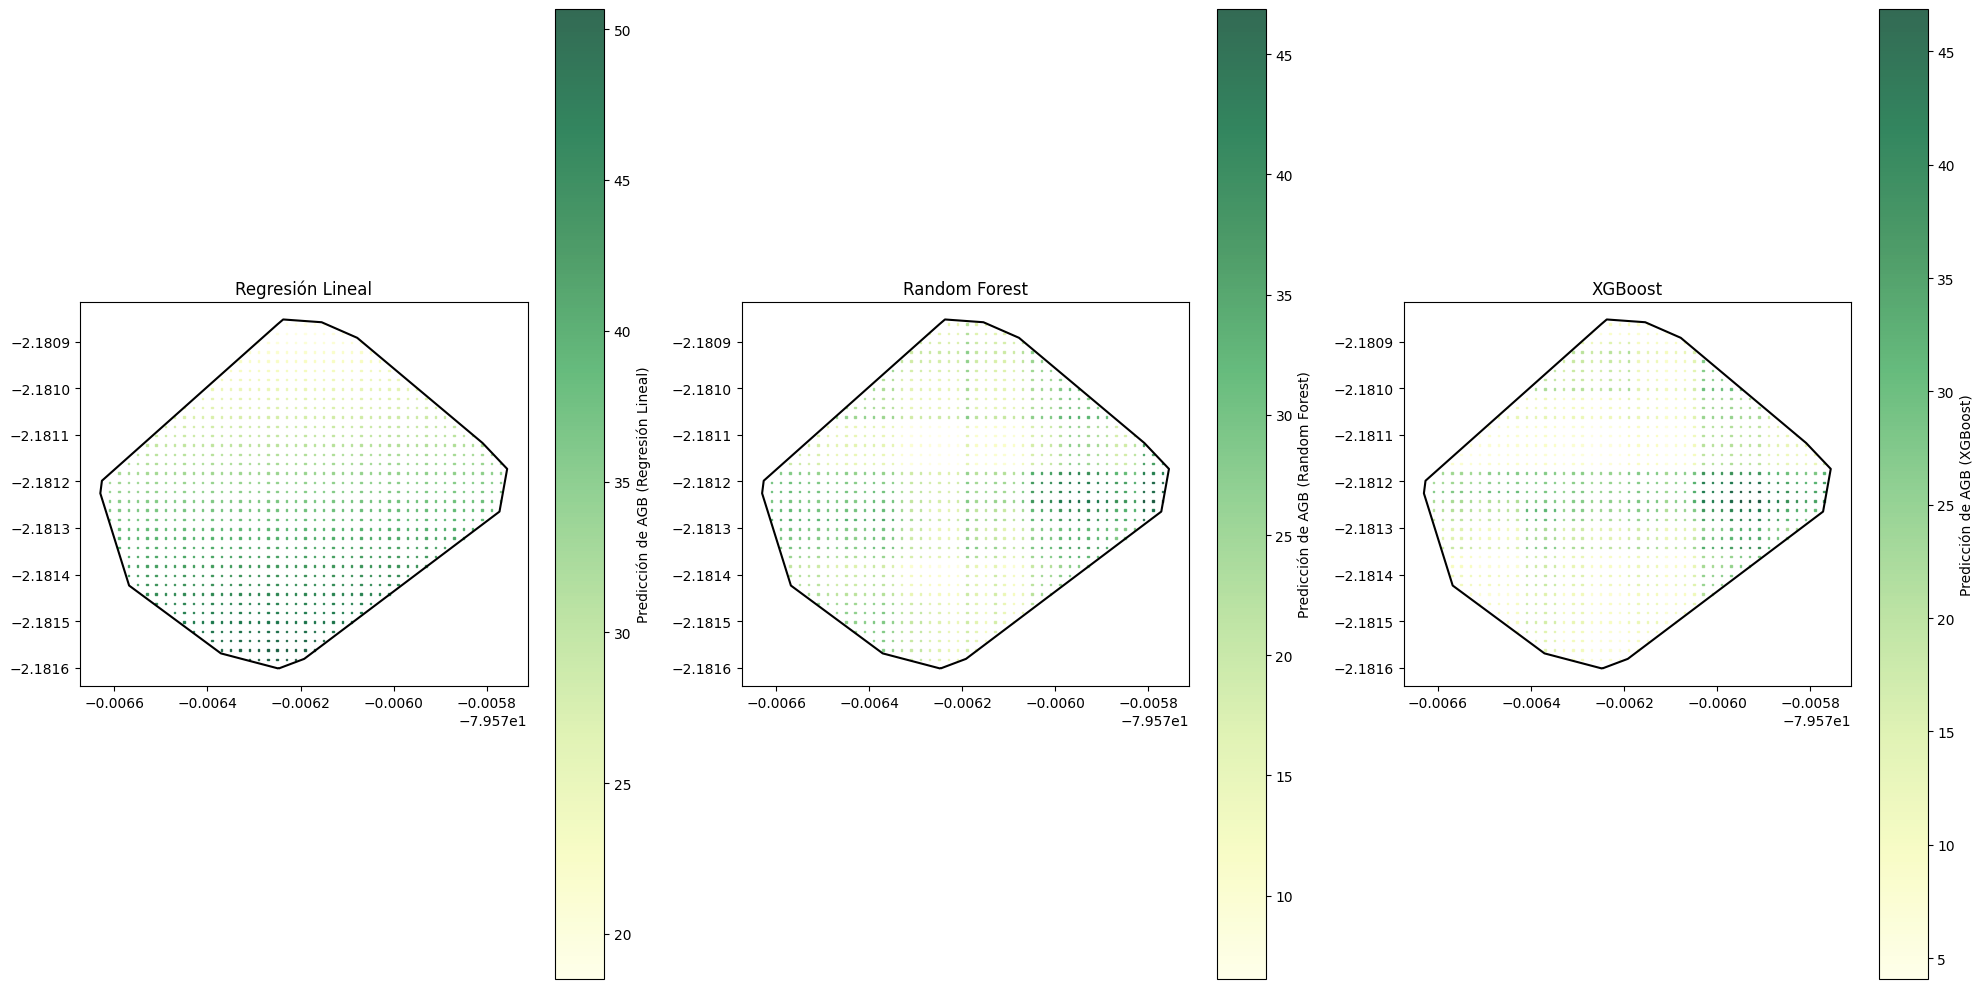

In [ ]:
# Importar las librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Parte 1: Generar el polígono usando los datos del dataset (convex hull)

# Crear un GeoDataFrame para los puntos del dataset (field_data)
gdf_points = gpd.GeoDataFrame(field_data, geometry=gpd.points_from_xy(field_data['lon'], field_data['lat']), crs="EPSG:4326")

# Generar el polígono usando la envolvente convexa (convex hull) de todos los puntos
convex_hull_polygon = gdf_points.unary_union.convex_hull

# Parte 2: Ahora cargamos los datos para hacer las predicciones de AGB

# Seleccionar las características y la variable objetivo (AGB)
X = field_data[['lat', 'lon', 'updated diameter', 'height', 'year']]
y = field_data['AGB']

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarizar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Crear los tres modelos
model_lr = LinearRegression()
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Entrenar los tres modelos
model_lr.fit(X_train_scaled, y_train)
model_rf.fit(X_train_scaled, y_train)
model_xgb.fit(X_train_scaled, y_train)

# Parte 3: Crear una cuadrícula de puntos (píxeles) dentro del polígono generado

# Obtener los límites del polígono generado
minx, miny, maxx, maxy = convex_hull_polygon.bounds
pixel_size = 0.00002  # Reducimos el tamaño de los píxeles para que haya más puntos dentro del polígono

# Crear una cuadrícula de puntos
x_values = np.arange(minx, maxx, pixel_size)
y_values = np.arange(miny, maxy, pixel_size)
grid_points = np.array([[x, y] for x in x_values for y in y_values])

# Filtrar los puntos que están dentro del polígono
grid_points_in_polygon = np.array([point for point in grid_points if Point(point).within(convex_hull_polygon)])

# Crear un DataFrame de los puntos dentro del polígono
grid_df = pd.DataFrame(grid_points_in_polygon, columns=['lon', 'lat'])

# Parte 4: Crear las características para predecir (rellenamos las otras columnas con valores promedio para las predicciones)
grid_df['updated diameter'] = X['updated diameter'].mean()
grid_df['height'] = X['height'].mean()
grid_df['year'] = X['year'].mean()

# Estandarizar las características de la cuadrícula
grid_scaled = scaler.transform(grid_df[['lat', 'lon', 'updated diameter', 'height', 'year']])

# Parte 5: Predecir los valores de AGB para cada punto en la cuadrícula usando los tres modelos
grid_df['predicted_agb_lr'] = model_lr.predict(grid_scaled)
grid_df['predicted_agb_rf'] = model_rf.predict(grid_scaled)
grid_df['predicted_agb_xgb'] = model_xgb.predict(grid_scaled)

# Convertir los puntos a un GeoDataFrame para facilitar la visualización
gdf_grid_points = gpd.GeoDataFrame(grid_df, geometry=gpd.points_from_xy(grid_df['lon'], grid_df['lat']))

# Parte 6: Crear una figura para mostrar las tres gráficas
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

# Graficar las predicciones de Regresión Lineal
gdf_polygon = gpd.GeoDataFrame(geometry=[convex_hull_polygon], crs="EPSG:4326")
gdf_polygon.boundary.plot(ax=axes[0], color='black')
sc1 = axes[0].scatter(gdf_grid_points['lon'], gdf_grid_points['lat'], c=gdf_grid_points['predicted_agb_lr'], cmap='YlGn', marker='s', s=1, alpha=0.8)
axes[0].set_title('Regresión Lineal')
plt.colorbar(sc1, ax=axes[0], label='Predicción de AGB (Regresión Lineal)')

# Graficar las predicciones de Random Forest
gdf_polygon.boundary.plot(ax=axes[1], color='black')
sc2 = axes[1].scatter(gdf_grid_points['lon'], gdf_grid_points['lat'], c=gdf_grid_points['predicted_agb_rf'], cmap='YlGn', marker='s', s=1, alpha=0.8)
axes[1].set_title('Random Forest')
plt.colorbar(sc2, ax=axes[1], label='Predicción de AGB (Random Forest)')

# Graficar las predicciones de XGBoost
gdf_polygon.boundary.plot(ax=axes[2], color='black')
sc3 = axes[2].scatter(gdf_grid_points['lon'], gdf_grid_points['lat'], c=gdf_grid_points['predicted_agb_xgb'], cmap='YlGn', marker='s', s=1, alpha=0.8)
axes[2].set_title('XGBoost')
plt.colorbar(sc3, ax=axes[2], label='Predicción de AGB (XGBoost)')

# Mostrar las tres gráficas juntas
plt.tight_layout()
plt.show()


<ipython-input-208-ec5bd26a99ab>:20: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  convex_hull_polygon = gdf_points.unary_union.convex_hull


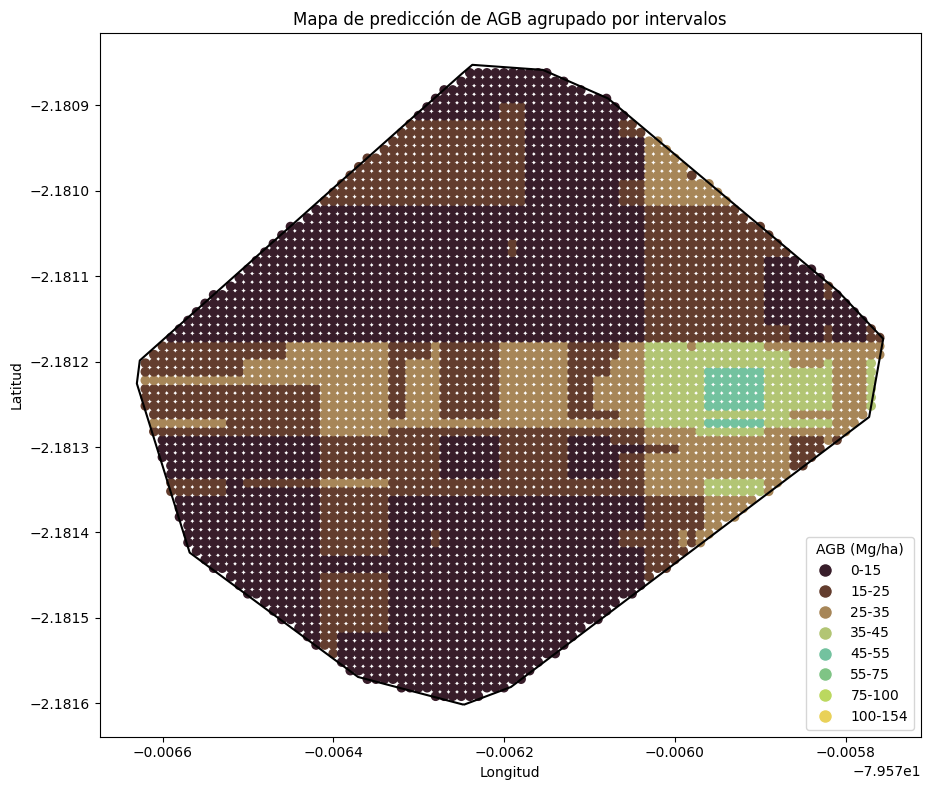

In [ ]:
# Importar las librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

# Parte 1: Generar el polígono usando los datos del dataset (convex hull)

# Crear un GeoDataFrame para los puntos del dataset (field_data)
gdf_points = gpd.GeoDataFrame(field_data, geometry=gpd.points_from_xy(field_data['lon'], field_data['lat']), crs="EPSG:4326")

# Generar el polígono usando la envolvente convexa (convex hull) de todos los puntos
convex_hull_polygon = gdf_points.unary_union.convex_hull

# Parte 2: Ahora cargamos los datos para hacer las predicciones de AGB

# Seleccionar las características y la variable objetivo (AGB)
X = field_data[['lat', 'lon', 'updated diameter', 'height', 'year']]
y = field_data['AGB']

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarizar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Crear los tres modelos
model_lr = LinearRegression()
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Entrenar los tres modelos
model_lr.fit(X_train_scaled, y_train)
model_rf.fit(X_train_scaled, y_train)
model_xgb.fit(X_train_scaled, y_train)

# Parte 3: Crear una cuadrícula de puntos (píxeles) dentro del polígono generado

# Obtener los límites del polígono generado
minx, miny, maxx, maxy = convex_hull_polygon.bounds
pixel_size = 0.00001  # Reducimos el tamaño de los píxeles para que cubra todo el polígono

# Crear una cuadrícula de puntos
x_values = np.arange(minx, maxx, pixel_size)
y_values = np.arange(miny, maxy, pixel_size)
grid_points = np.array([[x, y] for x in x_values for y in y_values])

# Filtrar los puntos que están dentro del polígono
grid_points_in_polygon = np.array([point for point in grid_points if Point(point).within(convex_hull_polygon)])

# Crear un DataFrame de los puntos dentro del polígono
grid_df = pd.DataFrame(grid_points_in_polygon, columns=['lon', 'lat'])

# Parte 4: Crear las características para predecir (rellenamos las otras columnas con valores promedio para las predicciones)
grid_df['updated diameter'] = X['updated diameter'].mean()
grid_df['height'] = X['height'].mean()
grid_df['year'] = X['year'].mean()

# Estandarizar las características de la cuadrícula
grid_scaled = scaler.transform(grid_df[['lat', 'lon', 'updated diameter', 'height', 'year']])

# Parte 5: Predecir los valores de AGB para cada punto en la cuadrícula usando el modelo XGBoost (como ejemplo)
grid_df['predicted_agb'] = model_xgb.predict(grid_scaled)

# Parte 6: Agrupar los valores de AGB en intervalos
bins = [0, 15, 25, 35, 45, 55, 75, 100, 154]  # Definir los intervalos de AGB
labels = ['0-15', '15-25', '25-35', '35-45', '45-55', '55-75', '75-100', '100-154']  # Etiquetas para los intervalos
grid_df['agb_group'] = pd.cut(grid_df['predicted_agb'], bins=bins, labels=labels)

# Parte 7: Crear un colormap personalizado para los intervalos
colors = ['#381d2a', '#633d2e', '#a78658', '#b2c574', '#73c29f', '#7fc485', '#bbd85f', '#e9d159']
cmap = ListedColormap(colors)

# Convertir los puntos a un GeoDataFrame para facilitar la visualización
gdf_grid_points = gpd.GeoDataFrame(grid_df, geometry=gpd.points_from_xy(grid_df['lon'], grid_df['lat']))

# Parte 8: Graficar el polígono con los grupos de AGB y agregar la leyenda
fig, ax = plt.subplots(figsize=(10, 8))

# Graficar el polígono generado
gdf_polygon = gpd.GeoDataFrame(geometry=[convex_hull_polygon], crs="EPSG:4326")
gdf_polygon.boundary.plot(ax=ax, color='black')

# Graficar los puntos con los grupos de AGB
gdf_grid_points.plot(ax=ax, column='agb_group', cmap=cmap, legend=True, legend_kwds={'loc': 'lower right', 'title': 'Predicted AGB (Mg/ha)'})

# Añadir etiquetas y título
plt.title('Mapa de predicción de AGB agrupado por intervalos')
plt.xlabel('Longitud')
plt.ylabel('Latitud')

# Personalizar la leyenda manualmente
handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markersize=10, markerfacecolor=color) for label, color in zip(labels, colors)]
plt.legend(handles=handles, title='AGB (Mg/ha)', loc='lower right')

# Mostrar el gráfico
plt.tight_layout()
plt.show()


Este código tiene como objetivo predecir y visualizar los valores de biomasa aérea (AGB) en una cuadrícula de puntos dentro de un polígono generado a partir de los datos de un conjunto de puntos. Utiliza tres modelos de regresión (Regresión Lineal, Random Forest y XGBoost) para realizar las predicciones. A continuación se presenta un resumen de cada parte del proceso:

### 1. **Generar el polígono (Convex Hull):**
   - Se utiliza un conjunto de puntos con coordenadas geográficas (latitud y longitud) para generar un polígono que envuelve a todos los puntos, utilizando el concepto de "envolvente convexa" (convex hull).

### 2. **Preparar los datos:**
   - Los datos originales se dividen en características (`lat`, `lon`, `diámetro`, `altura`, `año`) y la variable objetivo (`AGB`).
   - Se dividen en datos de entrenamiento y prueba, y las características se estandarizan para optimizar el entrenamiento de los modelos.

### 3. **Entrenar los modelos:**
   - Se entrenan tres modelos de regresión:
     - **Regresión Lineal**
     - **Random Forest**
     - **XGBoost**

### 4. **Crear una cuadrícula de puntos:**
   - Se genera una cuadrícula de puntos dentro de los límites del polígono para hacer predicciones de biomasa en cada uno de esos puntos.
   - Las características (diámetro, altura, etc.) en esos puntos se llenan con valores promedio para hacer las predicciones.

### 5. **Realizar predicciones:**
   - Los tres modelos entrenados se utilizan para predecir la biomasa aérea (AGB) en cada uno de los puntos de la cuadrícula.

### 6. **Agrupar los valores de AGB en intervalos:**
   - Se agrupan las predicciones de AGB en intervalos definidos, lo que permite visualizar las predicciones de forma más clara.

### 7. **Crear el mapa de colores:**
   - Se utiliza un colormap personalizado para asignar colores a los diferentes intervalos de AGB, lo que ayuda a visualizar mejor los niveles de biomasa en el polígono.

### 8. **Graficar los resultados:**
   - Finalmente, se crean tres gráficos que muestran las predicciones de AGB para cada modelo en la cuadrícula de puntos dentro del polígono.
   - Se añade una leyenda para representar los diferentes intervalos de biomasa (AGB) en cada modelo.

El gráfico final muestra cómo cada modelo predice la biomasa en diferentes partes del área definida por el polígono, permitiendo comparar el rendimiento y las diferencias en las predicciones de los tres modelos.

<ipython-input-200-63ae22a49905>:20: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  convex_hull_polygon = gdf_points.unary_union.convex_hull


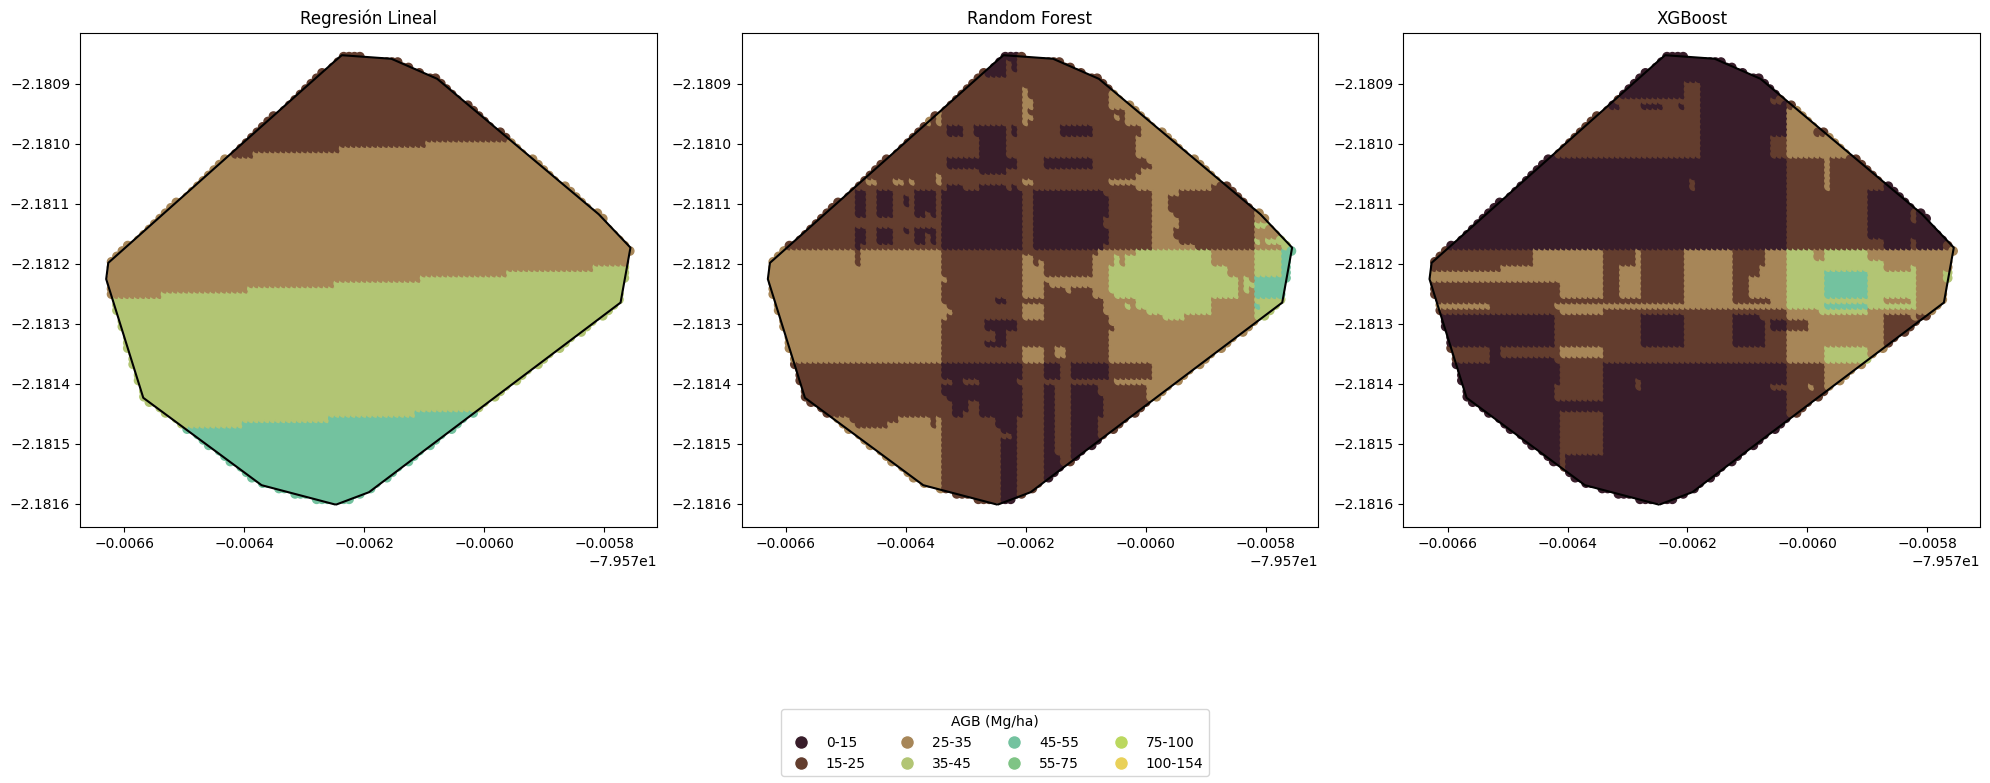

In [ ]:
# Importar las librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

# Parte 1: Generar el polígono usando los datos del dataset (convex hull)

# Crear un GeoDataFrame para los puntos del dataset (field_data)
gdf_points = gpd.GeoDataFrame(field_data, geometry=gpd.points_from_xy(field_data['lon'], field_data['lat']), crs="EPSG:4326")

# Generar el polígono usando la envolvente convexa (convex hull) de todos los puntos
convex_hull_polygon = gdf_points.unary_union.convex_hull

# Parte 2: Ahora cargamos los datos para hacer las predicciones de AGB

# Seleccionar las características y la variable objetivo (AGB)
X = field_data[['lat', 'lon', 'updated diameter', 'height', 'year']]
y = field_data['AGB']

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarizar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Crear los tres modelos
model_lr = LinearRegression()
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Entrenar los tres modelos
model_lr.fit(X_train_scaled, y_train)
model_rf.fit(X_train_scaled, y_train)
model_xgb.fit(X_train_scaled, y_train)

# Parte 3: Crear una cuadrícula de puntos (píxeles) dentro del polígono generado

# Obtener los límites del polígono generado
minx, miny, maxx, maxy = convex_hull_polygon.bounds
pixel_size = 0.000009  # Reducimos el tamaño de los píxeles para que cubra todo el polígono

# Crear una cuadrícula de puntos
x_values = np.arange(minx, maxx, pixel_size)
y_values = np.arange(miny, maxy, pixel_size)
grid_points = np.array([[x, y] for x in x_values for y in y_values])

# Filtrar los puntos que están dentro del polígono
grid_points_in_polygon = np.array([point for point in grid_points if Point(point).within(convex_hull_polygon)])

# Crear un DataFrame de los puntos dentro del polígono
grid_df = pd.DataFrame(grid_points_in_polygon, columns=['lon', 'lat'])

# Parte 4: Crear las características para predecir (rellenamos las otras columnas con valores promedio para las predicciones)
grid_df['updated diameter'] = X['updated diameter'].mean()
grid_df['height'] = X['height'].mean()
grid_df['year'] = X['year'].mean()

# Estandarizar las características de la cuadrícula
grid_scaled = scaler.transform(grid_df[['lat', 'lon', 'updated diameter', 'height', 'year']])

# Parte 5: Predecir los valores de AGB para cada punto en la cuadrícula usando los tres modelos
grid_df['predicted_agb_lr'] = model_lr.predict(grid_scaled)
grid_df['predicted_agb_rf'] = model_rf.predict(grid_scaled)
grid_df['predicted_agb_xgb'] = model_xgb.predict(grid_scaled)

# Parte 6: Agrupar los valores de AGB en intervalos
bins = [0, 15, 25, 35, 45, 55, 75, 100, 154]  # Definir los intervalos de AGB
labels = ['0-15', '15-25', '25-35', '35-45', '45-55', '55-75', '75-100', '100-154']  # Etiquetas para los intervalos
grid_df['agb_group_lr'] = pd.cut(grid_df['predicted_agb_lr'], bins=bins, labels=labels)
grid_df['agb_group_rf'] = pd.cut(grid_df['predicted_agb_rf'], bins=bins, labels=labels)
grid_df['agb_group_xgb'] = pd.cut(grid_df['predicted_agb_xgb'], bins=bins, labels=labels)

# Parte 7: Crear un colormap personalizado para los intervalos
colors = ['#381d2a', '#633d2e', '#a78658', '#b2c574', '#73c29f', '#7fc485', '#bbd85f', '#e9d159']
cmap = ListedColormap(colors)

# Convertir los puntos a un GeoDataFrame para facilitar la visualización
gdf_grid_points = gpd.GeoDataFrame(grid_df, geometry=gpd.points_from_xy(grid_df['lon'], grid_df['lat']))

# Parte 8: Graficar los polígonos con las predicciones de los tres modelos
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

# Graficar el polígono para Regresión Lineal
gdf_polygon = gpd.GeoDataFrame(geometry=[convex_hull_polygon], crs="EPSG:4326")
gdf_polygon.boundary.plot(ax=axes[0], color='black')
gdf_grid_points.plot(ax=axes[0], column='agb_group_lr', cmap=cmap, legend=False)
axes[0].set_title('Regresión Lineal')

# Graficar el polígono para Random Forest
gdf_polygon.boundary.plot(ax=axes[1], color='black')
gdf_grid_points.plot(ax=axes[1], column='agb_group_rf', cmap=cmap, legend=False)
axes[1].set_title('Random Forest')

# Graficar el polígono para XGBoost
gdf_polygon.boundary.plot(ax=axes[2], color='black')
gdf_grid_points.plot(ax=axes[2], column='agb_group_xgb', cmap=cmap, legend=False)
axes[2].set_title('XGBoost')

# Personalizar la leyenda para los tres gráficos
handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markersize=10, markerfacecolor=color) for label, color in zip(labels, colors)]
fig.legend(handles=handles, title='AGB (Mg/ha)', loc='lower center', ncol=4)

# Mostrar las tres gráficas juntas
plt.tight_layout()
plt.show()


Fitting 4 folds for each of 648 candidates, totalling 2592 fits
Fitting 4 folds for each of 108 candidates, totalling 432 fits


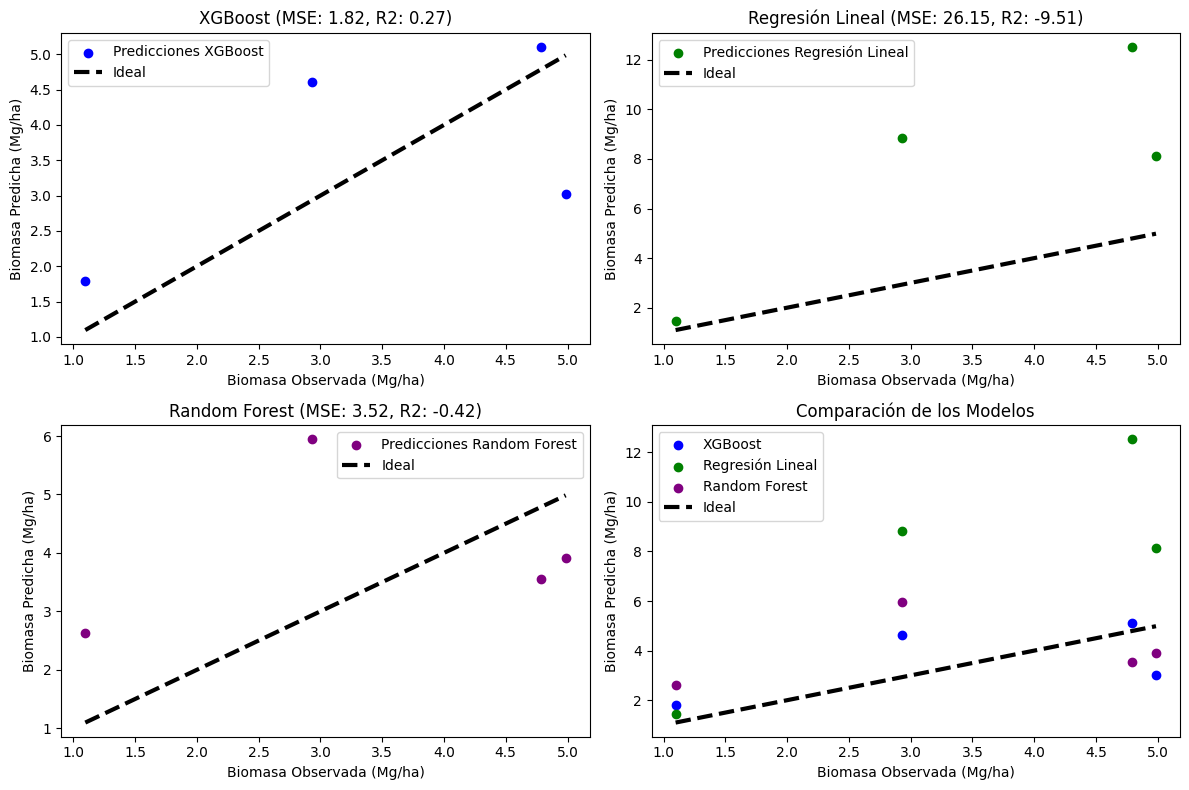

<ipython-input-213-06499a0b74a6>:129: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  convex_hull_polygon = gdf_points.unary_union.convex_hull


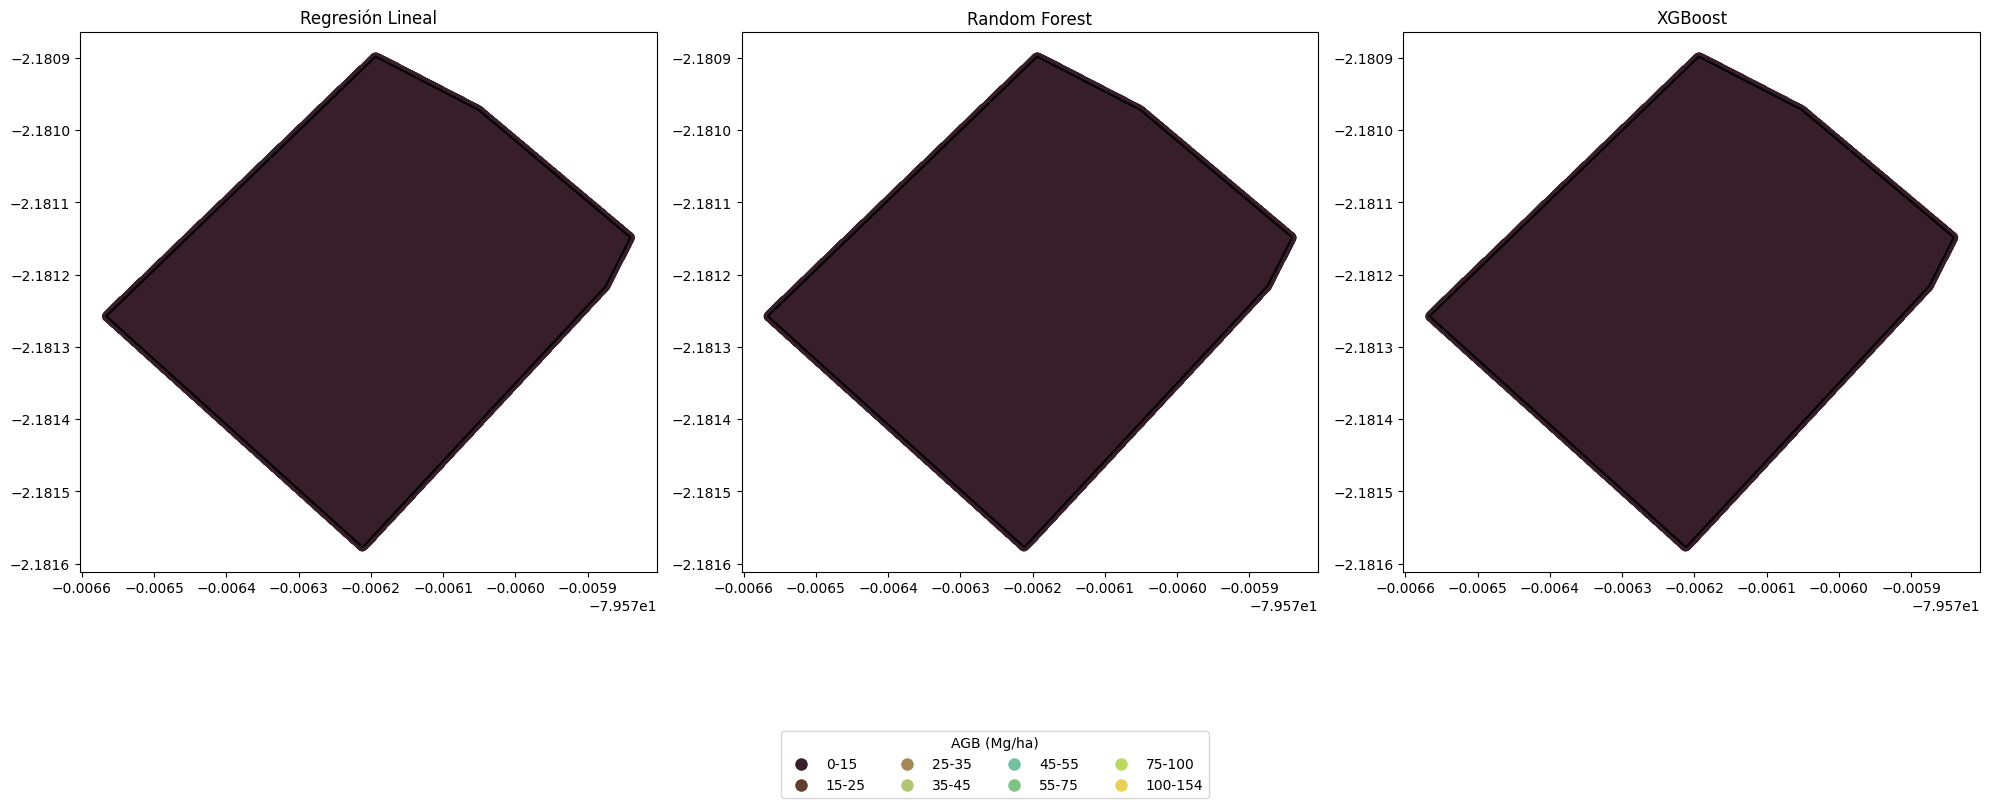

In [ ]:
# Importar las librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from matplotlib.colors import ListedColormap

# Cargar los datos y asegurarse de que no haya NaNs
dataframemg = dataframemg.dropna()

# Ingeniería de características
dataframemg['NDVI_DAP'] = dataframemg['NDVI'] / dataframemg['updated_diameter_mean']
dataframemg['HT_NDVI'] = dataframemg['height_mean'] * dataframemg['NDVI']

# Seleccionar características
numeric_features = ['NDVI', 'updated_diameter_mean', 'height_mean', 'NDVI_DAP', 'HT_NDVI']
X = dataframemg[numeric_features]
y = dataframemg['Biomasa (Mg/ha)']

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Parte 1: Entrenar y evaluar los tres modelos

# Modelo XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 1, 10]
}
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=4, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search_xgb.fit(X_train, y_train)
best_xgb = grid_search_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Modelo Regresión Lineal
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

# Modelo Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_model = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=4, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Parte 2: Visualización de los resultados de los tres modelos (gráficos de dispersión)

plt.figure(figsize=(12, 8))

# Gráfico XGBoost
plt.subplot(2, 2, 1)
plt.scatter(y_test, y_pred_xgb, color='blue', label='Predicciones XGBoost')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3, label='Ideal')
plt.xlabel('Biomasa Observada (Mg/ha)')
plt.ylabel('Biomasa Predicha (Mg/ha)')
plt.title(f'XGBoost (MSE: {mse_xgb:.2f}, R2: {r2_xgb:.2f})')
plt.legend()

# Gráfico Regresión Lineal
plt.subplot(2, 2, 2)
plt.scatter(y_test, y_pred_lr, color='green', label='Predicciones Regresión Lineal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3, label='Ideal')
plt.xlabel('Biomasa Observada (Mg/ha)')
plt.ylabel('Biomasa Predicha (Mg/ha)')
plt.title(f'Regresión Lineal (MSE: {mse_lr:.2f}, R2: {r2_lr:.2f})')
plt.legend()

# Gráfico Random Forest
plt.subplot(2, 2, 3)
plt.scatter(y_test, y_pred_rf, color='purple', label='Predicciones Random Forest')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3, label='Ideal')
plt.xlabel('Biomasa Observada (Mg/ha)')
plt.ylabel('Biomasa Predicha (Mg/ha)')
plt.title(f'Random Forest (MSE: {mse_rf:.2f}, R2: {r2_rf:.2f})')
plt.legend()

# Comparación de los tres modelos
plt.subplot(2, 2, 4)
plt.scatter(y_test, y_pred_xgb, color='blue', label='XGBoost')
plt.scatter(y_test, y_pred_lr, color='green', label='Regresión Lineal')
plt.scatter(y_test, y_pred_rf, color='purple', label='Random Forest')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3, label='Ideal')
plt.xlabel('Biomasa Observada (Mg/ha)')
plt.ylabel('Biomasa Predicha (Mg/ha)')
plt.title('Comparación de los Modelos')
plt.legend()

plt.tight_layout()
plt.show()

# Parte 3: Visualización de los polígonos usando los modelos

# Parte 1: Generar el polígono usando los datos del dataset (convex hull)

# Crear un GeoDataFrame para los puntos del dataset
gdf_points = gpd.GeoDataFrame(dataframemg, geometry=gpd.points_from_xy(dataframemg['lon_mean'], dataframemg['lat_mean']), crs="EPSG:4326")

# Generar el polígono usando la envolvente convexa (convex hull) de todos los puntos
convex_hull_polygon = gdf_points.unary_union.convex_hull

# Crear una cuadrícula de puntos dentro del polígono
minx, miny, maxx, maxy = convex_hull_polygon.bounds
pixel_size = 0.000001
x_values = np.arange(minx, maxx, pixel_size)
y_values = np.arange(miny, maxy, pixel_size)
grid_points = np.array([[x, y] for x in x_values for y in y_values])

# Filtrar los puntos que están dentro del polígono
grid_points_in_polygon = np.array([point for point in grid_points if Point(point).within(convex_hull_polygon)])
grid_df = pd.DataFrame(grid_points_in_polygon, columns=['lon', 'lat'])

# Parte 4: Crear las características para predecir
grid_df['NDVI'] = dataframemg['NDVI'].mean()
grid_df['updated_diameter_mean'] = dataframemg['updated_diameter_mean'].mean()
grid_df['height_mean'] = dataframemg['height_mean'].mean()
grid_df['NDVI_DAP'] = grid_df['NDVI'] / grid_df['updated_diameter_mean']
grid_df['HT_NDVI'] = grid_df['height_mean'] * grid_df['NDVI']

# Escalar las características de la cuadrícula
grid_scaled = scaler.transform(grid_df[numeric_features])

# Predecir los valores de AGB para cada punto en la cuadrícula
grid_df['predicted_agb_lr'] = lr_model.predict(grid_scaled)
grid_df['predicted_agb_rf'] = best_rf.predict(grid_scaled)
grid_df['predicted_agb_xgb'] = best_xgb.predict(grid_scaled)

# Agrupar los valores de AGB en intervalos
bins = [0, 15, 25, 35, 45, 55, 75, 100, 154]
labels = ['0-15', '15-25', '25-35', '35-45', '45-55', '55-75', '75-100', '100-154']
grid_df['agb_group_lr'] = pd.cut(grid_df['predicted_agb_lr'], bins=bins, labels=labels)
grid_df['agb_group_rf'] = pd.cut(grid_df['predicted_agb_rf'], bins=bins, labels=labels)
grid_df['agb_group_xgb'] = pd.cut(grid_df['predicted_agb_xgb'], bins=bins, labels=labels)

# Parte 7: Crear un colormap personalizado para los intervalos
colors = ['#381d2a', '#633d2e', '#a78658', '#b2c574', '#73c29f', '#7fc485', '#bbd85f', '#e9d159']
cmap = ListedColormap(colors)

# Convertir los puntos a un GeoDataFrame para facilitar la visualización
gdf_grid_points = gpd.GeoDataFrame(grid_df, geometry=gpd.points_from_xy(grid_df['lon'], grid_df['lat']))

# Parte 8: Graficar los polígonos con las predicciones de los tres modelos
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

# Graficar el polígono para Regresión Lineal
gdf_polygon = gpd.GeoDataFrame(geometry=[convex_hull_polygon], crs="EPSG:4326")
gdf_polygon.boundary.plot(ax=axes[0], color='black')
gdf_grid_points.plot(ax=axes[0], column='agb_group_lr', cmap=cmap, legend=False)
axes[0].set_title('Regresión Lineal')

# Graficar el polígono para Random Forest
gdf_polygon.boundary.plot(ax=axes[1], color='black')
gdf_grid_points.plot(ax=axes[1], column='agb_group_rf', cmap=cmap, legend=False)
axes[1].set_title('Random Forest')

# Graficar el polígono para XGBoost
gdf_polygon.boundary.plot(ax=axes[2], color='black')
gdf_grid_points.plot(ax=axes[2], column='agb_group_xgb', cmap=cmap, legend=False)
axes[2].set_title('XGBoost')

# Personalizar la leyenda para los tres gráficos
handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markersize=10, markerfacecolor=color) for label, color in zip(labels, colors)]
fig.legend(handles=handles, title='AGB (Mg/ha)', loc='lower center', ncol=4)

# Mostrar las tres gráficas juntas
plt.tight_layout()
plt.show()



# Predicción polígono

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


          Name Description                                           geometry
0  polecuador1              POLYGON Z ((-79.57683 -2.18186 0, -79.57672 -2...


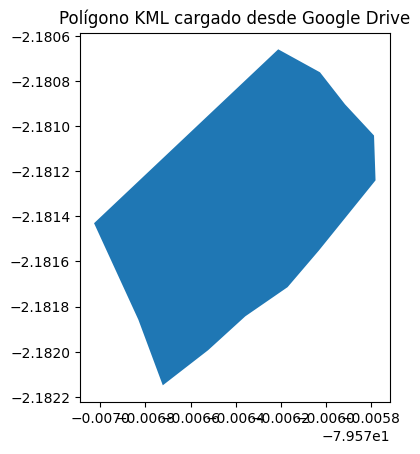

In [ ]:
# Importar las librerías necesarias
import geopandas as gpd
import matplotlib.pyplot as plt



# Definir la ruta de tu archivo KML en Google Drive
file_path = '/content/drive/My Drive/polecuador1.kml'  # Actualiza esta ruta

# Leer el archivo KML usando geopandas
gdf_kml = gpd.read_file(file_path, driver='KML')

# Mostrar el polígono leído desde el archivo KML
print(gdf_kml.head())

# Graficar el polígono
gdf_kml.plot()
plt.title('Polígono KML cargado desde Google Drive')
plt.show()


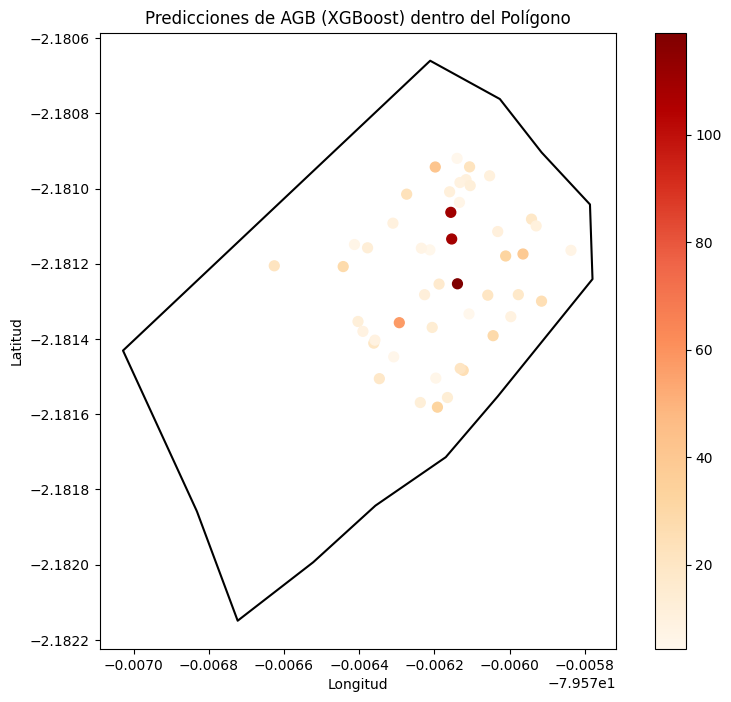

In [ ]:
# Importar las librerías necesarias
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from google.colab import drive
import pandas as pd


# Definir la ruta del archivo KML en Google Drive (actualiza esta ruta con tu archivo)
file_path = '/content/drive/My Drive/polecuador1.kml'

# Leer el archivo KML usando geopandas
gdf_kml = gpd.read_file(file_path, driver='KML')


# Ahora cargamos los datos para hacer las predicciones de AGB

field_data = field_data

# Seleccionar las características y la variable objetivo (AGB)
X = field_data[['lat', 'lon', 'updated diameter', 'height', 'year']]
y = field_data['AGB']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarizar las características
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear los modelos
model_lr = LinearRegression()
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Entrenar los modelos
model_lr.fit(X_train_scaled, y_train)
model_rf.fit(X_train_scaled, y_train)
model_xgb.fit(X_train_scaled, y_train)

# Hacer predicciones con los datos de prueba
y_pred_lr = model_lr.predict(X_test_scaled)
y_pred_rf = model_rf.predict(X_test_scaled)
y_pred_xgb = model_xgb.predict(X_test_scaled)

# Añadir las predicciones al conjunto de prueba
X_test['pred_lr'] = y_pred_lr
X_test['pred_rf'] = y_pred_rf
X_test['pred_xgb'] = y_pred_xgb

# Convertir los datos de prueba en puntos geográficos
gdf_points = gpd.GeoDataFrame(X_test, geometry=gpd.points_from_xy(X_test['lon'], X_test['lat']))

# Filtrar solo los puntos que están dentro del polígono cargado
gdf_points_in_polygon = gdf_points[gdf_points.within(gdf_kml.geometry[0])]

# Graficar el polígono y las predicciones de AGB dentro del área
fig, ax = plt.subplots(figsize=(10, 8))

# Graficar el polígono
gdf_kml.boundary.plot(ax=ax, color='black')

# Graficar los puntos con las predicciones del modelo XGBoost
gdf_points_in_polygon.plot(ax=ax, column='pred_xgb', cmap='OrRd', legend=True, markersize=50)

# Añadir etiquetas y título
plt.title('Predicciones de AGB (XGBoost) dentro del Polígono')
plt.xlabel('Longitud')
plt.ylabel('Latitud')

# Mostrar el gráfico
plt.show()


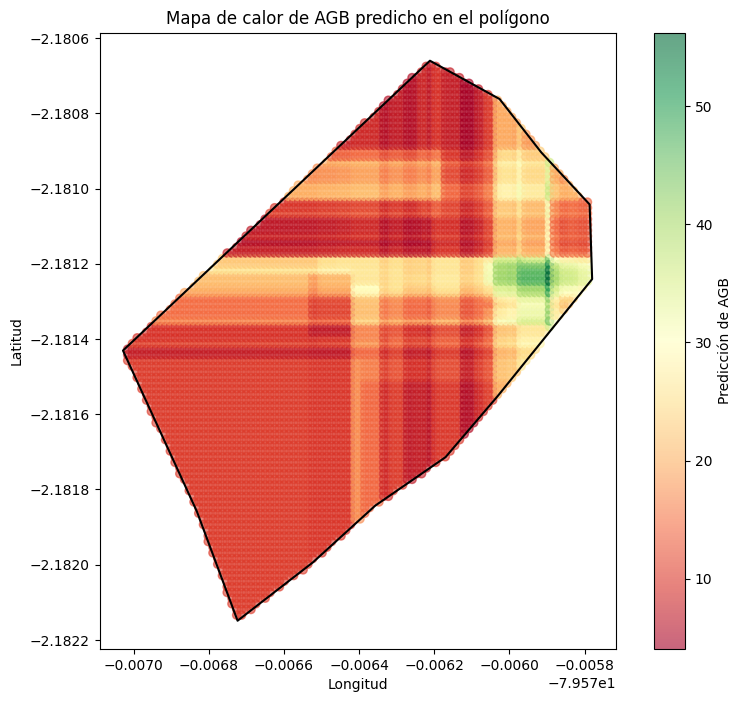

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from shapely.geometry import Point
from shapely.geometry import Polygon
from google.colab import drive

# Definir la ruta del archivo KML en Google Drive (actualiza esta ruta con tu archivo)
file_path = '/content/drive/My Drive/polecuador1.kml'

# Leer el archivo KML usando geopandas
gdf_kml = gpd.read_file(file_path, driver='KML')


# Ahora cargamos los datos para hacer las predicciones de AGB

field_data = field_data
# Seleccionar las características y la variable objetivo (AGB)
X = field_data[['lat', 'lon', 'updated diameter', 'height', 'year']]
y = field_data['AGB']

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarizar las características
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Crear los modelos
model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Entrenar los modelos
model_xgb.fit(X_train_scaled, y_train)

# Crear una cuadrícula de puntos dentro del polígono
minx, miny, maxx, maxy = gdf_kml.total_bounds
x_values = np.linspace(minx, maxx, 100)  # 100 puntos a lo largo del eje x
y_values = np.linspace(miny, maxy, 100)  # 100 puntos a lo largo del eje y
grid_points = np.array([[x, y] for x in x_values for y in y_values])

# Filtrar los puntos que están dentro del polígono
polygon = gdf_kml.geometry[0]  # El polígono del KML
grid_points_in_polygon = np.array([point for point in grid_points if Point(point).within(polygon)])

# Crear un DataFrame de los puntos dentro del polígono
grid_df = pd.DataFrame(grid_points_in_polygon, columns=['lon', 'lat'])

# Crear las características para predecir (rellenamos las otras columnas con valores promedio para las predicciones)
grid_df['updated diameter'] = X['updated diameter'].mean()
grid_df['height'] = X['height'].mean()
grid_df['year'] = X['year'].mean()

# Estandarizar las características
grid_scaled = scaler.transform(grid_df[['lat', 'lon', 'updated diameter', 'height', 'year']])

# Predecir los valores de AGB para cada punto en la cuadrícula
grid_df['predicted_agb'] = model_xgb.predict(grid_scaled)

# Graficar el polígono con las predicciones en una escala de color
fig, ax = plt.subplots(figsize=(10, 8))

# Graficar el polígono
gdf_kml.boundary.plot(ax=ax, color='black')

# Crear un mapa de calor con los valores de AGB predichos
sc = ax.scatter(grid_df['lon'], grid_df['lat'], c=grid_df['predicted_agb'], cmap='RdYlGn', marker='o', alpha=0.6)

# Añadir la barra de colores (para mostrar los valores de AGB)
plt.colorbar(sc, label='Predicción de AGB')

# Añadir etiquetas y título
plt.title('Mapa de calor de AGB predicho en el polígono')
plt.xlabel('Longitud')
plt.ylabel('Latitud')

# Mostrar el gráfico
plt.show()


In [ ]:
# Importar la librería para análisis espacial
!pip install pysal


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 50.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.3/347.3 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.0/59.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/4

In [ ]:
# Importar librerías necesarias
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from shapely.geometry import Point
from esda.moran import Moran
from libpysal.weights import Queen


# Definir la ruta del archivo KML en Google Drive (actualiza esta ruta con tu archivo)
file_path = '/content/drive/My Drive/polecuador1.kml'

# Leer el archivo KML usando geopandas
gdf_kml = gpd.read_file(file_path, driver='KML')


# Ahora cargamos los datos para hacer las predicciones de AGB
field_data = field_data

# Seleccionar las características y la variable objetivo (AGB)
X = field_data[['lat', 'lon', 'updated diameter', 'height', 'year']]
y = field_data['AGB']

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarizar las características
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Crear el modelo XGBoost
model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Entrenar los modelos
model_xgb.fit(X_train_scaled, y_train)

# Crear una cuadrícula de puntos dentro del polígono
minx, miny, maxx, maxy = gdf_kml.total_bounds
x_values = np.linspace(minx, maxx, 100)  # 100 puntos a lo largo del eje x
y_values = np.linspace(miny, maxy, 100)  # 100 puntos a lo largo del eje y
grid_points = np.array([[x, y] for x in x_values for y in y_values])

# Filtrar los puntos que están dentro del polígono
polygon = gdf_kml.geometry[0]  # El polígono del KML
grid_points_in_polygon = np.array([point for point in grid_points if Point(point).within(polygon)])

# Crear un DataFrame de los puntos dentro del polígono
grid_df = pd.DataFrame(grid_points_in_polygon, columns=['lon', 'lat'])

# Crear las características para predecir (rellenamos las otras columnas con valores promedio para las predicciones)
grid_df['updated diameter'] = X['updated diameter'].mean()
grid_df['height'] = X['height'].mean()
grid_df['year'] = X['year'].mean()

# Estandarizar las características
grid_scaled = scaler.transform(grid_df[['lat', 'lon', 'updated diameter', 'height', 'year']])

# Predecir los valores de AGB para cada punto en la cuadrícula
grid_df['predicted_agb'] = model_xgb.predict(grid_scaled)

# Convertir los puntos a un GeoDataFrame para el análisis espacial
gdf_points = gpd.GeoDataFrame(grid_df, geometry=gpd.points_from_xy(grid_df['lon'], grid_df['lat']))

# Crear una matriz de pesos espaciales utilizando la vecindad de la Reina (Queen's Case)
w = Queen.from_dataframe(gdf_points)

# Calcular la autocorrelación espacial usando Moran's I
moran = Moran(gdf_points['predicted_agb'], w)

# Mostrar los resultados de Moran's I
print(f"Moran's I: {moran.I}")
print(f"P-value: {moran.p_sim}")

# Interpretación:
if moran.p_sim < 0.05:
    print("Existe autocorrelación espacial significativa en los valores predichos de AGB.")
else:
    print("No se encontró autocorrelación espacial significativa en los valores predichos de AGB.")


<ipython-input-32-abebf77b7446>:69: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf_points)


Moran's I: 0.9083205154948887
P-value: 0.001
Existe autocorrelación espacial significativa en los valores predichos de AGB.


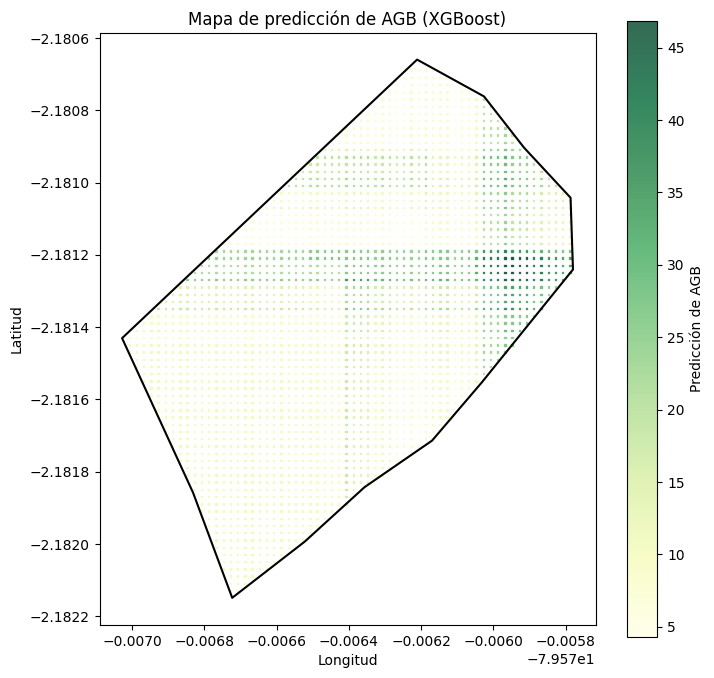

In [ ]:
# Importar las librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from xgboost import XGBRegressor
from google.colab import drive

# Definir la ruta del archivo KML en Google Drive (actualiza esta ruta con tu archivo)
file_path = '/content/drive/My Drive/polecuador1.kml'

# Leer el archivo KML usando geopandas
gdf_kml = gpd.read_file(file_path, driver='KML')


# Ahora cargamos los datos para hacer las predicciones de AGB
field_data = field_data

# Seleccionar las características y la variable objetivo (AGB)
X = field_data[['lat', 'lon', 'updated diameter', 'height', 'year']]
y = field_data['AGB']

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarizar las características
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Crear el modelo XGBoost
model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Entrenar el modelo
model_xgb.fit(X_train_scaled, y_train)

# Crear una cuadrícula de puntos (píxeles) dentro del polígono
minx, miny, maxx, maxy = gdf_kml.total_bounds
pixel_size = 0.00002  # Reducimos el tamaño de los píxeles para que haya más puntos dentro del polígono

# Crear una cuadrícula de puntos
x_values = np.arange(minx, maxx, pixel_size)
y_values = np.arange(miny, maxy, pixel_size)
grid_points = np.array([[x, y] for x in x_values for y in y_values])

# Filtrar los puntos que están dentro del polígono
polygon = gdf_kml.geometry[0]  # El polígono del KML
grid_points_in_polygon = np.array([point for point in grid_points if Point(point).within(polygon)])

# Crear un DataFrame de los puntos dentro del polígono
grid_df = pd.DataFrame(grid_points_in_polygon, columns=['lon', 'lat'])

# Crear las características para predecir (rellenamos las otras columnas con valores promedio para las predicciones)
grid_df['updated diameter'] = X['updated diameter'].mean()
grid_df['height'] = X['height'].mean()
grid_df['year'] = X['year'].mean()

# Estandarizar las características de la cuadrícula
grid_scaled = scaler.transform(grid_df[['lat', 'lon', 'updated diameter', 'height', 'year']])

# Predecir los valores de AGB para cada punto en la cuadrícula
grid_df['predicted_agb'] = model_xgb.predict(grid_scaled)

# Convertir los puntos a un GeoDataFrame para facilitar la visualización
gdf_points = gpd.GeoDataFrame(grid_df, geometry=gpd.points_from_xy(grid_df['lon'], grid_df['lat']))

# Crear el mapa visual con alta densidad de píxeles
fig, ax = plt.subplots(figsize=(8, 8))

# Graficar el polígono
gdf_kml.boundary.plot(ax=ax, color='black')

# Crear un mapa de calor (alta densidad de píxeles)
sc = ax.scatter(gdf_points['lon'], gdf_points['lat'], c=gdf_points['predicted_agb'], cmap='YlGn', marker='s', s=1, alpha=0.8)

# Añadir la barra de colores para mostrar los valores de AGB
plt.colorbar(sc, label='Predicción de AGB')

# Añadir etiquetas y título
plt.title('Mapa de predicción de AGB (XGBoost)')
plt.xlabel('Longitud')
plt.ylabel('Latitud')

# Mostrar el gráfico
plt.show()


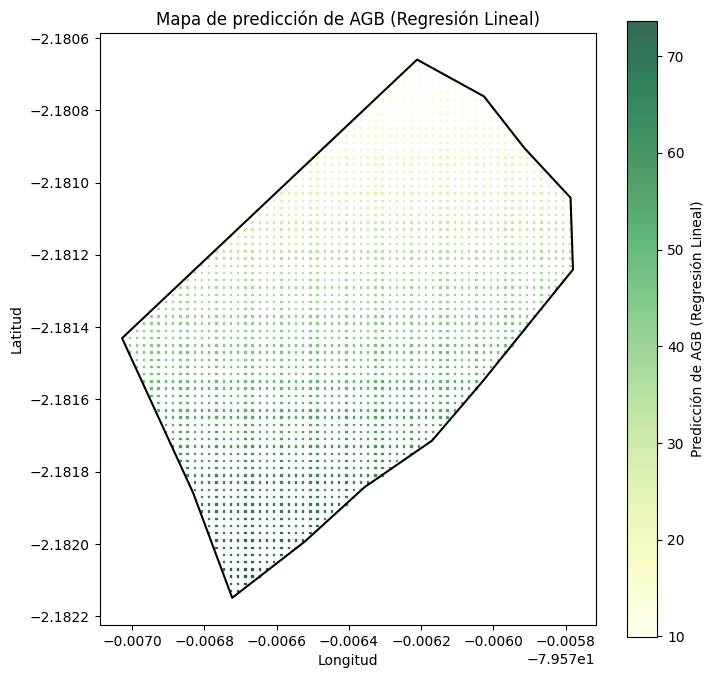

In [ ]:
# Importar las librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from sklearn.linear_model import LinearRegression
from google.colab import drive

# Definir la ruta del archivo KML en Google Drive (actualiza esta ruta con tu archivo)
file_path = '/content/drive/My Drive/polecuador1.kml'

# Leer el archivo KML usando geopandas
gdf_kml = gpd.read_file(file_path, driver='KML')


# Ahora cargamos los datos para hacer las predicciones de AGB
field_data = field_data

# Seleccionar las características y la variable objetivo (AGB)
X = field_data[['lat', 'lon', 'updated diameter', 'height', 'year']]
y = field_data['AGB']

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarizar las características
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Crear el modelo de Regresión Lineal
model_lr = LinearRegression()

# Entrenar el modelo
model_lr.fit(X_train_scaled, y_train)

# Crear una cuadrícula de puntos (píxeles) dentro del polígono
minx, miny, maxx, maxy = gdf_kml.total_bounds
pixel_size = 0.00002  # Reducimos el tamaño de los píxeles para que haya más puntos dentro del polígono

# Crear una cuadrícula de puntos
x_values = np.arange(minx, maxx, pixel_size)
y_values = np.arange(miny, maxy, pixel_size)
grid_points = np.array([[x, y] for x in x_values for y in y_values])

# Filtrar los puntos que están dentro del polígono
polygon = gdf_kml.geometry[0]  # El polígono del KML
grid_points_in_polygon = np.array([point for point in grid_points if Point(point).within(polygon)])

# Crear un DataFrame de los puntos dentro del polígono
grid_df = pd.DataFrame(grid_points_in_polygon, columns=['lon', 'lat'])

# Crear las características para predecir (rellenamos las otras columnas con valores promedio para las predicciones)
grid_df['updated diameter'] = X['updated diameter'].mean()
grid_df['height'] = X['height'].mean()
grid_df['year'] = X['year'].mean()

# Estandarizar las características de la cuadrícula
grid_scaled = scaler.transform(grid_df[['lat', 'lon', 'updated diameter', 'height', 'year']])

# Predecir los valores de AGB para cada punto en la cuadrícula usando Regresión Lineal
grid_df['predicted_agb'] = model_lr.predict(grid_scaled)

# Convertir los puntos a un GeoDataFrame para facilitar la visualización
gdf_points = gpd.GeoDataFrame(grid_df, geometry=gpd.points_from_xy(grid_df['lon'], grid_df['lat']))

# Crear el mapa visual con alta densidad de píxeles
fig, ax = plt.subplots(figsize=(8, 8))

# Graficar el polígono
gdf_kml.boundary.plot(ax=ax, color='black')

# Crear un mapa de calor (alta densidad de píxeles)
sc = ax.scatter(gdf_points['lon'], gdf_points['lat'], c=gdf_points['predicted_agb'], cmap='YlGn', marker='s', s=1, alpha=0.8)

# Añadir la barra de colores para mostrar los valores de AGB
plt.colorbar(sc, label='Predicción de AGB (Regresión Lineal)')

# Añadir etiquetas y título
plt.title('Mapa de predicción de AGB (Regresión Lineal)')
plt.xlabel('Longitud')
plt.ylabel('Latitud')

# Mostrar el gráfico
plt.show()


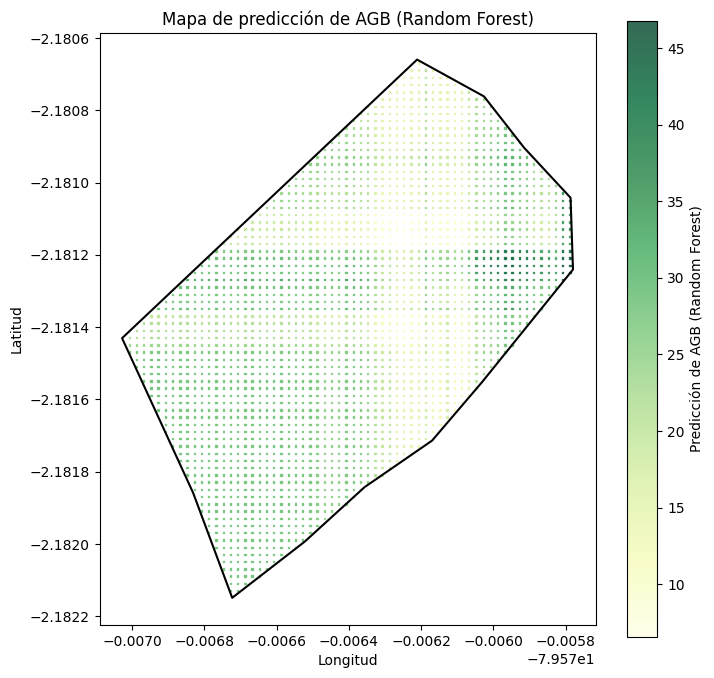

In [ ]:
# Importar las librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from sklearn.ensemble import RandomForestRegressor
from google.colab import drive

# Definir la ruta del archivo KML en Google Drive (actualiza esta ruta con tu archivo)
file_path = '/content/drive/My Drive/polecuador1.kml'

# Leer el archivo KML usando geopandas
gdf_kml = gpd.read_file(file_path, driver='KML')


# Ahora cargamos los datos para hacer las predicciones de AGB
field_data = field_data

# Seleccionar las características y la variable objetivo (AGB)
X = field_data[['lat', 'lon', 'updated diameter', 'height', 'year']]
y = field_data['AGB']

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarizar las características
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Crear el modelo Random Forest
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Entrenar el modelo
model_rf.fit(X_train_scaled, y_train)

# Crear una cuadrícula de puntos (píxeles) dentro del polígono
minx, miny, maxx, maxy = gdf_kml.total_bounds
pixel_size = 0.00002  # Reducimos el tamaño de los píxeles para que haya más puntos dentro del polígono

# Crear una cuadrícula de puntos
x_values = np.arange(minx, maxx, pixel_size)
y_values = np.arange(miny, maxy, pixel_size)
grid_points = np.array([[x, y] for x in x_values for y in y_values])

# Filtrar los puntos que están dentro del polígono
polygon = gdf_kml.geometry[0]  # El polígono del KML
grid_points_in_polygon = np.array([point for point in grid_points if Point(point).within(polygon)])

# Crear un DataFrame de los puntos dentro del polígono
grid_df = pd.DataFrame(grid_points_in_polygon, columns=['lon', 'lat'])

# Crear las características para predecir (rellenamos las otras columnas con valores promedio para las predicciones)
grid_df['updated diameter'] = X['updated diameter'].mean()
grid_df['height'] = X['height'].mean()
grid_df['year'] = X['year'].mean()

# Estandarizar las características de la cuadrícula
grid_scaled = scaler.transform(grid_df[['lat', 'lon', 'updated diameter', 'height', 'year']])

# Predecir los valores de AGB para cada punto en la cuadrícula usando Random Forest
grid_df['predicted_agb'] = model_rf.predict(grid_scaled)

# Convertir los puntos a un GeoDataFrame para facilitar la visualización
gdf_points = gpd.GeoDataFrame(grid_df, geometry=gpd.points_from_xy(grid_df['lon'], grid_df['lat']))

# Crear el mapa visual con alta densidad de píxeles
fig, ax = plt.subplots(figsize=(8, 8))

# Graficar el polígono
gdf_kml.boundary.plot(ax=ax, color='black')

# Crear un mapa de calor (alta densidad de píxeles)
sc = ax.scatter(gdf_points['lon'], gdf_points['lat'], c=gdf_points['predicted_agb'], cmap='YlGn', marker='s', s=1, alpha=0.8)

# Añadir la barra de colores para mostrar los valores de AGB
plt.colorbar(sc, label='Predicción de AGB (Random Forest)')

# Añadir etiquetas y título
plt.title('Mapa de predicción de AGB (Random Forest)')
plt.xlabel('Longitud')
plt.ylabel('Latitud')

# Mostrar el gráfico
plt.show()


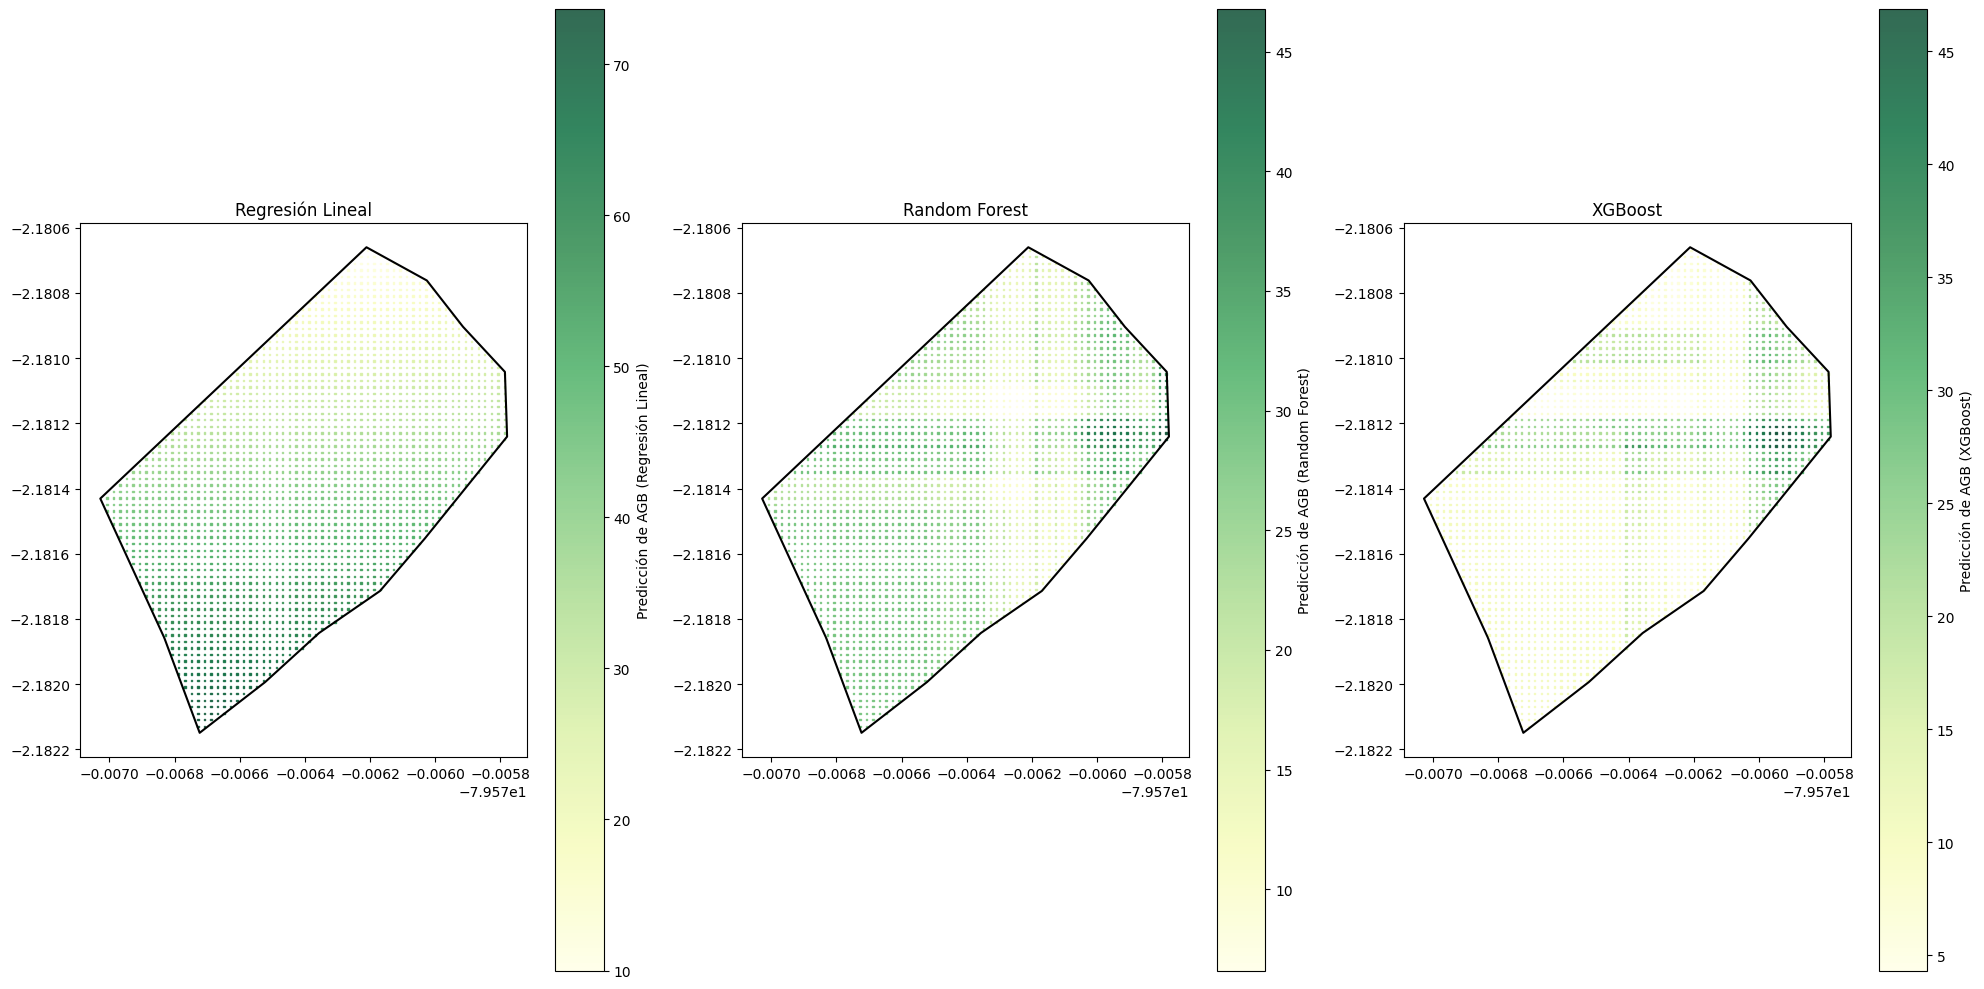

In [ ]:
# Importar las librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from google.colab import drive

# Definir la ruta del archivo KML en Google Drive (actualiza esta ruta con tu archivo)
file_path = '/content/drive/My Drive/polecuador1.kml'

# Leer el archivo KML usando geopandas
gdf_kml = gpd.read_file(file_path, driver='KML')


# Ahora cargamos los datos para hacer las predicciones de AGB
field_data = field_data

# Seleccionar las características y la variable objetivo (AGB)
X = field_data[['lat', 'lon', 'updated diameter', 'height', 'year']]
y = field_data['AGB']

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarizar las características
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Crear los tres modelos
model_lr = LinearRegression()
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Entrenar los tres modelos
model_lr.fit(X_train_scaled, y_train)
model_rf.fit(X_train_scaled, y_train)
model_xgb.fit(X_train_scaled, y_train)

# Crear una cuadrícula de puntos (píxeles) dentro del polígono
minx, miny, maxx, maxy = gdf_kml.total_bounds
pixel_size = 0.00002  # Reducimos el tamaño de los píxeles para que haya más puntos dentro del polígono

# Crear una cuadrícula de puntos
x_values = np.arange(minx, maxx, pixel_size)
y_values = np.arange(miny, maxy, pixel_size)
grid_points = np.array([[x, y] for x in x_values for y in y_values])

# Filtrar los puntos que están dentro del polígono
polygon = gdf_kml.geometry[0]  # El polígono del KML
grid_points_in_polygon = np.array([point for point in grid_points if Point(point).within(polygon)])

# Crear un DataFrame de los puntos dentro del polígono
grid_df = pd.DataFrame(grid_points_in_polygon, columns=['lon', 'lat'])

# Crear las características para predecir (rellenamos las otras columnas con valores promedio para las predicciones)
grid_df['updated diameter'] = X['updated diameter'].mean()
grid_df['height'] = X['height'].mean()
grid_df['year'] = X['year'].mean()

# Estandarizar las características de la cuadrícula
grid_scaled = scaler.transform(grid_df[['lat', 'lon', 'updated diameter', 'height', 'year']])

# Predecir los valores de AGB para cada punto en la cuadrícula usando los tres modelos
grid_df['predicted_agb_lr'] = model_lr.predict(grid_scaled)
grid_df['predicted_agb_rf'] = model_rf.predict(grid_scaled)
grid_df['predicted_agb_xgb'] = model_xgb.predict(grid_scaled)

# Convertir los puntos a un GeoDataFrame para facilitar la visualización
gdf_points = gpd.GeoDataFrame(grid_df, geometry=gpd.points_from_xy(grid_df['lon'], grid_df['lat']))

# Crear una figura para mostrar las tres gráficas
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

# Graficar las predicciones de Regresión Lineal
gdf_kml.boundary.plot(ax=axes[0], color='black')
sc1 = axes[0].scatter(gdf_points['lon'], gdf_points['lat'], c=gdf_points['predicted_agb_lr'], cmap='YlGn', marker='s', s=1, alpha=0.8)
axes[0].set_title('Regresión Lineal')
plt.colorbar(sc1, ax=axes[0], label='Predicción de AGB (Regresión Lineal)')

# Graficar las predicciones de Random Forest
gdf_kml.boundary.plot(ax=axes[1], color='black')
sc2 = axes[1].scatter(gdf_points['lon'], gdf_points['lat'], c=gdf_points['predicted_agb_rf'], cmap='YlGn', marker='s', s=1, alpha=0.8)
axes[1].set_title('Random Forest')
plt.colorbar(sc2, ax=axes[1], label='Predicción de AGB (Random Forest)')

# Graficar las predicciones de XGBoost
gdf_kml.boundary.plot(ax=axes[2], color='black')
sc3 = axes[2].scatter(gdf_points['lon'], gdf_points['lat'], c=gdf_points['predicted_agb_xgb'], cmap='YlGn', marker='s', s=1, alpha=0.8)
axes[2].set_title('XGBoost')
plt.colorbar(sc3, ax=axes[2], label='Predicción de AGB (XGBoost)')

# Mostrar las tres gráficas juntas
plt.tight_layout()
plt.show()


Valor mínimo de AGB dentro del polígono: 1.546620468515585
Valor máximo de AGB dentro del polígono: 1238.1597831281422


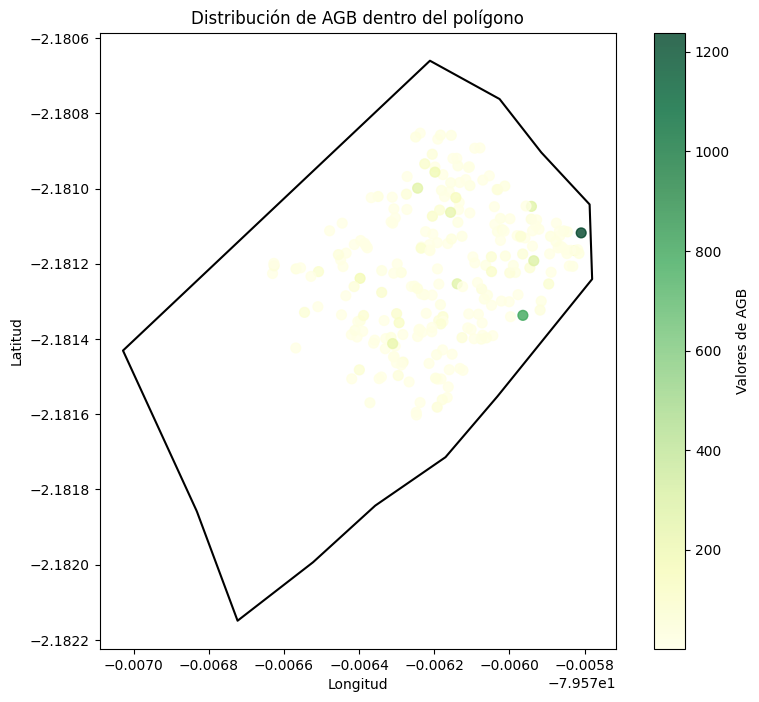

In [ ]:
# Importar las librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from google.colab import drive, files

#  Definir la ruta del archivo KML en Google Drive (actualiza esta ruta con tu archivo)
file_path = '/content/drive/My Drive/polecuador1.kml'

# Leer el archivo KML usando geopandas
gdf_kml = gpd.read_file(file_path, driver='KML')


# Ahora cargamos los datos para hacer las predicciones de AGB
field_data = field_data


# Seleccionar las columnas relevantes: latitud, longitud, y AGB
latitudes = field_data['lat']
longitudes = field_data['lon']
agb_values = field_data['AGB']  # Asegúrate de que 'AGB' es la columna correcta para biomasa

# Crear un GeoDataFrame para los puntos de AGB
gdf_agb_points = gpd.GeoDataFrame(field_data, geometry=gpd.points_from_xy(field_data['lon'], field_data['lat']))

# Filtrar los puntos que están dentro del polígono
gdf_agb_points_in_polygon = gdf_agb_points[gdf_agb_points.within(gdf_kml.geometry[0])]

# Obtener el valor mínimo y máximo de AGB en los puntos dentro del polígono
min_agb = gdf_agb_points_in_polygon['AGB'].min()
max_agb = gdf_agb_points_in_polygon['AGB'].max()

# Verificar los valores mínimo y máximo
print(f"Valor mínimo de AGB dentro del polígono: {min_agb}")
print(f"Valor máximo de AGB dentro del polígono: {max_agb}")

# Crear un gráfico de dispersión para visualizar las coordenadas y el valor de AGB dentro del polígono
plt.figure(figsize=(10, 8))

# Graficar el polígono
gdf_kml.boundary.plot(ax=plt.gca(), color='black')

# Crear un scatter plot donde los colores representan el valor de AGB
sc = plt.scatter(gdf_agb_points_in_polygon['lon'], gdf_agb_points_in_polygon['lat'],
                 c=gdf_agb_points_in_polygon['AGB'], cmap='YlGn', marker='o', s=50, alpha=0.8,
                 vmin=min_agb, vmax=max_agb)

# Añadir una barra de colores para mostrar los valores de AGB
cbar = plt.colorbar(sc)
cbar.set_label('Valores de AGB')

# Etiquetas y título del gráfico
plt.title('Distribución de AGB dentro del polígono')
plt.xlabel('Longitud')
plt.ylabel('Latitud')

# Mostrar el gráfico
plt.show()


/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

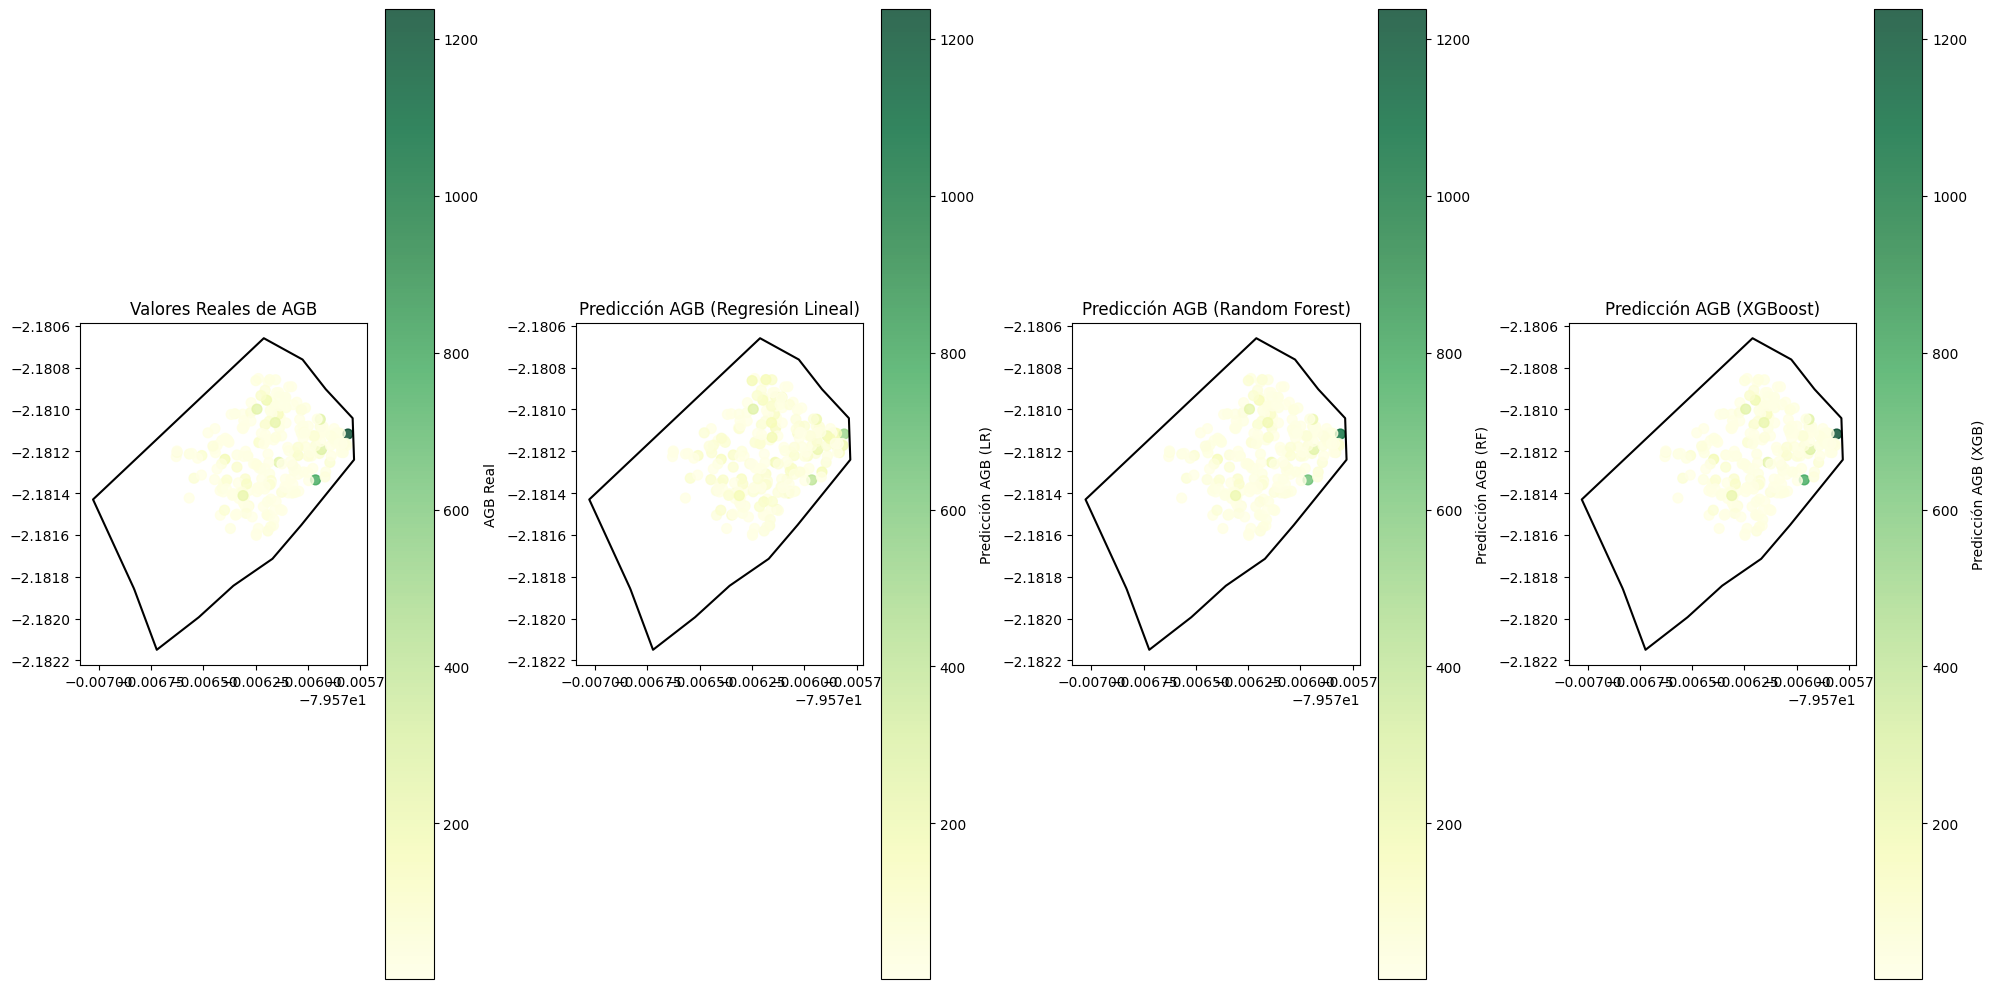

In [ ]:
# Importar las librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from google.colab import drive, files
from sklearn.preprocessing import StandardScaler

#  Definir la ruta del archivo KML en Google Drive (actualiza esta ruta con tu archivo)
file_path = '/content/drive/My Drive/polecuador1.kml'

# Leer el archivo KML usando geopandas
gdf_kml = gpd.read_file(file_path, driver='KML')


# Ahora cargamos los datos para hacer las predicciones de AGB
field_data = field_data

# Seleccionar las columnas relevantes: latitud, longitud, y AGB
latitudes = field_data['lat']
longitudes = field_data['lon']
agb_values = field_data['AGB']

# Crear un GeoDataFrame para los puntos de AGB
gdf_agb_points = gpd.GeoDataFrame(field_data, geometry=gpd.points_from_xy(field_data['lon'], field_data['lat']))

# Filtrar los puntos que están dentro del polígono
gdf_agb_points_in_polygon = gdf_agb_points[gdf_agb_points.within(gdf_kml.geometry[0])]

# Seleccionar las características para entrenar y predecir (sin dividir en entrenamiento y prueba)
X = gdf_agb_points_in_polygon[['lat', 'lon', 'updated diameter', 'height', 'year']]
y = gdf_agb_points_in_polygon['AGB']

# Estandarizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Crear los modelos
model_lr = LinearRegression()
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Entrenar los modelos y hacer predicciones sobre todo el conjunto de datos
gdf_agb_points_in_polygon['predicted_agb_lr'] = model_lr.fit(X_scaled, y).predict(X_scaled)
gdf_agb_points_in_polygon['predicted_agb_rf'] = model_rf.fit(X_scaled, y).predict(X_scaled)
gdf_agb_points_in_polygon['predicted_agb_xgb'] = model_xgb.fit(X_scaled, y).predict(X_scaled)

# Obtener el valor mínimo y máximo de AGB en los puntos dentro del polígono
min_agb = gdf_agb_points_in_polygon['AGB'].min()
max_agb = gdf_agb_points_in_polygon['AGB'].max()

# Crear una figura para mostrar los valores reales y las predicciones de los tres modelos
fig, axes = plt.subplots(1, 4, figsize=(20, 10))

# Graficar los valores reales de AGB
gdf_kml.boundary.plot(ax=axes[0], color='black')
sc_real = axes[0].scatter(gdf_agb_points_in_polygon['lon'], gdf_agb_points_in_polygon['lat'],
                          c=gdf_agb_points_in_polygon['AGB'], cmap='YlGn', marker='o', s=50, alpha=0.8,
                          vmin=min_agb, vmax=max_agb)
axes[0].set_title('Valores Reales de AGB')
plt.colorbar(sc_real, ax=axes[0], label='AGB Real')

# Graficar las predicciones de Regresión Lineal
gdf_kml.boundary.plot(ax=axes[1], color='black')
sc_lr = axes[1].scatter(gdf_agb_points_in_polygon['lon'], gdf_agb_points_in_polygon['lat'],
                        c=gdf_agb_points_in_polygon['predicted_agb_lr'], cmap='YlGn', marker='o', s=50, alpha=0.8,
                        vmin=min_agb, vmax=max_agb)
axes[1].set_title('Predicción AGB (Regresión Lineal)')
plt.colorbar(sc_lr, ax=axes[1], label='Predicción AGB (LR)')

# Graficar las predicciones de Random Forest
gdf_kml.boundary.plot(ax=axes[2], color='black')
sc_rf = axes[2].scatter(gdf_agb_points_in_polygon['lon'], gdf_agb_points_in_polygon['lat'],
                        c=gdf_agb_points_in_polygon['predicted_agb_rf'], cmap='YlGn', marker='o', s=50, alpha=0.8,
                        vmin=min_agb, vmax=max_agb)
axes[2].set_title('Predicción AGB (Random Forest)')
plt.colorbar(sc_rf, ax=axes[2], label='Predicción AGB (RF)')

# Graficar las predicciones de XGBoost
gdf_kml.boundary.plot(ax=axes[3], color='black')
sc_xgb = axes[3].scatter(gdf_agb_points_in_polygon['lon'], gdf_agb_points_in_polygon['lat'],
                         c=gdf_agb_points_in_polygon['predicted_agb_xgb'], cmap='YlGn', marker='o', s=50, alpha=0.8,
                         vmin=min_agb, vmax=max_agb)
axes[3].set_title('Predicción AGB (XGBoost)')
plt.colorbar(sc_xgb, ax=axes[3], label='Predicción AGB (XGB)')

# Ajustar el diseño del gráfico
plt.tight_layout()
plt.show()


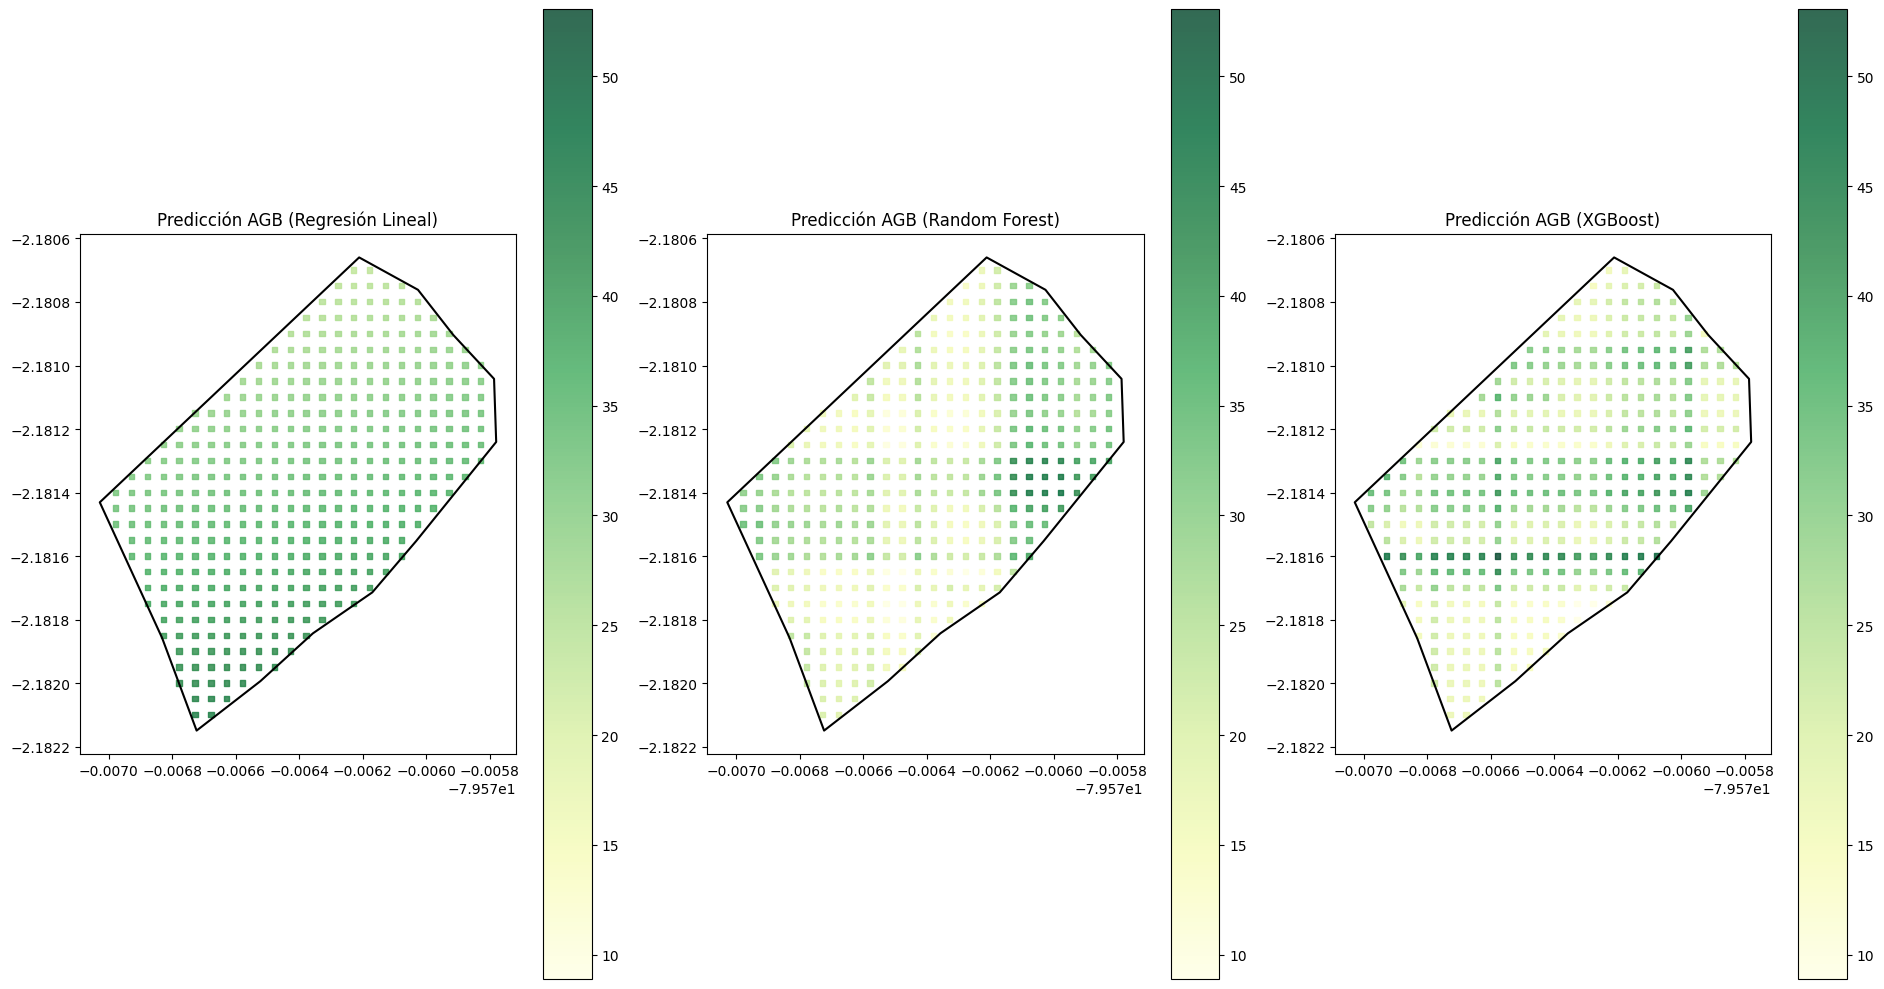

In [ ]:
# Importar las librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from google.colab import drive, files
from sklearn.preprocessing import StandardScaler

#  Definir la ruta del archivo KML en Google Drive (actualiza esta ruta con tu archivo)
file_path = '/content/drive/My Drive/polecuador1.kml'

# Leer el archivo KML usando geopandas
gdf_kml = gpd.read_file(file_path, driver='KML')


# Ahora cargamos los datos para hacer las predicciones de AGB
field_data = field_data

# Seleccionar las columnas relevantes: latitud, longitud, y AGB
latitudes = field_data['lat']
longitudes = field_data['lon']
agb_values = field_data['AGB']

# Crear un GeoDataFrame para los puntos de AGB
gdf_agb_points = gpd.GeoDataFrame(field_data, geometry=gpd.points_from_xy(field_data['lon'], field_data['lat']))

# Crear una cuadrícula de puntos (píxeles) dentro del polígono
minx, miny, maxx, maxy = gdf_kml.total_bounds
pixel_size = 0.00005  # Reducimos el tamaño de los píxeles para llenar más el polígono

# Crear una cuadrícula de puntos
x_values = np.arange(minx, maxx, pixel_size)
y_values = np.arange(miny, maxy, pixel_size)
grid_points = np.array([[x, y] for x in x_values for y in y_values])

# Filtrar los puntos que están dentro del polígono
polygon = gdf_kml.geometry[0]  # El polígono del KML
grid_points_in_polygon = np.array([point for point in grid_points if Point(point).within(polygon)])

# Crear un DataFrame de los puntos dentro del polígono
grid_df = pd.DataFrame(grid_points_in_polygon, columns=['lon', 'lat'])

# Crear las características para predecir (rellenamos las otras columnas con valores promedio para las predicciones)
grid_df['updated diameter'] = field_data['updated diameter'].mean()
grid_df['height'] = field_data['height'].mean()
grid_df['year'] = field_data['year'].mean()

# Estandarizar las características de la cuadrícula
scaler = StandardScaler()
grid_scaled = scaler.fit_transform(grid_df[['lat', 'lon', 'updated diameter', 'height', 'year']])

# Crear los modelos
model_lr = LinearRegression()
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Entrenar los modelos con los datos reales
X = field_data[['lat', 'lon', 'updated diameter', 'height', 'year']]
y = field_data['AGB']
X_scaled = scaler.fit_transform(X)

model_lr.fit(X_scaled, y)
model_rf.fit(X_scaled, y)
model_xgb.fit(X_scaled, y)

# Predicciones sobre toda la cuadrícula del polígono
grid_df['predicted_agb_lr'] = model_lr.predict(grid_scaled)
grid_df['predicted_agb_rf'] = model_rf.predict(grid_scaled)
grid_df['predicted_agb_xgb'] = model_xgb.predict(grid_scaled)

# Convertir los puntos de la cuadrícula a un GeoDataFrame para visualización
gdf_grid = gpd.GeoDataFrame(grid_df, geometry=gpd.points_from_xy(grid_df['lon'], grid_df['lat']))

# Obtener el valor mínimo y máximo de las predicciones de AGB
min_agb = min(grid_df[['predicted_agb_lr', 'predicted_agb_rf', 'predicted_agb_xgb']].min())
max_agb = max(grid_df[['predicted_agb_lr', 'predicted_agb_rf', 'predicted_agb_xgb']].max())

# Crear una figura para mostrar las predicciones de los tres modelos
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

# Graficar las predicciones de Regresión Lineal
gdf_kml.boundary.plot(ax=axes[0], color='black')
sc_lr = axes[0].scatter(gdf_grid['lon'], gdf_grid['lat'],
                        c=gdf_grid['predicted_agb_lr'], cmap='YlGn', marker='s', s=15, alpha=0.8,
                        vmin=min_agb, vmax=max_agb)
axes[0].set_title('Predicción AGB (Regresión Lineal)')
cbar_lr = plt.colorbar(sc_lr, ax=axes[0])
cbar_lr.ax.tick_params(labelsize=10)  # Ajustar el tamaño de la fuente de la barra de colores

# Graficar las predicciones de Random Forest
gdf_kml.boundary.plot(ax=axes[1], color='black')
sc_rf = axes[1].scatter(gdf_grid['lon'], gdf_grid['lat'],
                        c=gdf_grid['predicted_agb_rf'], cmap='YlGn', marker='s', s=15, alpha=0.8,
                        vmin=min_agb, vmax=max_agb)
axes[1].set_title('Predicción AGB (Random Forest)')
cbar_rf = plt.colorbar(sc_rf, ax=axes[1])
cbar_rf.ax.tick_params(labelsize=10)  # Ajustar el tamaño de la fuente de la barra de colores

# Graficar las predicciones de XGBoost
gdf_kml.boundary.plot(ax=axes[2], color='black')
sc_xgb = axes[2].scatter(gdf_grid['lon'], gdf_grid['lat'],
                         c=gdf_grid['predicted_agb_xgb'], cmap='YlGn', marker='s', s=15, alpha=0.8,
                         vmin=min_agb, vmax=max_agb)
axes[2].set_title('Predicción AGB (XGBoost)')
cbar_xgb = plt.colorbar(sc_xgb, ax=axes[2])
cbar_xgb.ax.tick_params(labelsize=10)  # Ajustar el tamaño de la fuente de la barra de colores

# Ajustar el diseño del gráfico para que las barras de color sean del mismo tamaño que los gráficos
fig.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()
